<div class="mdpv-title">
  <h1>Data Processing and Visualization</h1>
  <div class="mdpv-accent"></div>
</div>

<style>
  .mdpv-title {
    display: grid;
    place-items: center;
    margin: 16px 0 28px;
    padding: 8px 12px;
  }

  .mdpv-title h1 {
    font-family: ui-sans-serif, system-ui, -apple-system, Segoe UI, Roboto, Helvetica, Arial, "Apple Color Emoji", "Segoe UI Emoji";
    font-weight: 800;
    line-height: 1.1;
    letter-spacing: 0.5px;
    text-align: center;
    margin: 0;
    padding: 0.15em 0.3em;

    /* Responsive size */
    font-size: clamp(24px, 4.2vw, 48px);

    /* Gradient text */
    background: linear-gradient(135deg, #6EE7F9, #A78BFA 35%, #F472B6 70%, #FACC15);
    -webkit-background-clip: text;
    background-clip: text;
    color: transparent;

    /* Subtle glow */
    filter: drop-shadow(0 4px 10px rgba(167,139,250,0.25));
  }

  .mdpv-accent {
    margin-top: 10px;
    height: 6px;
    width: min(420px, 58vw);
    border-radius: 999px;
    background: linear-gradient(90deg, rgba(110,231,249,.0), rgba(110,231,249,.8), rgba(167,139,250,.9), rgba(244,114,182,.8), rgba(250,204,21,.0));
    box-shadow: 0 6px 18px rgba(167,139,250,0.35);
  }

  /* Dark-mode friendly tweak */
  @media (prefers-color-scheme: dark) {
    .mdpv-title h1 { filter: drop-shadow(0 6px 14px rgba(167,139,250,0.35)); }
  }
</style>


## Import các thư viện cần thiết

In [19]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import glob

import os

Dữ liệu được dùng cho quá trình training và đánh giá sẽ trong khoảng thời gian `2020-10-01` đến `2023-06-30`

In [5]:
start_day = '2020-10-01'
end_day = '2023-06-30'

In [6]:
print(f"Mỗi features cần có ít nhất {(pd.Timestamp('2023-06-30') - pd.Timestamp('2020-10-01')).days + 1} dòng!")

Mỗi features cần có ít nhất 1003 dòng!


## Data Preprocessing Note

- **Time column**: Các features trong bộ dữ liệu gốc luôn có cột kiểu thời gian (`time`), nhưng tần suất có thể khác nhau (theo ngày, theo tháng, hoặc theo quý).  
- **Missing values**: Trong quá trình training không được phép có giá trị trống.  
- **Smoothing method (Forward View)**:  
  - Với những ngày **Thứ 7, Chủ nhật** hoặc **ngày lễ** → thay thế bằng giá trị của **ngày trước đó**.  
  - Lý do: các ngày này thị trường/ngân hàng **không hoạt động**, nhưng giá trị thực chất **không thay đổi** so với ngày liền trước.  
- **Low-frequency indicators (CPI, GDP, ...)**:  
  - Các chỉ số này thường được **công bố vào cuối kỳ** (ví dụ: CPI công bố ngày 31/01 phản ánh tháng 1, GDP công bố ngày 31/03 phản ánh quý 1).  
  - **Không nên lan tỏa ngược lại giá trị vào trong kỳ công bố**, vì như vậy mô hình sẽ vô tình **nhìn trước tương lai** (data leakage).  
  - Để tránh **data leakage**, áp dụng **step function**:  
    - Giá trị công bố được gán cho **toàn bộ kỳ tiếp theo** (ví dụ: CPI tháng 1 công bố ngày 31/01 → gán cho toàn bộ tháng 2; GDP quý 1 công bố ngày 31/03 → gán cho toàn bộ quý 2).  
- → Kết quả: dữ liệu sau xử lý trở thành chuỗi thời gian **liên tục, không missing value, không leakage**, sẵn sàng cho training.  


---

# A. Market Data Processing

## 1. CREDIT SUISSE PRICE AND VOLUME

In [319]:
base_dir = os.getcwd()

# Nhảy lên 1 cấp để tới project/
project_dir = os.path.dirname(base_dir)

# Ghép tới thư mục data
data_dir = os.path.join(project_dir, "data/bronze/market_data")

# Ghép tới file CSV
file_path = os.path.join(data_dir, "PRICE_CS_1D.csv")

df = pd.read_csv(file_path)
df.head()

,time,open,high,low,close,Volume
0,1995-09-28,22.940465,22.940465,22.696417,22.940465,7887.808782
1,1995-09-29,22.696417,23.184512,22.696417,22.696417,4917.075604
2,1995-10-03,23.062489,23.062489,23.062489,23.062489,2151.220577
3,1995-10-04,23.062489,23.062489,23.062489,23.062489,4200.002079
4,1995-10-05,23.184512,23.184512,23.184512,23.184512,204.878150


In [320]:
# Chuẩn hóa tên cột
df_sliver = df[["time", "close", "Volume"]].copy()
df_sliver = df_sliver.rename(columns={"Volume": "volume"})

# đảm bảo time là datetime
df_sliver['time'] = pd.to_datetime(df_sliver['time'])
df_sliver = df_sliver[(df_sliver['time'] >= start_day) & (df_sliver['time'] <= end_day)]  # lọc dữ liệu từ 2020-07-01 đến 2023-06-30

# Tạo index đầy đủ các ngày trong khoảng
full_index = pd.date_range(start=start_day, end=end_day, freq='D')

# Đặt cột time làm index
df_sliver = df_sliver.set_index('time')

# Reindex theo full_index, điền giá trị bằng ffill
df_sliver = df_sliver.reindex(full_index).ffill()

# Đặt lại tên index thành time  giữ cột)
df_sliver.index.name = 'time'
df_sliver = df_sliver.reset_index()

df_sliver.sort_values(by='time', inplace=True)
display(df_sliver.head())
display(df_sliver.tail())

,time,close,volume
0,2020-10-01,9.91,1629038.0
1,2020-10-02,10.07,2478219.0
2,2020-10-03,10.07,2478219.0
3,2020-10-04,10.07,2478219.0
4,2020-10-05,10.32,2244035.0


,time,close,volume
998,2023-06-26,0.8858,63950993.0
999,2023-06-27,0.8858,63950993.0
1000,2023-06-28,0.8858,63950993.0
1001,2023-06-29,0.8858,63950993.0
1002,2023-06-30,0.8858,63950993.0


In [321]:
df_sliver.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1003 entries, 0 to 1002
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    1003 non-null   datetime64[ns]
 1   close   1003 non-null   float64       
 2   volume  1003 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 23.6 KB


>Không có missing value trước khi CS bị mua lại

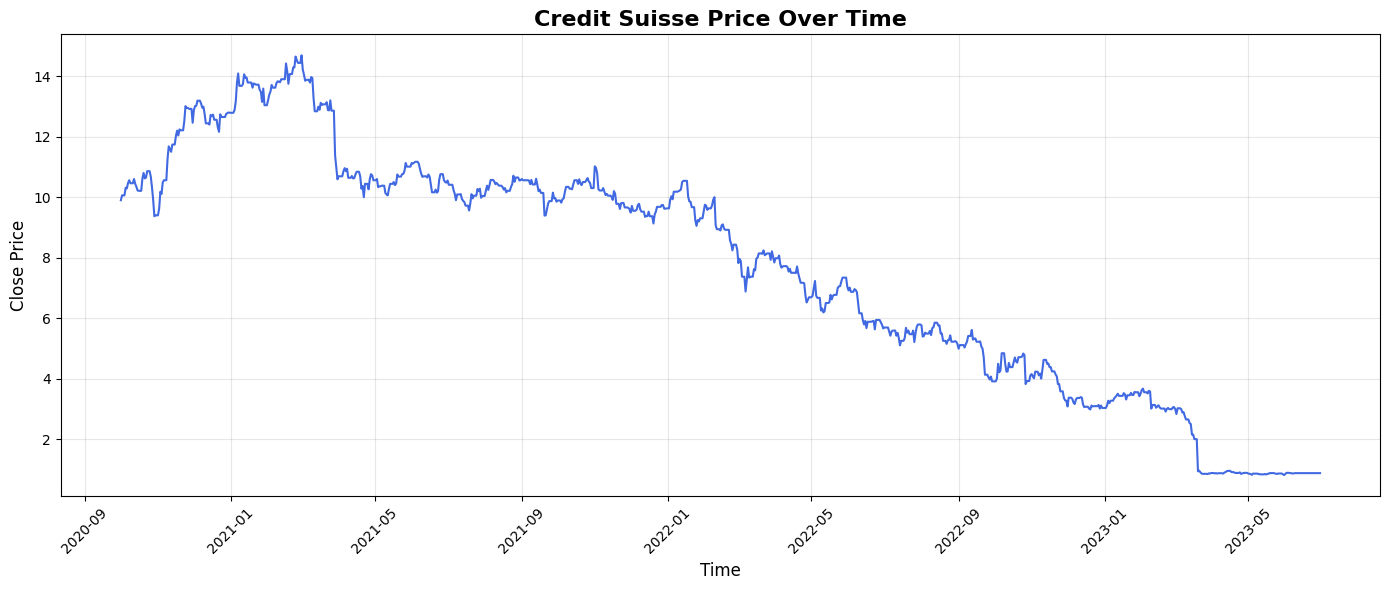

In [322]:
plt.figure(figsize=(14,6))
plt.plot(df_sliver['time'], df_sliver['close'], color='royalblue', linewidth=1.5)

# thêm title, grid, label
plt.title("Credit Suisse Price Over Time", fontsize=16, fontweight='bold')
plt.xlabel("Time", fontsize=12)
plt.ylabel("Close Price", fontsize=12)
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

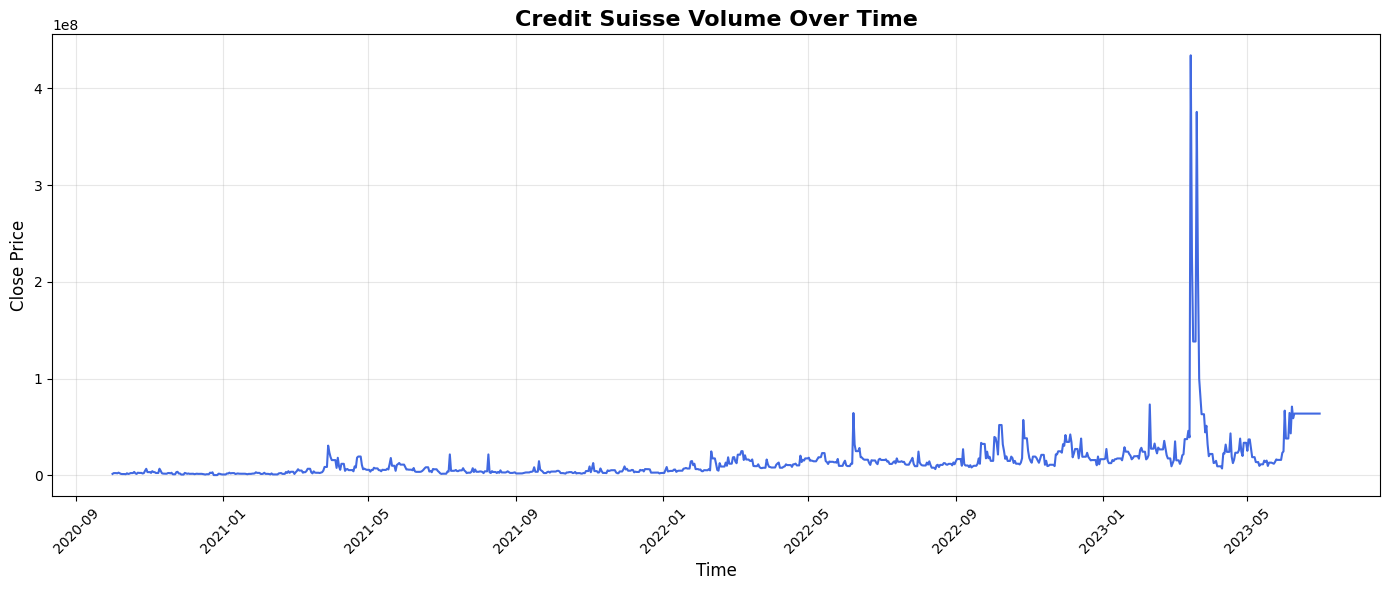

In [323]:
plt.figure(figsize=(14,6))
plt.plot(df_sliver['time'], df_sliver['volume'], color='royalblue', linewidth=1.5)

# thêm title, grid, label
plt.title("Credit Suisse Volume Over Time", fontsize=16, fontweight='bold')
plt.xlabel("Time", fontsize=12)
plt.ylabel("Close Price", fontsize=12)
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [324]:
# Tạo thư mục đích nếu chưa có
sliver_dir = os.path.join(project_dir, "data/sliver/market_data")
os.makedirs(sliver_dir, exist_ok=True)

# Ghép path cho file xuất ra
output_path = os.path.join(sliver_dir, "PRICE_CS_1D.csv")

# Xuất df_sliver ra CSV
df_sliver.to_csv(output_path, index=False)

print(f"Đã lưu file tại: {output_path}")

Đã lưu file tại: d:\Git\ToanMoHinh\tmh2025-vong2\data/sliver/market_data\PRICE_CS_1D.csv


---

## 2. CBOE Volatility Index (Fear Index)

In [325]:
base_dir = os.getcwd() 

# Nhảy lên 1 cấp để tới project/
project_dir = os.path.dirname(base_dir)

# Ghép tới thư mục data
data_dir = os.path.join(project_dir, "data/bronze/market_data")

# Ghép tới file CSV
file_path = os.path.join(data_dir, "CBOE_Volatility_Index_FRED.csv")

df = pd.read_csv(file_path)
df.head()

,observation_date,VIXCLS
0,1990-01-02,17.24
1,1990-01-03,18.19
2,1990-01-04,19.22
3,1990-01-05,20.11
4,1990-01-08,20.26


In [326]:
# Chuẩn hóa tên cột
df = df.rename(columns={"observation_date": "time", "VIXCLS": "close"})
df_sliver = df[["time", "close"]].copy()

# đảm bảo time là datetime
df_sliver['time'] = pd.to_datetime(df_sliver['time'])
df_sliver = df_sliver[(df_sliver['time'] >= start_day) & (df_sliver['time'] <= end_day)]  # lọc dữ liệu từ 2020-10-01 đến 2023-06-30

# Tạo index đầy đủ các ngày trong khoảng
full_index = pd.date_range(start=start_day, end=end_day, freq='D')

# Đặt cột time làm index
df_sliver = df_sliver.set_index('time')

# Reindex theo full_index, điền giá trị bằng ffill
df_sliver = df_sliver.reindex(full_index).ffill()

# Đặt lại tên index thành time (nếu muốn giữ cột)
df_sliver.index.name = 'time'
df_sliver = df_sliver.reset_index()

df_sliver.sort_values(by='time', inplace=True)
display(df_sliver.head())
display(df_sliver.tail())

,time,close
0,2020-10-01,26.70
1,2020-10-02,27.63
2,2020-10-03,27.63
3,2020-10-04,27.63
4,2020-10-05,27.96


,time,close
998,2023-06-26,14.25
999,2023-06-27,13.74
1000,2023-06-28,13.43
1001,2023-06-29,13.54
1002,2023-06-30,13.59


In [327]:
df_sliver.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1003 entries, 0 to 1002
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    1003 non-null   datetime64[ns]
 1   close   1003 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 15.8 KB


>Không có missing value

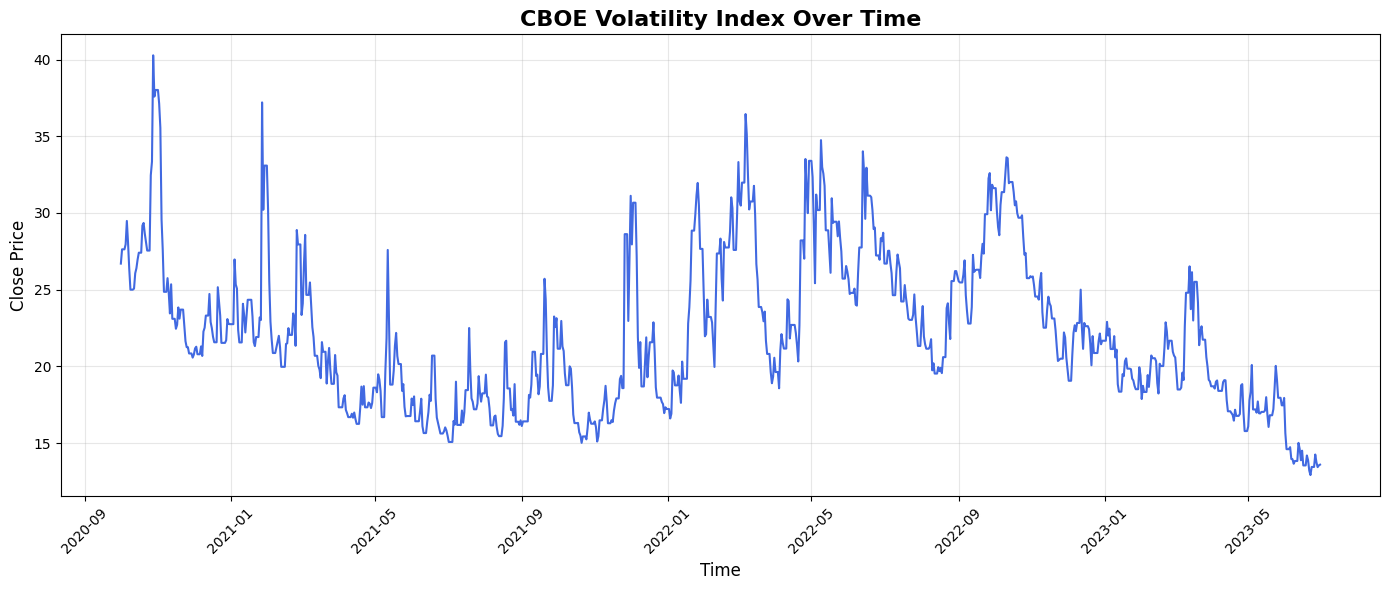

In [328]:
plt.figure(figsize=(14,6))
plt.plot(df_sliver['time'], df_sliver['close'], color='royalblue', linewidth=1.5)

# thêm title, grid, label
plt.title("CBOE Volatility Index Over Time", fontsize=16, fontweight='bold')
plt.xlabel("Time", fontsize=12)
plt.ylabel("Close Price", fontsize=12)
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [329]:
# Tạo thư mục đích nếu chưa có
sliver_dir = os.path.join(project_dir, "data/sliver/market_data")
os.makedirs(sliver_dir, exist_ok=True)

# Ghép path cho file xuất ra
output_path = os.path.join(sliver_dir, "CBOE_Volatility_Index_FRED.csv")

# Xuất df_sliver ra CSV
df_sliver.to_csv(output_path, index=False)

print(f"Đã lưu file tại: {output_path}")

Đã lưu file tại: d:\Git\ToanMoHinh\tmh2025-vong2\data/sliver/market_data\CBOE_Volatility_Index_FRED.csv


---

## 3. STOXX Banks EUR Price (SX7E)

In [330]:
base_dir = os.getcwd()

# Nhảy lên 1 cấp để tới project/
project_dir = os.path.dirname(base_dir)

# Ghép tới thư mục data
data_dir = os.path.join(project_dir, "data/bronze/market_data")

# Ghép tới file CSV
file_path = os.path.join(data_dir, "SX7E_STOXX_Banks_EUR_Price.csv")

df = pd.read_csv(file_path)
df.head()

,Ngày,Lần cuối,Mở,Cao,Thấp,KL,% Thay đổi
0,14/08/2025,235.63,233.12,235.84,233.10,NaN,1.19%
1,13/08/2025,232.86,231.10,233.19,231.10,NaN,0.86%
2,12/08/2025,230.87,230.57,231.76,229.88,NaN,0.32%
3,11/08/2025,230.13,229.33,230.47,227.28,NaN,0.51%
4,08/08/2025,228.97,224.99,229.18,224.72,NaN,1.89%


In [331]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Ngày        3239 non-null   object 
 1   Lần cuối    3239 non-null   float64
 2   Mở          3239 non-null   float64
 3   Cao         3239 non-null   float64
 4   Thấp        3239 non-null   float64
 5   KL          0 non-null      float64
 6   % Thay đổi  3239 non-null   object 
dtypes: float64(5), object(2)
memory usage: 177.3+ KB


In [332]:
# Chuẩn hóa tên cột
df = df.rename(columns={"Ngày": "time", "Lần cuối": "close"})

df_sliver = df[["time", "close"]].copy()

# đảm bảo time là datetime
df_sliver['time'] = pd.to_datetime(df_sliver['time'])
df_sliver = df_sliver[(df_sliver['time'] >= start_day) & (df_sliver['time'] <= end_day)]  # lọc dữ liệu từ 2020-07-01 đến 2023-06-30

# Tạo index đầy đủ các ngày trong khoảng
full_index = pd.date_range(start=start_day, end=end_day, freq='D')

# Đặt cột time làm index
df_sliver = df_sliver.set_index('time')

# Reindex theo full_index, điền giá trị bằng ffill
df_sliver = df_sliver.reindex(full_index).ffill()

# Đặt lại tên index thành time (nếu muốn giữ cột)
df_sliver.index.name = 'time'
df_sliver = df_sliver.reset_index()

df_sliver.sort_values(by='time', inplace=True)
display(df_sliver.head())
display(df_sliver.tail())

C:\Users\PC\AppData\Local\Temp\ipykernel_17744\4110748852.py:7: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_sliver['time'] = pd.to_datetime(df_sliver['time'])


,time,close
0,2020-10-01,53.99
1,2020-10-02,54.15
2,2020-10-03,54.15
3,2020-10-04,54.15
4,2020-10-05,55.31


,time,close
998,2023-06-26,102.54
999,2023-06-27,103.88
1000,2023-06-28,104.59
1001,2023-06-29,106.12
1002,2023-06-30,107.35


In [333]:
df_sliver.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1003 entries, 0 to 1002
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    1003 non-null   datetime64[ns]
 1   close   1003 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 15.8 KB


Không có missing value

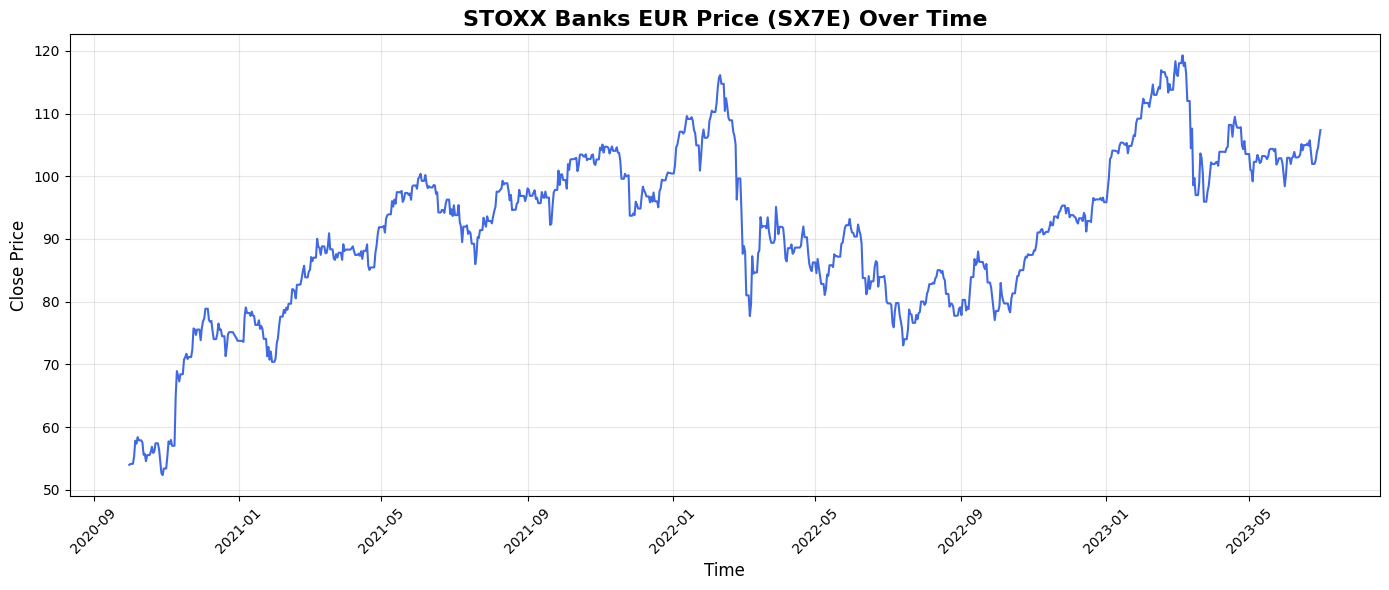

In [334]:
plt.figure(figsize=(14,6))
plt.plot(df_sliver['time'], df_sliver['close'], color='royalblue', linewidth=1.5)

# thêm title, grid, label
plt.title("STOXX Banks EUR Price (SX7E) Over Time", fontsize=16, fontweight='bold')
plt.xlabel("Time", fontsize=12)
plt.ylabel("Close Price", fontsize=12)
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [335]:
# Tạo thư mục đích nếu chưa có
sliver_dir = os.path.join(project_dir, "data/sliver/market_data")
os.makedirs(sliver_dir, exist_ok=True)

# Ghép path cho file xuất ra
output_path = os.path.join(sliver_dir, "SX7E_STOXX_Banks_EUR_Price.csv")

# Xuất df_sliver ra CSV
df_sliver.to_csv(output_path, index=False)

print(f"Đã lưu file tại: {output_path}")

Đã lưu file tại: d:\Git\ToanMoHinh\tmh2025-vong2\data/sliver/market_data\SX7E_STOXX_Banks_EUR_Price.csv


---

## 4. CDS 5 YEAR EUR Credit Suisse

In [336]:
base_dir = os.getcwd()   # ví dụ .../project/notebooks

# Nhảy lên 1 cấp để tới project/
project_dir = os.path.dirname(base_dir)

# Ghép tới thư mục data
data_dir = os.path.join(project_dir, "data/bronze/market_data")

# Ghép tới file CSV
file_path = os.path.join(data_dir, "CDS_5Y_CS_1D.csv")

df = pd.read_csv(file_path)
df.head()

,Ngày,Lần cuối,Mở,Cao,Thấp,% Thay đổi
0,19/07/2023,93.03,93.03,93.03,93.03,-1.06%
1,18/07/2023,94.03,94.03,94.03,92.52,5.57%
2,17/07/2023,89.07,89.07,94.01,89.07,-1.10%
3,14/07/2023,90.06,90.06,90.06,89.53,-1.64%
4,13/07/2023,91.56,91.56,91.56,91.56,-1.06%


In [337]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4045 entries, 0 to 4044
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Ngày        4045 non-null   object
 1   Lần cuối    4045 non-null   object
 2   Mở          4045 non-null   object
 3   Cao         4045 non-null   object
 4   Thấp        4045 non-null   object
 5   % Thay đổi  4045 non-null   object
dtypes: object(6)
memory usage: 189.7+ KB


In [338]:
# Chuẩn hóa tên cột
df = df.rename(columns={"Ngày": "time", "Lần cuối": "close"})

df_sliver = df[["time", "close"]].copy()

# đảm bảo time là datetime
df_sliver['time'] = pd.to_datetime(df_sliver['time'])
df_sliver = df_sliver[(df_sliver['time'] >= start_day) & (df_sliver['time'] <= end_day)]  # lọc dữ liệu từ 2020-07-01 đến 2023-06-30

df_sliver['close'] = pd.to_numeric(df_sliver['close'], errors='coerce')

# Tạo index đầy đủ các ngày trong khoảng
full_index = pd.date_range(start=start_day, end=end_day, freq='D')

# Đặt cột time làm index
df_sliver = df_sliver.set_index('time')

# Reindex theo full_index, điền giá trị bằng ffill
df_sliver = df_sliver.reindex(full_index).ffill()

# Đặt lại tên index thành time (nếu muốn giữ cột)
df_sliver.index.name = 'time'
df_sliver = df_sliver.reset_index()

df_sliver.sort_values(by='time', inplace=True)
display(df_sliver.head())
display(df_sliver.tail())

C:\Users\PC\AppData\Local\Temp\ipykernel_17744\1863605760.py:7: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_sliver['time'] = pd.to_datetime(df_sliver['time'])


,time,close
0,2020-10-01,57.69
1,2020-10-02,56.20
2,2020-10-03,56.20
3,2020-10-04,56.20
4,2020-10-05,54.94


,time,close
998,2023-06-26,101.49
999,2023-06-27,101.48
1000,2023-06-28,100.99
1001,2023-06-29,100.00
1002,2023-06-30,99.00


In [339]:
df_sliver.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1003 entries, 0 to 1002
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    1003 non-null   datetime64[ns]
 1   close   1003 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 15.8 KB


Không có missing value

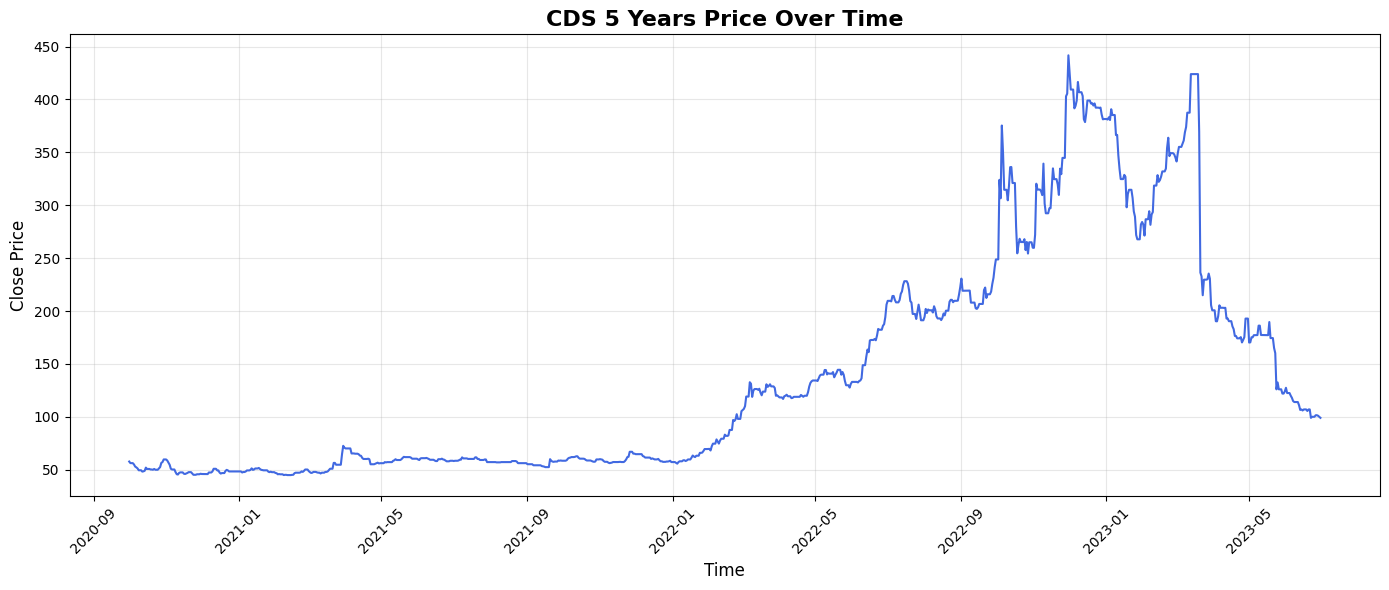

In [340]:
plt.figure(figsize=(14,6))
plt.plot(df_sliver['time'], df_sliver['close'], color='royalblue', linewidth=1.5)

# thêm title, grid, label
plt.title("CDS 5 Years Price Over Time", fontsize=16, fontweight='bold')
plt.xlabel("Time", fontsize=12)
plt.ylabel("Close Price", fontsize=12)
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [341]:
# Tạo thư mục đích nếu chưa có
sliver_dir = os.path.join(project_dir, "data/sliver/market_data")
os.makedirs(sliver_dir, exist_ok=True)

# Ghép path cho file xuất ra
output_path = os.path.join(sliver_dir, "CDS_5Y_CS_1D.csv")

# Xuất df_sliver ra CSV
df_sliver.to_csv(output_path, index=False)

print(f"Đã lưu file tại: {output_path}")

Đã lưu file tại: d:\Git\ToanMoHinh\tmh2025-vong2\data/sliver/market_data\CDS_5Y_CS_1D.csv


## 5. HOUSE - VNINDEX

Đối với 2 chỉ số HOUSE và HNX ta sẽ xét tới cuối năm 2024, vì biến động ở thế giới có thể lan tới Việt Nam chậm hơn

In [342]:
print(f"Ta cần có {(pd.Timestamp('2024-12-31') - pd.Timestamp('2020-10-01')).days + 1} dòng cho 2 chỉ số này")

Ta cần có 1553 dòng cho 2 chỉ số này


In [343]:
base_dir = os.getcwd()

# Nhảy lên 1 cấp để tới project/
project_dir = os.path.dirname(base_dir)

# Ghép tới thư mục data
data_dir = os.path.join(project_dir, "data/bronze/market_data")

# Ghép tới file CSV
file_path = os.path.join(data_dir, "VNINDEX_1D.csv")

df = pd.read_csv(file_path)
df.head()

,Ngày,Lần cuối,Mở,Cao,Thấp,KL,% Thay đổi
0,31/12/2024,"1,266.78","1,272.25","1,272.46","1,266.78",480.54K,-0.41%
1,30/12/2024,"1,272.02","1,275.14","1,275.14","1,268.77",527.66K,-0.24%
2,27/12/2024,"1,275.14","1,272.87","1,277.89","1,272.23",670.32K,0.18%
3,26/12/2024,"1,272.87","1,275.68","1,277.17","1,271.99",595.22K,-0.09%
4,25/12/2024,"1,274.04","1,260.81","1,283.09","1,260.81",810.46K,1.09%


In [344]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1250 entries, 0 to 1249
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Ngày        1250 non-null   object
 1   Lần cuối    1250 non-null   object
 2   Mở          1250 non-null   object
 3   Cao         1250 non-null   object
 4   Thấp        1250 non-null   object
 5   KL          1250 non-null   object
 6   % Thay đổi  1250 non-null   object
dtypes: object(7)
memory usage: 68.5+ KB


In [345]:
# Chuẩn hóa tên cột
df = df.rename(columns={"Ngày": "time", "Lần cuối": "close", "KL": "volume"})

df_sliver = df[["time", "close", "volume"]].copy()

# đảm bảo time là datetime
df_sliver['time'] = pd.to_datetime(df_sliver['time'])
df_sliver = df_sliver[(df_sliver['time'] >= start_day) & (df_sliver['time'] <= '2024-12-31')]  # lọc dữ liệu từ 2020-10-01 đến 2024-12-31

df_sliver['close'] = df_sliver['close'].str.replace(',', '').astype(float)

# Tạo index đầy đủ các ngày trong khoảng
full_index = pd.date_range(start=start_day, end='2024-12-31', freq='D')

# Đặt cột time làm index
df_sliver = df_sliver.set_index('time')

# Reindex theo full_index, điền giá trị bằng ffill
df_sliver = df_sliver.reindex(full_index).ffill()

# Đặt lại tên index thành time (nếu muốn giữ cột)
df_sliver.index.name = 'time'
df_sliver = df_sliver.reset_index()

df_sliver.sort_values(by='time', inplace=True)
display(df_sliver.head())
display(df_sliver.tail())

C:\Users\PC\AppData\Local\Temp\ipykernel_17744\2899098163.py:7: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_sliver['time'] = pd.to_datetime(df_sliver['time'])


,time,close,volume
0,2020-10-01,914.09,352.45K
1,2020-10-02,909.91,527.16K
2,2020-10-03,909.91,527.16K
3,2020-10-04,909.91,527.16K
4,2020-10-05,914.68,456.10K


,time,close,volume
1548,2024-12-27,1275.14,670.32K
1549,2024-12-28,1275.14,670.32K
1550,2024-12-29,1275.14,670.32K
1551,2024-12-30,1272.02,527.66K
1552,2024-12-31,1266.78,480.54K


In [346]:
def convert_volume(x): # Hàm chuẩn hóa volume thành dạng số thực
    if isinstance(x, str):
        x = x.replace(",", "").strip()  # bỏ dấu phẩy nếu có
        if x.endswith("K"):
            return float(x[:-1]) * 1e3
        elif x.endswith("M"):
            return float(x[:-1]) * 1e6
        elif x.endswith("B"):
            return float(x[:-1]) * 1e9
        else:
            return float(x)  # trường hợp không có hậu tố
    return x

# Áp dụng vào cột volume
df_sliver["volume"] = df_sliver["volume"].apply(convert_volume)

# Kiểm tra lại
print(df_sliver.dtypes)
display(df_sliver.head())

time      datetime64[ns]
close            float64
volume           float64
dtype: object


,time,close,volume
0,2020-10-01,914.09,352450.0
1,2020-10-02,909.91,527160.0
2,2020-10-03,909.91,527160.0
3,2020-10-04,909.91,527160.0
4,2020-10-05,914.68,456100.0


In [347]:
df_sliver.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1553 entries, 0 to 1552
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    1553 non-null   datetime64[ns]
 1   close   1553 non-null   float64       
 2   volume  1553 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 36.5 KB


Không có missing value

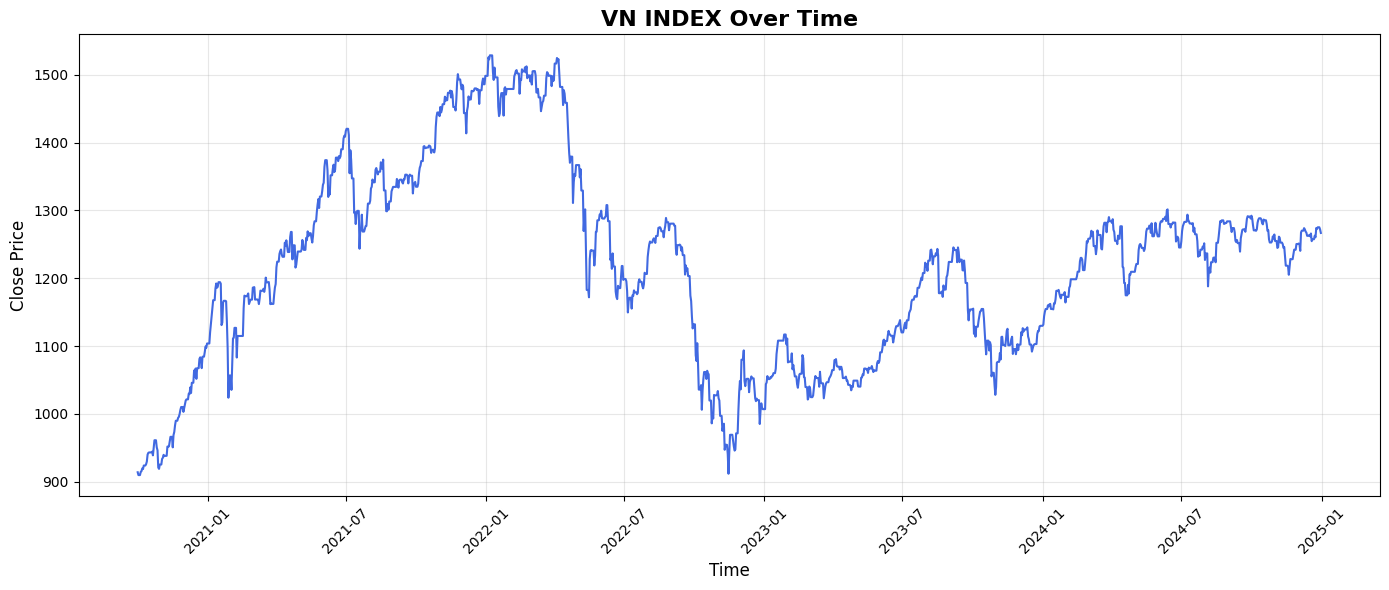

In [348]:
plt.figure(figsize=(14,6))
plt.plot(df_sliver['time'], df_sliver['close'], color='royalblue', linewidth=1.5)

# thêm title, grid, label
plt.title("VN INDEX Over Time", fontsize=16, fontweight='bold')
plt.xlabel("Time", fontsize=12)
plt.ylabel("Close Price", fontsize=12)
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [349]:
# Tạo thư mục đích nếu chưa có
sliver_dir = os.path.join(project_dir, "data/sliver/market_data")
os.makedirs(sliver_dir, exist_ok=True)

# Ghép path cho file xuất ra
output_path = os.path.join(sliver_dir, "VNINDEX_1D.csv")

# Xuất df_sliver ra CSV
df_sliver.to_csv(output_path, index=False)

print(f"Đã lưu file tại: {output_path}")

Đã lưu file tại: d:\Git\ToanMoHinh\tmh2025-vong2\data/sliver/market_data\VNINDEX_1D.csv


## 6. HNX - HNXINDEX

In [350]:
base_dir = os.getcwd()   # ví dụ .../project/notebooks

# Nhảy lên 1 cấp để tới project/
project_dir = os.path.dirname(base_dir)

# Ghép tới thư mục data
data_dir = os.path.join(project_dir, "data/bronze/market_data")

# Ghép tới file CSV
file_path = os.path.join(data_dir, "HNXINDEX_1D.csv")

df = pd.read_csv(file_path)
df.head()

,Ngày,Lần cuối,Mở,Cao,Thấp,KL,% Thay đổi
0,31/12/2024,227.43,228.03,228.34,226.43,36.15K,-0.31%
1,30/12/2024,228.14,228.88,229.34,227.13,34.86K,-0.43%
2,27/12/2024,229.13,230.03,230.50,228.55,46.74K,-0.33%
3,26/12/2024,229.90,229.75,230.87,228.96,40.62K,0.04%
4,25/12/2024,229.81,227.53,230.90,225.52,66.94K,0.63%


In [351]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1250 entries, 0 to 1249
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Ngày        1250 non-null   object 
 1   Lần cuối    1250 non-null   float64
 2   Mở          1250 non-null   float64
 3   Cao         1250 non-null   float64
 4   Thấp        1250 non-null   float64
 5   KL          1250 non-null   object 
 6   % Thay đổi  1250 non-null   object 
dtypes: float64(4), object(3)
memory usage: 68.5+ KB


In [352]:
# Chuẩn hóa tên cột
df = df.rename(columns={"Ngày": "time", "Lần cuối": "close", "KL": "volume"})

df_sliver = df[["time", "close", "volume"]].copy()

# đảm bảo time là datetime
df_sliver['time'] = pd.to_datetime(df_sliver['time'])
df_sliver = df_sliver[(df_sliver['time'] >= start_day) & (df_sliver['time'] <= '2024-12-31')]  # lọc dữ liệu từ 2020-07-01 đến 2024-12-31

# df_sliver['close'] = df_sliver['close'].str.replace(',', '').astype(float)

# Tạo index đầy đủ các ngày trong khoảng
full_index = pd.date_range(start=start_day, end='2024-12-31', freq='D')

# Đặt cột time làm index
df_sliver = df_sliver.set_index('time')

# Reindex theo full_index, điền giá trị bằng ffill
df_sliver = df_sliver.reindex(full_index).ffill()

# Đặt lại tên index thành time (nếu muốn giữ cột)
df_sliver.index.name = 'time'
df_sliver = df_sliver.reset_index()

df_sliver.sort_values(by='time', inplace=True)
display(df_sliver.head())
display(df_sliver.tail())

C:\Users\PC\AppData\Local\Temp\ipykernel_17744\1092815328.py:7: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_sliver['time'] = pd.to_datetime(df_sliver['time'])


,time,close,volume
0,2020-10-01,133.50,54.10K
1,2020-10-02,134.91,87.87K
2,2020-10-03,134.91,87.87K
3,2020-10-04,134.91,87.87K
4,2020-10-05,137.19,79.26K


,time,close,volume
1548,2024-12-27,229.13,46.74K
1549,2024-12-28,229.13,46.74K
1550,2024-12-29,229.13,46.74K
1551,2024-12-30,228.14,34.86K
1552,2024-12-31,227.43,36.15K


In [353]:
# Áp dụng vào cột volume
df_sliver["volume"] = df_sliver["volume"].apply(convert_volume)

# Kiểm tra lại
print(df_sliver.dtypes)
display(df_sliver.head())

time      datetime64[ns]
close            float64
volume           float64
dtype: object


,time,close,volume
0,2020-10-01,133.50,54100.0
1,2020-10-02,134.91,87870.0
2,2020-10-03,134.91,87870.0
3,2020-10-04,134.91,87870.0
4,2020-10-05,137.19,79260.0


In [354]:
df_sliver.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1553 entries, 0 to 1552
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    1553 non-null   datetime64[ns]
 1   close   1553 non-null   float64       
 2   volume  1553 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 36.5 KB


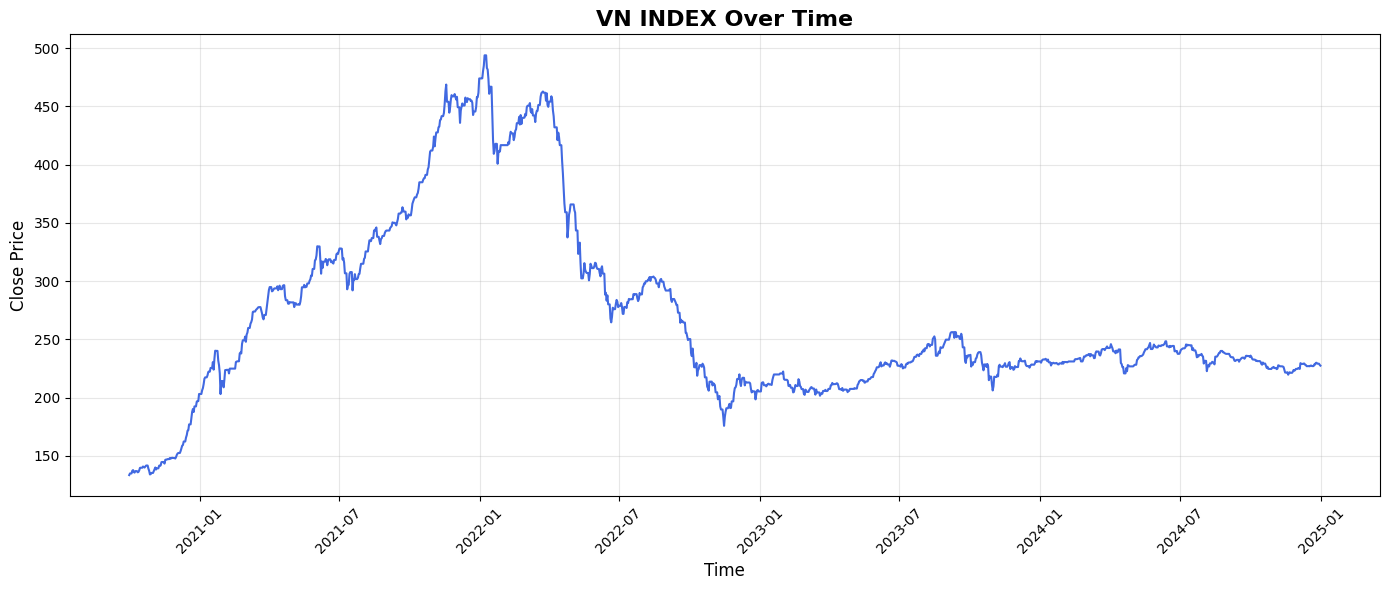

In [355]:
plt.figure(figsize=(14,6))
plt.plot(df_sliver['time'], df_sliver['close'], color='royalblue', linewidth=1.5)

# thêm title, grid, label
plt.title("VN INDEX Over Time", fontsize=16, fontweight='bold')
plt.xlabel("Time", fontsize=12)
plt.ylabel("Close Price", fontsize=12)
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [356]:
# Tạo thư mục đích nếu chưa có
sliver_dir = os.path.join(project_dir, "data/sliver/market_data")
os.makedirs(sliver_dir, exist_ok=True)

# Ghép path cho file xuất ra
output_path = os.path.join(sliver_dir, "HNXINDEX_1D.csv")

# Xuất df_sliver ra CSV
df_sliver.to_csv(output_path, index=False)

print(f"Đã lưu file tại: {output_path}")

Đã lưu file tại: d:\Git\ToanMoHinh\tmh2025-vong2\data/sliver/market_data\HNXINDEX_1D.csv


---

## 7. S&P 500 

In [357]:
base_dir = os.getcwd()

# Nhảy lên 1 cấp để tới project/
project_dir = os.path.dirname(base_dir)

# Ghép tới thư mục data
data_dir = os.path.join(project_dir, "data/bronze/market_data")

# Ghép tới file CSV
file_path = os.path.join(data_dir, "SP_500_1D.csv")

df = pd.read_csv(file_path)
df.head()

,time,close,Volume
0,2018-03-06,2728.12,2080635490
1,2018-03-07,2726.80,2204997480
2,2018-03-08,2738.97,2047404580
3,2018-03-09,2786.57,2195651360
4,2018-03-12,2783.02,2157969180


In [358]:
# Chuẩn hóa tên cột
df_sliver = df[["time", "close", "Volume"]].copy()
df_sliver = df_sliver.rename(columns={"Volume": "volume"})

# đảm bảo time là datetime
df_sliver['time'] = pd.to_datetime(df_sliver['time'])
df_sliver = df_sliver[(df_sliver['time'] >= start_day) & (df_sliver['time'] <= end_day)]  # lọc dữ liệu từ 2020-07-01 đến 2023-06-30

# Tạo index đầy đủ các ngày trong khoảng
full_index = pd.date_range(start=start_day, end=end_day, freq='D')

# Đặt cột time làm index
df_sliver = df_sliver.set_index('time')

# Reindex theo full_index, điền giá trị bằng ffill
df_sliver = df_sliver.reindex(full_index).ffill()

# Đặt lại tên index thành time  giữ cột)
df_sliver.index.name = 'time'
df_sliver = df_sliver.reset_index()

df_sliver.sort_values(by='time', inplace=True)
display(df_sliver.head())
display(df_sliver.tail())

,time,close,volume
0,2020-10-01,3380.80,2.355862e+09
1,2020-10-02,3348.44,2.350091e+09
2,2020-10-03,3348.44,2.350091e+09
3,2020-10-04,3348.44,2.350091e+09
4,2020-10-05,3408.63,2.040148e+09


,time,close,volume
998,2023-06-26,4328.81,2.224000e+09
999,2023-06-27,4378.40,2.254000e+09
1000,2023-06-28,4376.85,2.245000e+09
1001,2023-06-29,4396.45,2.127000e+09
1002,2023-06-30,4450.37,2.440000e+09


In [359]:
df_sliver.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1003 entries, 0 to 1002
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    1003 non-null   datetime64[ns]
 1   close   1003 non-null   float64       
 2   volume  1003 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 23.6 KB


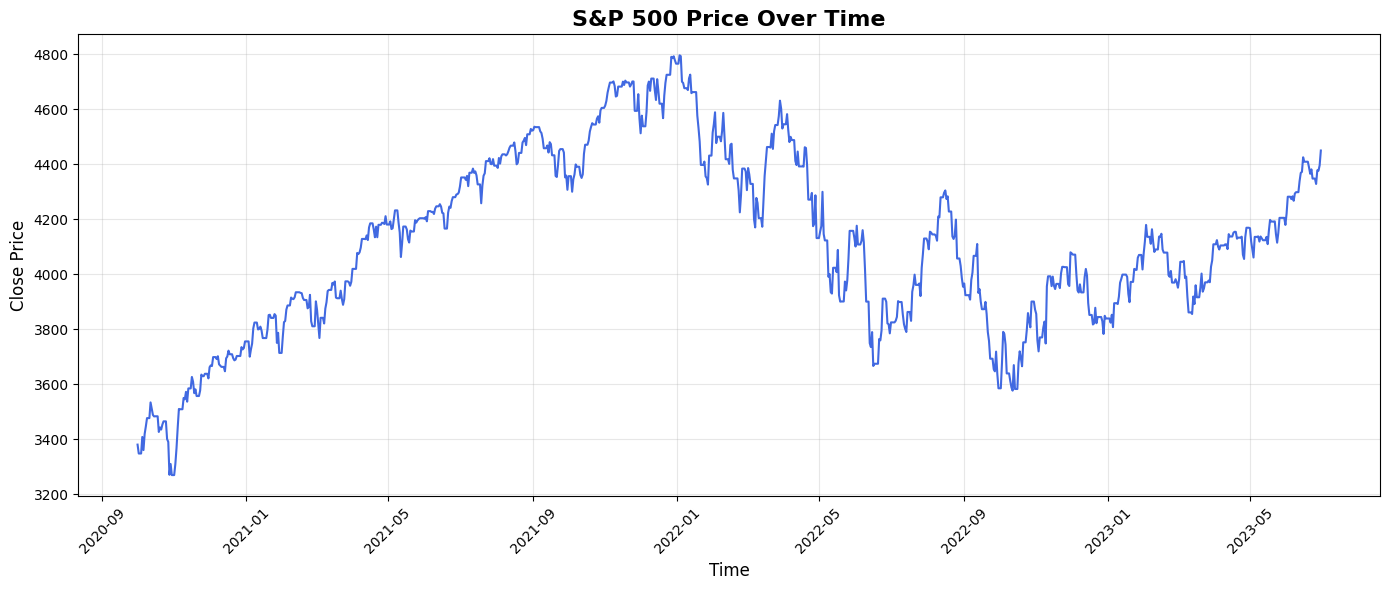

In [360]:
plt.figure(figsize=(14,6))
plt.plot(df_sliver['time'], df_sliver['close'], color='royalblue', linewidth=1.5)

# thêm title, grid, label
plt.title("S&P 500 Price Over Time", fontsize=16, fontweight='bold')
plt.xlabel("Time", fontsize=12)
plt.ylabel("Close Price", fontsize=12)
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [361]:
# Tạo thư mục đích nếu chưa có
sliver_dir = os.path.join(project_dir, "data/sliver/market_data")
os.makedirs(sliver_dir, exist_ok=True)

# Ghép path cho file xuất ra
output_path = os.path.join(sliver_dir, "SP_500_1D.csv")

# Xuất df_sliver ra CSV
df_sliver.to_csv(output_path, index=False)

print(f"Đã lưu file tại: {output_path}")

Đã lưu file tại: d:\Git\ToanMoHinh\tmh2025-vong2\data/sliver/market_data\SP_500_1D.csv


---

## 8. NOVA LAND

In [13]:
base_dir = os.getcwd()

# Nhảy lên 1 cấp để tới project/
project_dir = os.path.dirname(base_dir)

# Ghép tới thư mục data
data_dir = os.path.join(project_dir, "data/bronze/market_data")

# Ghép tới file CSV
file_path = os.path.join(data_dir, "HOSE_DLY_NVL-1D.csv")

df = pd.read_csv(file_path)
df.head()

,time,close,Volume
0,2018-10-29,39608.907172,3.461120e+06
1,2018-10-30,39052.602297,4.999039e+05
2,2018-10-31,39553.276686,7.244657e+06
3,2018-11-01,39497.646198,5.307284e+06
4,2018-11-02,39553.276686,1.227794e+06


In [14]:
# Chuẩn hóa tên cột
df_sliver = df[["time", "close", "Volume"]].copy()
df_sliver = df_sliver.rename(columns={"Volume": "volume"})

# đảm bảo time là datetime
df_sliver['time'] = pd.to_datetime(df_sliver['time'])
df_sliver = df_sliver[(df_sliver['time'] >= start_day) & (df_sliver['time'] <= end_day)]  # lọc dữ liệu từ 2020-07-01 đến 2023-06-30

# Tạo index đầy đủ các ngày trong khoảng
full_index = pd.date_range(start=start_day, end=end_day, freq='D')

# Đặt cột time làm index
df_sliver = df_sliver.set_index('time')

# Reindex theo full_index, điền giá trị bằng ffill
df_sliver = df_sliver.reindex(full_index).ffill()

# Đặt lại tên index thành time  giữ cột)
df_sliver.index.name = 'time'
df_sliver = df_sliver.reset_index()

df_sliver.sort_values(by='time', inplace=True)
display(df_sliver.head())
display(df_sliver.tail())

,time,close,volume
0,2020-10-01,35436.620603,3.650009e+06
1,2020-10-02,35325.359627,3.631370e+06
2,2020-10-03,35325.359627,3.631370e+06
3,2020-10-04,35325.359627,3.631370e+06
4,2020-10-05,35214.098652,3.259864e+06


,time,close,volume
998,2023-06-26,14900.0,53445800.0
999,2023-06-27,15000.0,46416400.0
1000,2023-06-28,15600.0,73985100.0
1001,2023-06-29,15000.0,39219600.0
1002,2023-06-30,14850.0,33828014.0


In [15]:
df_sliver.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1003 entries, 0 to 1002
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    1003 non-null   datetime64[ns]
 1   close   1003 non-null   float64       
 2   volume  1003 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 23.6 KB


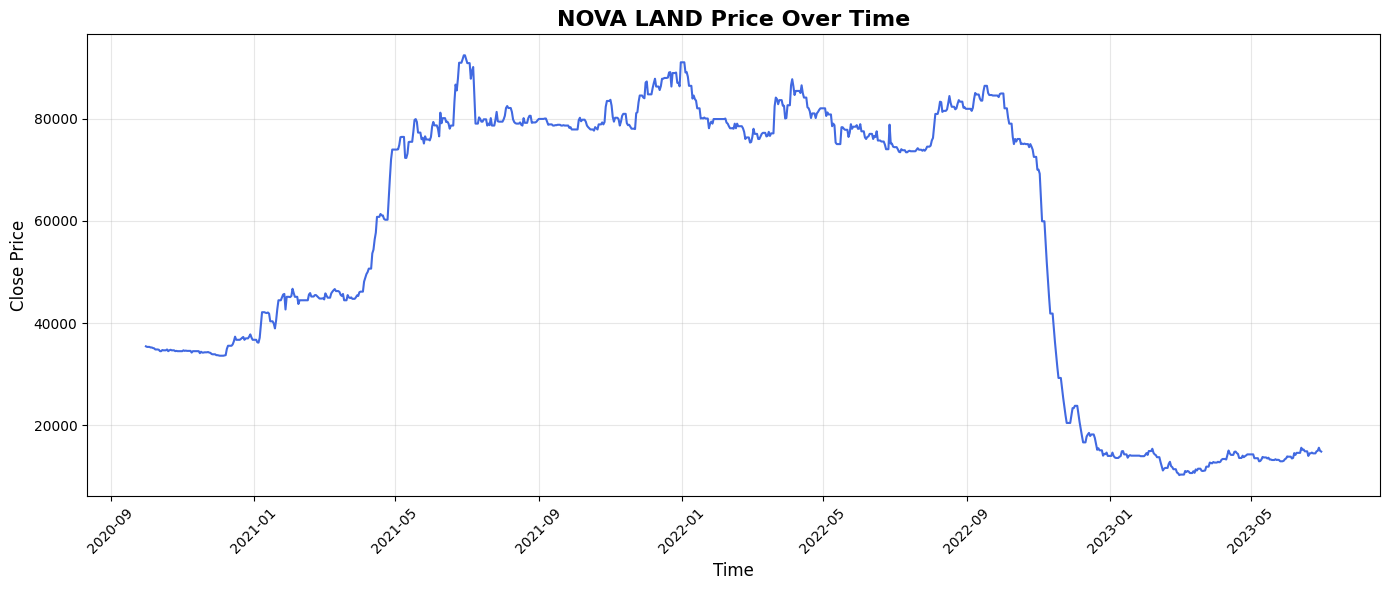

In [16]:
plt.figure(figsize=(14,6))
plt.plot(df_sliver['time'], df_sliver['close'], color='royalblue', linewidth=1.5)

# thêm title, grid, label
plt.title("NOVA LAND Price Over Time", fontsize=16, fontweight='bold')
plt.xlabel("Time", fontsize=12)
plt.ylabel("Close Price", fontsize=12)
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [17]:
# Tạo thư mục đích nếu chưa có
sliver_dir = os.path.join(project_dir, "data/sliver/market_data")
os.makedirs(sliver_dir, exist_ok=True)

# Ghép path cho file xuất ra
output_path = os.path.join(sliver_dir, "HOSE_DLY_NVL-1D.csv")

# Xuất df_sliver ra CSV
df_sliver.to_csv(output_path, index=False)

print(f"Đã lưu file tại: {output_path}")

Đã lưu file tại: d:\Git\ToanMoHinh\tmh2025-vong2\data/sliver/market_data\HOSE_DLY_NVL-1D.csv


# B. MARCO ECONOMIC DATA

## 1. GROW AND INFLACTION

In [362]:
start_day = "2020-10-01"
end_day = "2023-06-30"

### 1.1 SWITZERLAND CPI

In [363]:
base_dir = os.getcwd()   # ví dụ .../project/notebooks

# Nhảy lên 1 cấp để tới project/
project_dir = os.path.dirname(base_dir)

# Ghép tới thư mục data
data_dir = os.path.join(project_dir, r"data\bronze\macro_economic_data\growth_and_inflation")

# Ghép tới file CSV
file_path = os.path.join(data_dir, "ECONOMICS_CHCPI-1D.csv")

df = pd.read_csv(file_path)
df.head()

,time,close,Volume
0,1950-01-31,21.17,NaN
1,1950-02-28,21.09,NaN
2,1950-03-31,21.05,NaN
3,1950-04-30,20.99,NaN
4,1950-05-31,21.08,NaN


In [364]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 907 entries, 0 to 906
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    907 non-null    object 
 1   close   907 non-null    float64
 2   Volume  0 non-null      float64
dtypes: float64(2), object(1)
memory usage: 21.4+ KB


In [365]:
# Chọn cột cần thiết
df_sliver = df[["time", "close"]].copy()
df_sliver['time'] = pd.to_datetime(df_sliver['time'])

# Lọc trong khoảng
df_sliver = df_sliver[(df_sliver['time'] >= start_day) & (df_sliver['time'] <= end_day)]

# Đặt index
df_sliver = df_sliver.set_index("time")

# Reindex với full calendar
full_index = pd.date_range(start=start_day, end=end_day, freq="D")
df_sliver = df_sliver.reindex(full_index)

# --- Fix giá trị cho ngày start_day ---
# Lấy dữ liệu ngày trước start_day
prev_row = df[df['time'] < start_day].sort_values(by="time").iloc[-1]
df_sliver.loc[pd.to_datetime(start_day), ["close"]] = [prev_row["close"]]

# Ffill cho các ngày còn lại (02/07 trở đi)
df_sliver = df_sliver.ffill()

# Reset index
df_sliver.index.name = "time"
df_sliver = df_sliver.reset_index()

df_sliver.sort_values(by='time', inplace=True)
display(df_sliver.head())
display(df_sliver.tail())

,time,close
0,2020-10-01,100.34
1,2020-10-02,100.34
2,2020-10-03,100.34
3,2020-10-04,100.34
4,2020-10-05,100.34


,time,close
998,2023-06-26,106.25
999,2023-06-27,106.25
1000,2023-06-28,106.25
1001,2023-06-29,106.25
1002,2023-06-30,106.32


In [366]:
df_sliver.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1003 entries, 0 to 1002
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    1003 non-null   datetime64[ns]
 1   close   1003 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 15.8 KB


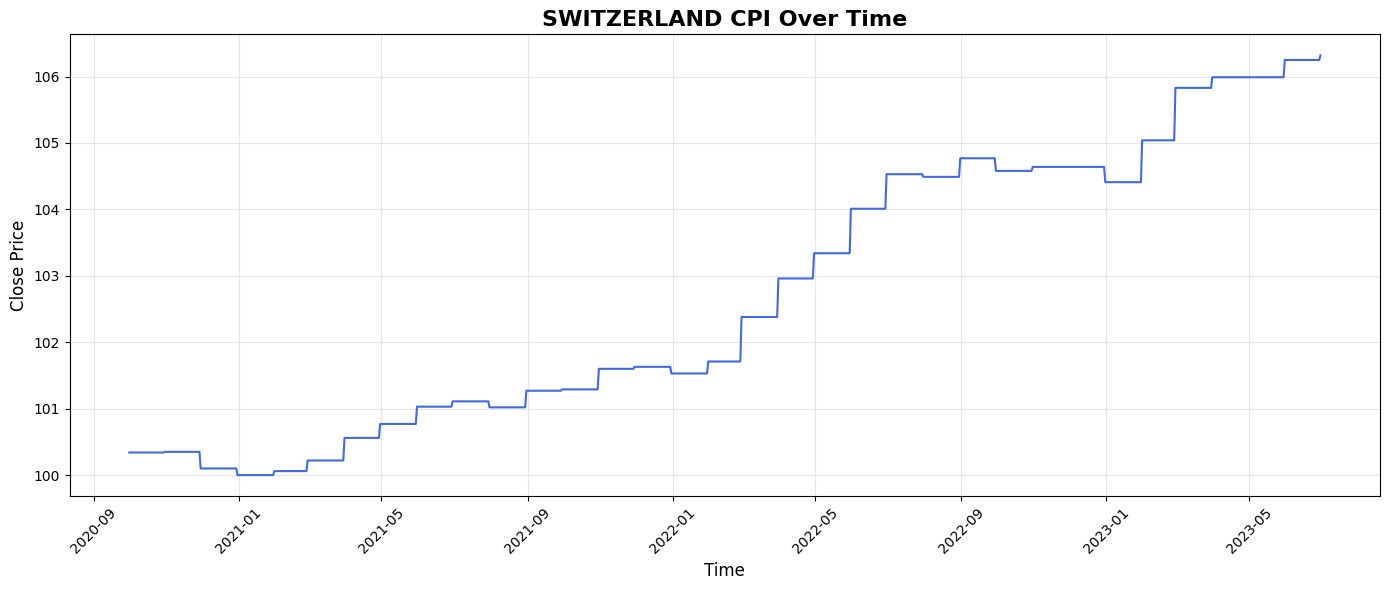

In [367]:
plt.figure(figsize=(14,6))
plt.plot(df_sliver['time'], df_sliver['close'], color='royalblue', linewidth=1.5)

# thêm title, grid, label
plt.title("SWITZERLAND CPI Over Time", fontsize=16, fontweight='bold')
plt.xlabel("Time", fontsize=12)
plt.ylabel("Close Price", fontsize=12)
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [368]:
# Tạo thư mục đích nếu chưa có
sliver_dir = os.path.join(project_dir, "data/sliver/macro_economic_data/growth_and_inflation")
os.makedirs(sliver_dir, exist_ok=True)

# Ghép path cho file xuất ra
output_path = os.path.join(sliver_dir, "ECONOMICS_CHCPI-1D.csv")

# Xuất df_sliver ra CSV
df_sliver.to_csv(output_path, index=False)

print(f"Đã lưu file tại: {output_path}")

Đã lưu file tại: d:\Git\ToanMoHinh\tmh2025-vong2\data/sliver/macro_economic_data/growth_and_inflation\ECONOMICS_CHCPI-1D.csv


---

### 1.2 EURO CPI

In [369]:
base_dir = os.getcwd()   # ví dụ .../project/notebooks

# Nhảy lên 1 cấp để tới project/
project_dir = os.path.dirname(base_dir)

# Ghép tới thư mục data
data_dir = os.path.join(project_dir, r"data\bronze\macro_economic_data\growth_and_inflation")

# Ghép tới file CSV
file_path = os.path.join(data_dir, "ECONOMICS_EUCPI-1D.csv")

df = pd.read_csv(file_path)
df.head()

,time,close,Volume
0,1996-01-31,70.97,NaN
1,1996-02-29,71.29,NaN
2,1996-03-31,71.54,NaN
3,1996-04-30,71.66,NaN
4,1996-05-31,71.83,NaN


In [370]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 355 entries, 0 to 354
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    355 non-null    object 
 1   close   355 non-null    float64
 2   Volume  0 non-null      float64
dtypes: float64(2), object(1)
memory usage: 8.4+ KB


In [371]:
# Chọn cột cần thiết
df_sliver = df[["time", "close"]].copy()
df_sliver['time'] = pd.to_datetime(df_sliver['time'])

# Lọc trong khoảng
df_sliver = df_sliver[(df_sliver['time'] >= start_day) & (df_sliver['time'] <= end_day)]

# Đặt index
df_sliver = df_sliver.set_index("time")

# Reindex với full calendar
full_index = pd.date_range(start=start_day, end=end_day, freq="D")
df_sliver = df_sliver.reindex(full_index)

# --- Fix giá trị cho ngày start_day ---
# Lấy dữ liệu ngày trước start_day
prev_row = df[df['time'] < start_day].sort_values(by="time").iloc[-1]
df_sliver.loc[pd.to_datetime(start_day), ["close"]] = [prev_row["close"]]

# Ffill cho các ngày còn lại (02/07 trở đi)
df_sliver = df_sliver.ffill()

# Reset index
df_sliver.index.name = "time"
df_sliver = df_sliver.reset_index()

df_sliver.sort_values(by='time', inplace=True)
display(df_sliver.head())
display(df_sliver.tail())

,time,close
0,2020-10-01,104.96
1,2020-10-02,104.96
2,2020-10-03,104.96
3,2020-10-04,104.96
4,2020-10-05,104.96


,time,close
998,2023-06-26,123.15
999,2023-06-27,123.15
1000,2023-06-28,123.15
1001,2023-06-29,123.15
1002,2023-06-30,123.47


In [372]:
df_sliver.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1003 entries, 0 to 1002
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    1003 non-null   datetime64[ns]
 1   close   1003 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 15.8 KB


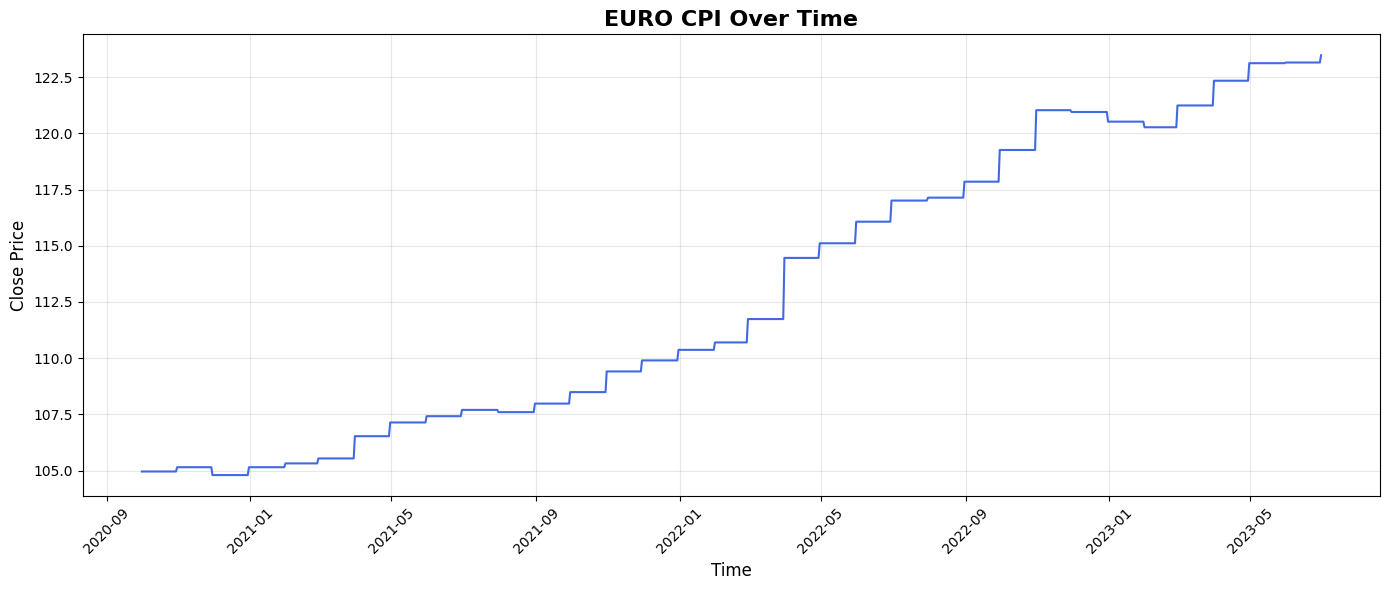

In [373]:
plt.figure(figsize=(14,6))
plt.plot(df_sliver['time'], df_sliver['close'], color='royalblue', linewidth=1.5)

# thêm title, grid, label
plt.title("EURO CPI Over Time", fontsize=16, fontweight='bold')
plt.xlabel("Time", fontsize=12)
plt.ylabel("Close Price", fontsize=12)
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [374]:
# Tạo thư mục đích nếu chưa có
sliver_dir = os.path.join(project_dir, "data/sliver/macro_economic_data/growth_and_inflation")
os.makedirs(sliver_dir, exist_ok=True)

# Ghép path cho file xuất ra
output_path = os.path.join(sliver_dir, "ECONOMICS_EUCPI-1D.csv")

# Xuất df_sliver ra CSV
df_sliver.to_csv(output_path, index=False)

print(f"Đã lưu file tại: {output_path}")

Đã lưu file tại: d:\Git\ToanMoHinh\tmh2025-vong2\data/sliver/macro_economic_data/growth_and_inflation\ECONOMICS_EUCPI-1D.csv


---

### 1.3 US CPI

In [375]:
base_dir = os.getcwd()   # ví dụ .../project/notebooks

# Nhảy lên 1 cấp để tới project/
project_dir = os.path.dirname(base_dir)

# Ghép tới thư mục data
data_dir = os.path.join(project_dir, r"data\bronze\macro_economic_data\growth_and_inflation")

# Ghép tới file CSV
file_path = os.path.join(data_dir, "ECONOMICS_USCPI-1D.csv")

df = pd.read_csv(file_path)
df.head()

,time,close,Volume
0,1950-01-31,23.5,NaN
1,1950-02-28,23.5,NaN
2,1950-03-31,23.6,NaN
3,1950-04-30,23.6,NaN
4,1950-05-31,23.7,NaN


In [376]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 907 entries, 0 to 906
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    907 non-null    object 
 1   close   907 non-null    float64
 2   Volume  0 non-null      float64
dtypes: float64(2), object(1)
memory usage: 21.4+ KB


In [377]:
# Chọn cột cần thiết
df_sliver = df[["time", "close"]].copy()
df_sliver['time'] = pd.to_datetime(df_sliver['time'])

# Lọc trong khoảng
df_sliver = df_sliver[(df_sliver['time'] >= start_day) & (df_sliver['time'] <= end_day)]

# Đặt index
df_sliver = df_sliver.set_index("time")

# Reindex với full calendar
full_index = pd.date_range(start=start_day, end=end_day, freq="D")
df_sliver = df_sliver.reindex(full_index)

# --- Fix giá trị cho ngày start_day ---
# Lấy dữ liệu ngày trước start_day
prev_row = df[df['time'] < start_day].sort_values(by="time").iloc[-1]
df_sliver.loc[pd.to_datetime(start_day), ["close"]] = [prev_row["close"]]

# Ffill cho các ngày còn lại (02/07 trở đi)
df_sliver = df_sliver.ffill()

# Reset index
df_sliver.index.name = "time"
df_sliver = df_sliver.reset_index()

df_sliver.sort_values(by='time', inplace=True)
display(df_sliver.head())
display(df_sliver.tail())

,time,close
0,2020-10-01,260.28
1,2020-10-02,260.28
2,2020-10-03,260.28
3,2020-10-04,260.28
4,2020-10-05,260.28


,time,close
998,2023-06-26,304.127
999,2023-06-27,304.127
1000,2023-06-28,304.127
1001,2023-06-29,304.127
1002,2023-06-30,305.109


In [378]:
df_sliver.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1003 entries, 0 to 1002
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    1003 non-null   datetime64[ns]
 1   close   1003 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 15.8 KB


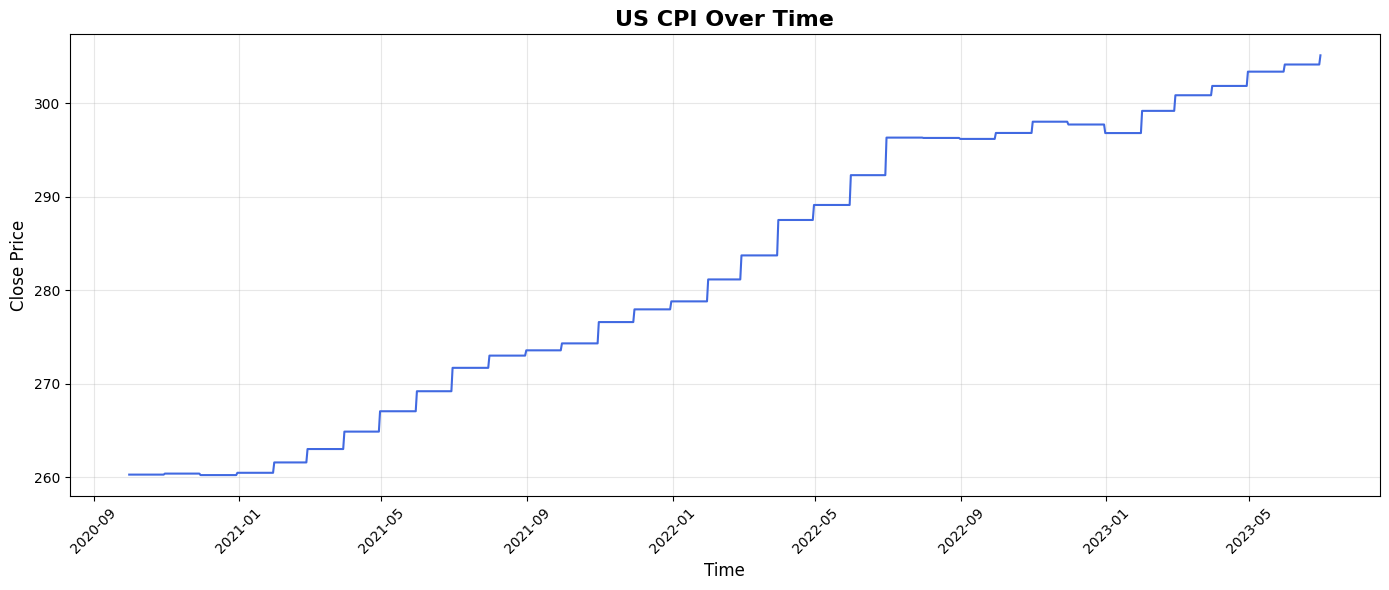

In [379]:
plt.figure(figsize=(14,6))
plt.plot(df_sliver['time'], df_sliver['close'], color='royalblue', linewidth=1.5)

# thêm title, grid, label
plt.title("US CPI Over Time", fontsize=16, fontweight='bold')
plt.xlabel("Time", fontsize=12)
plt.ylabel("Close Price", fontsize=12)
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [380]:
# Tạo thư mục đích nếu chưa có
sliver_dir = os.path.join(project_dir, "data/sliver/macro_economic_data/growth_and_inflation")
os.makedirs(sliver_dir, exist_ok=True)

# Ghép path cho file xuất ra
output_path = os.path.join(sliver_dir, "ECONOMICS_ USCPI-1D.csv")

# Xuất df_sliver ra CSV
df_sliver.to_csv(output_path, index=False)

print(f"Đã lưu file tại: {output_path}")

Đã lưu file tại: d:\Git\ToanMoHinh\tmh2025-vong2\data/sliver/macro_economic_data/growth_and_inflation\ECONOMICS_ USCPI-1D.csv


---

### 1.4 SWITZERLAND GDP

In [381]:
base_dir = os.getcwd()   # ví dụ .../project/notebooks

# Nhảy lên 1 cấp để tới project/
project_dir = os.path.dirname(base_dir)

# Ghép tới thư mục data
data_dir = os.path.join(project_dir, r"data\bronze\macro_economic_data\growth_and_inflation")

# Ghép tới file CSV
file_path = os.path.join(data_dir, "ECONOMICS_CHGDPCP_1D.csv")

df = pd.read_csv(file_path)
df.head()

,time,close,Volume
0,1980-03-31,9.035605e+10,NaN
1,1980-06-30,9.049649e+10,NaN
2,1980-09-30,9.095763e+10,NaN
3,1980-12-31,9.148353e+10,NaN
4,1981-03-31,9.144751e+10,NaN


In [382]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181 entries, 0 to 180
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    181 non-null    object 
 1   close   181 non-null    float64
 2   Volume  0 non-null      float64
dtypes: float64(2), object(1)
memory usage: 4.4+ KB


In [383]:
# Chọn cột cần thiết
df_sliver = df[["time", "close"]].copy()
df_sliver['time'] = pd.to_datetime(df_sliver['time'])

# Lọc trong khoảng
df_sliver = df_sliver[(df_sliver['time'] >= start_day) & (df_sliver['time'] <= end_day)]

# Đặt index
df_sliver = df_sliver.set_index("time")

# Reindex với full calendar
full_index = pd.date_range(start=start_day, end=end_day, freq="D")
df_sliver = df_sliver.reindex(full_index)

# --- Fix giá trị cho ngày start_day ---
# Lấy dữ liệu ngày trước start_day
prev_row = df[df['time'] < start_day].sort_values(by="time").iloc[-1]
df_sliver.loc[pd.to_datetime(start_day), ["close"]] = [prev_row["close"]]

# Ffill cho các ngày còn lại (02/07 trở đi)
df_sliver = df_sliver.ffill()

# Reset index
df_sliver.index.name = "time"
df_sliver = df_sliver.reset_index()

df_sliver.sort_values(by='time', inplace=True)
display(df_sliver.head())
display(df_sliver.tail())

,time,close
0,2020-10-01,1.783929e+11
1,2020-10-02,1.783929e+11
2,2020-10-03,1.783929e+11
3,2020-10-04,1.783929e+11
4,2020-10-05,1.783929e+11


,time,close
998,2023-06-26,1.915362e+11
999,2023-06-27,1.915362e+11
1000,2023-06-28,1.915362e+11
1001,2023-06-29,1.915362e+11
1002,2023-06-30,1.911890e+11


In [384]:
df_sliver.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1003 entries, 0 to 1002
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    1003 non-null   datetime64[ns]
 1   close   1003 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 15.8 KB


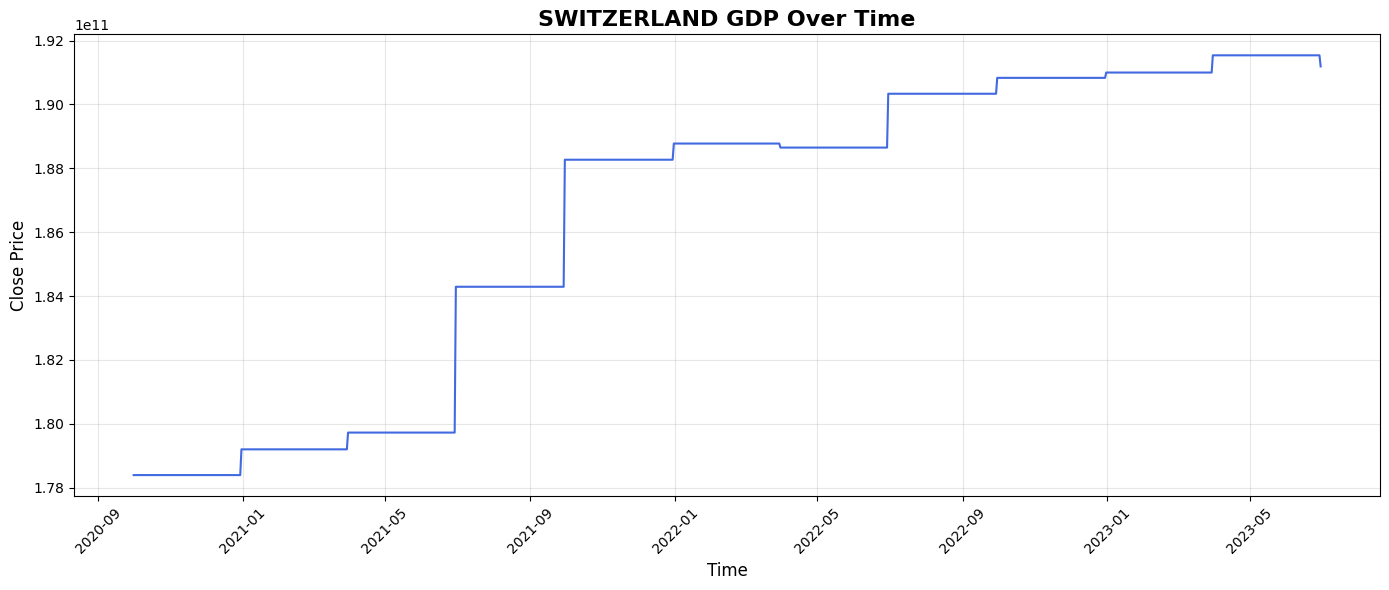

In [385]:
plt.figure(figsize=(14,6))
plt.plot(df_sliver['time'], df_sliver['close'], color='royalblue', linewidth=1.5)

# thêm title, grid, label
plt.title("SWITZERLAND GDP Over Time", fontsize=16, fontweight='bold')
plt.xlabel("Time", fontsize=12)
plt.ylabel("Close Price", fontsize=12)
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [386]:
# Tạo thư mục đích nếu chưa có
sliver_dir = os.path.join(project_dir, "data/sliver/macro_economic_data/growth_and_inflation")
os.makedirs(sliver_dir, exist_ok=True)

# Ghép path cho file xuất ra
output_path = os.path.join(sliver_dir, "ECONOMICS_CHGDPCP_1D.csv")

# Xuất df_sliver ra CSV
df_sliver.to_csv(output_path, index=False)

print(f"Đã lưu file tại: {output_path}")

Đã lưu file tại: d:\Git\ToanMoHinh\tmh2025-vong2\data/sliver/macro_economic_data/growth_and_inflation\ECONOMICS_CHGDPCP_1D.csv


---

### 1.5 EU GDP

In [387]:
base_dir = os.getcwd()   # ví dụ .../project/notebooks

# Nhảy lên 1 cấp để tới project/
project_dir = os.path.dirname(base_dir)

# Ghép tới thư mục data
data_dir = os.path.join(project_dir, r"data\bronze\macro_economic_data\growth_and_inflation")

# Ghép tới file CSV
file_path = os.path.join(data_dir, "ECONOMICS_EUGDPCP_1D.csv")

df = pd.read_csv(file_path)
df.head()

,time,close,Volume
0,1995-03-31,1.884619e+12,NaN
1,1995-06-30,1.899621e+12,NaN
2,1995-09-30,1.904414e+12,NaN
3,1995-12-31,1.907809e+12,NaN
4,1996-03-31,1.910806e+12,NaN


In [388]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122 entries, 0 to 121
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    122 non-null    object 
 1   close   122 non-null    float64
 2   Volume  0 non-null      float64
dtypes: float64(2), object(1)
memory usage: 3.0+ KB


In [389]:
# Chọn cột cần thiết
df_sliver = df[["time", "close"]].copy()
df_sliver['time'] = pd.to_datetime(df_sliver['time'])

# Lọc trong khoảng
df_sliver = df_sliver[(df_sliver['time'] >= start_day) & (df_sliver['time'] <= end_day)]

# Đặt index
df_sliver = df_sliver.set_index("time")

# Reindex với full calendar
full_index = pd.date_range(start=start_day, end=end_day, freq="D")
df_sliver = df_sliver.reindex(full_index)

# --- Fix giá trị cho ngày start_day ---
# Lấy dữ liệu ngày trước start_day
prev_row = df[df['time'] < start_day].sort_values(by="time").iloc[-1]
df_sliver.loc[pd.to_datetime(start_day), ["close"]] = [prev_row["close"]]

# Ffill cho các ngày còn lại (02/07 trở đi)
df_sliver = df_sliver.ffill()

# Reset index
df_sliver.index.name = "time"
df_sliver = df_sliver.reset_index()

df_sliver.sort_values(by='time', inplace=True)
display(df_sliver.head())
display(df_sliver.tail())

,time,close
0,2020-10-01,2.768364e+12
1,2020-10-02,2.768364e+12
2,2020-10-03,2.768364e+12
3,2020-10-04,2.768364e+12
4,2020-10-05,2.768364e+12


,time,close
998,2023-06-26,2.992972e+12
999,2023-06-27,2.992972e+12
1000,2023-06-28,2.992972e+12
1001,2023-06-29,2.992972e+12
1002,2023-06-30,2.998304e+12


In [390]:
df_sliver.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1003 entries, 0 to 1002
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    1003 non-null   datetime64[ns]
 1   close   1003 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 15.8 KB


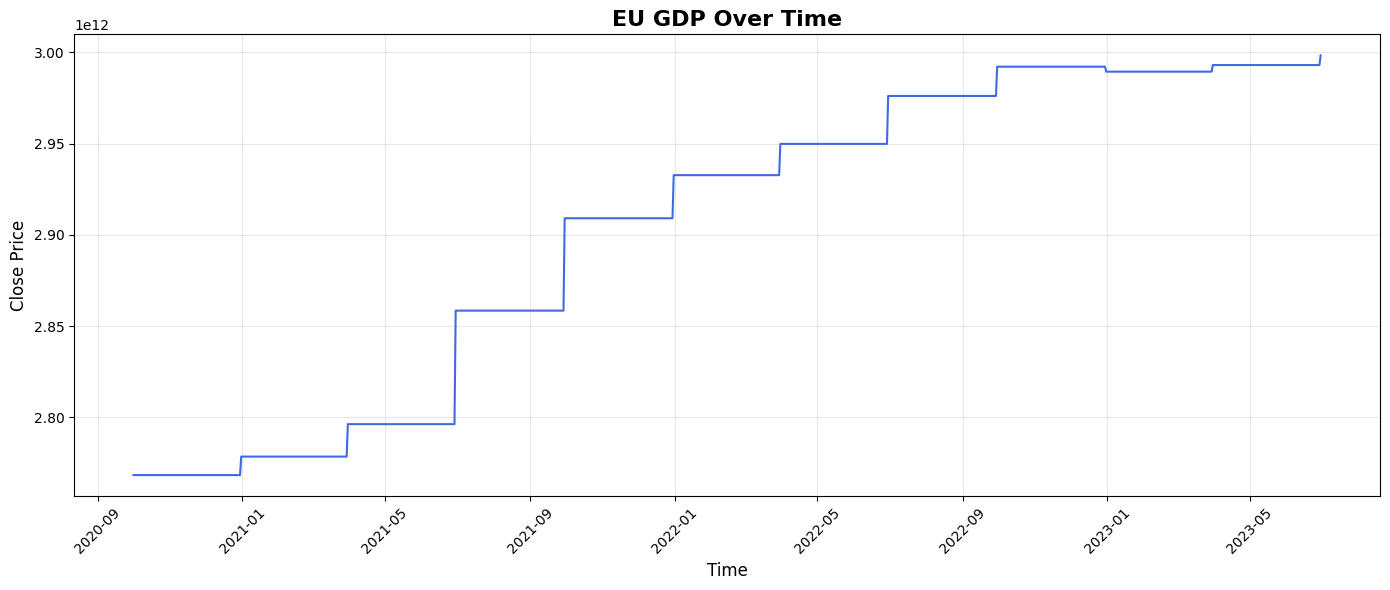

In [391]:
plt.figure(figsize=(14,6))
plt.plot(df_sliver['time'], df_sliver['close'], color='royalblue', linewidth=1.5)

# thêm title, grid, label
plt.title("EU GDP Over Time", fontsize=16, fontweight='bold')
plt.xlabel("Time", fontsize=12)
plt.ylabel("Close Price", fontsize=12)
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [392]:
# Tạo thư mục đích nếu chưa có
sliver_dir = os.path.join(project_dir, "data/sliver/macro_economic_data/growth_and_inflation")
os.makedirs(sliver_dir, exist_ok=True)

# Ghép path cho file xuất ra
output_path = os.path.join(sliver_dir, "ECONOMICS_EUGDPCP_1D.csv")

# Xuất df_sliver ra CSV
df_sliver.to_csv(output_path, index=False)

print(f"Đã lưu file tại: {output_path}")

Đã lưu file tại: d:\Git\ToanMoHinh\tmh2025-vong2\data/sliver/macro_economic_data/growth_and_inflation\ECONOMICS_EUGDPCP_1D.csv


---

### 1.6 US GDP

In [393]:
base_dir = os.getcwd()   # ví dụ .../project/notebooks

# Nhảy lên 1 cấp để tới project/
project_dir = os.path.dirname(base_dir)

# Ghép tới thư mục data
data_dir = os.path.join(project_dir, r"data\bronze\macro_economic_data\growth_and_inflation")

# Ghép tới file CSV
file_path = os.path.join(data_dir, "ECONOMICS_USGDPCP_1D.csv")

df = pd.read_csv(file_path)
df.head()

,time,close,Volume
0,1950-03-31,2.346104e+12,NaN
1,1950-06-30,2.417682e+12,NaN
2,1950-09-30,2.511127e+12,NaN
3,1950-12-31,2.559214e+12,NaN
4,1951-03-31,2.593967e+12,NaN


In [394]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 302 entries, 0 to 301
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    302 non-null    object 
 1   close   302 non-null    float64
 2   Volume  0 non-null      float64
dtypes: float64(2), object(1)
memory usage: 7.2+ KB


In [395]:
# Chọn cột cần thiết
df_sliver = df[["time", "close"]].copy()
df_sliver['time'] = pd.to_datetime(df_sliver['time'])

# Lọc trong khoảng
df_sliver = df_sliver[(df_sliver['time'] >= start_day) & (df_sliver['time'] <= end_day)]

# Đặt index
df_sliver = df_sliver.set_index("time")

# Reindex với full calendar
full_index = pd.date_range(start=start_day, end=end_day, freq="D")
df_sliver = df_sliver.reindex(full_index)

# --- Fix giá trị cho ngày start_day ---
# Lấy dữ liệu ngày trước start_day
prev_row = df[df['time'] < start_day].sort_values(by="time").iloc[-1]
df_sliver.loc[pd.to_datetime(start_day), ["close"]] = [prev_row["close"]]

# Ffill cho các ngày còn lại (02/07 trở đi)
df_sliver = df_sliver.ffill()

# Reset index
df_sliver.index.name = "time"
df_sliver = df_sliver.reset_index()

df_sliver.sort_values(by='time', inplace=True)
display(df_sliver.head())
display(df_sliver.tail())

,time,close
0,2020-10-01,2.051178e+13
1,2020-10-02,2.051178e+13
2,2020-10-03,2.051178e+13
3,2020-10-04,2.051178e+13
4,2020-10-05,2.051178e+13


,time,close
998,2023-06-26,2.211230e+13
999,2023-06-27,2.211230e+13
1000,2023-06-28,2.211230e+13
1001,2023-06-29,2.211230e+13
1002,2023-06-30,2.222540e+13


In [396]:
df_sliver.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1003 entries, 0 to 1002
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    1003 non-null   datetime64[ns]
 1   close   1003 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 15.8 KB


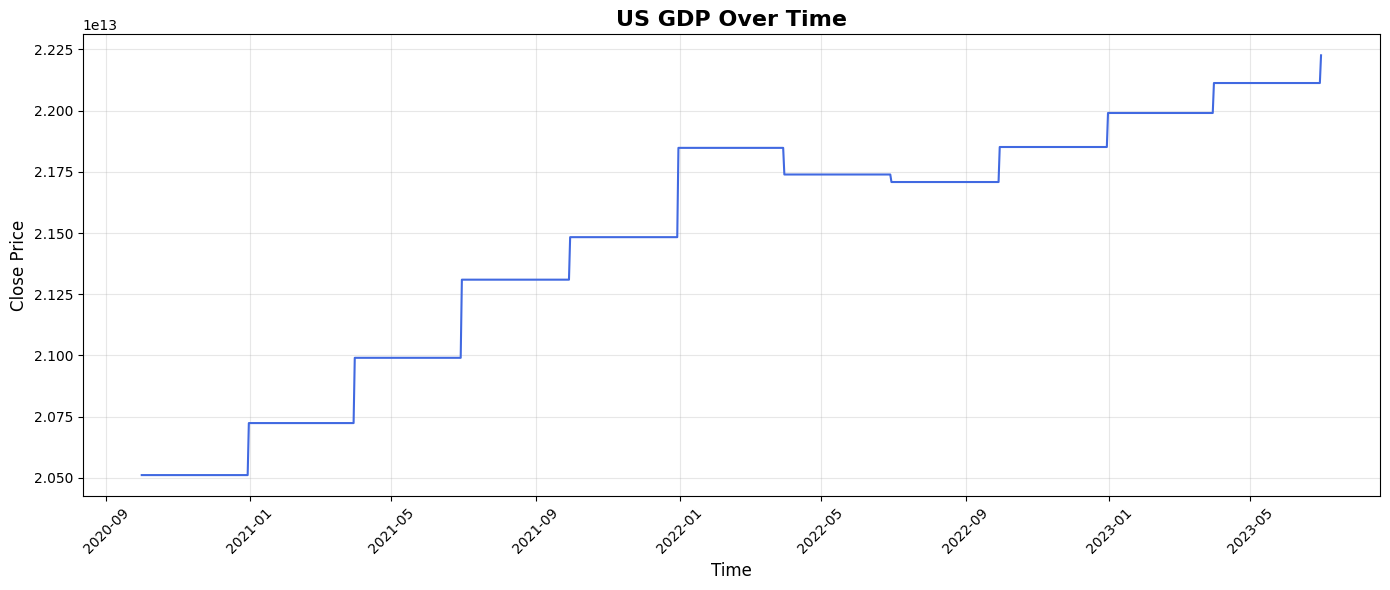

In [397]:
plt.figure(figsize=(14,6))
plt.plot(df_sliver['time'], df_sliver['close'], color='royalblue', linewidth=1.5)

# thêm title, grid, label
plt.title("US GDP Over Time", fontsize=16, fontweight='bold')
plt.xlabel("Time", fontsize=12)
plt.ylabel("Close Price", fontsize=12)
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [398]:
# Tạo thư mục đích nếu chưa có
sliver_dir = os.path.join(project_dir, "data/sliver/macro_economic_data/growth_and_inflation")
os.makedirs(sliver_dir, exist_ok=True)

# Ghép path cho file xuất ra
output_path = os.path.join(sliver_dir, "ECONOMICS_USGDPCP_1D.csv")

# Xuất df_sliver ra CSV
df_sliver.to_csv(output_path, index=False)

print(f"Đã lưu file tại: {output_path}")

Đã lưu file tại: d:\Git\ToanMoHinh\tmh2025-vong2\data/sliver/macro_economic_data/growth_and_inflation\ECONOMICS_USGDPCP_1D.csv


## 2. POLICY INTEREST RATE

### 2.1 ECB INTEREST RATE

In [399]:
base_dir = os.getcwd()   # ví dụ .../project/notebooks

# Nhảy lên 1 cấp để tới project/
project_dir = os.path.dirname(base_dir)

# Ghép tới thư mục data
data_dir = os.path.join(project_dir, r"data\bronze\macro_economic_data\policy_interest_rate")

# Ghép tới file CSV
file_path = os.path.join(data_dir, "ECB_INTEREST_RATE_FRED.csv")

df = pd.read_csv(file_path)
df.head()

,observation_date,ECBMRRFR
0,1999-01-01,3.0
1,1999-01-02,3.0
2,1999-01-03,3.0
3,1999-01-04,3.0
4,1999-01-05,3.0


In [400]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9724 entries, 0 to 9723
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   observation_date  9724 non-null   object 
 1   ECBMRRFR          6693 non-null   float64
dtypes: float64(1), object(1)
memory usage: 152.1+ KB


In [401]:
df_sliver = df[["observation_date", "ECBMRRFR"]].copy()
df_sliver = df_sliver.rename(columns={"observation_date": "time", "ECBMRRFR": "close"})

# đảm bảo time là datetime
df_sliver['time'] = pd.to_datetime(df_sliver['time'])

df_sliver = df_sliver[(df_sliver['time'] >= start_day) & (df_sliver['time'] <= end_day)]  # lọc dữ liệu từ 2020-07-01 đến 2023-06-30

# Tạo index đầy đủ các ngày trong khoảng
full_index = pd.date_range(start=start_day, end=end_day, freq='D')

# Đặt cột time làm index
df_sliver = df_sliver.set_index('time')

# Reindex theo full_index, điền giá trị bằng ffill
df_sliver = df_sliver.reindex(full_index).ffill()

# Đặt lại tên index thành time (nếu muốn giữ cột)
df_sliver.index.name = 'time'
df_sliver = df_sliver.reset_index()

df_sliver.sort_values(by='time', inplace=True)
display(df_sliver.head())
display(df_sliver.tail())

,time,close
0,2020-10-01,0.0
1,2020-10-02,0.0
2,2020-10-03,0.0
3,2020-10-04,0.0
4,2020-10-05,0.0


,time,close
998,2023-06-26,4.0
999,2023-06-27,4.0
1000,2023-06-28,4.0
1001,2023-06-29,4.0
1002,2023-06-30,4.0


In [402]:
df_sliver.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1003 entries, 0 to 1002
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    1003 non-null   datetime64[ns]
 1   close   1003 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 15.8 KB


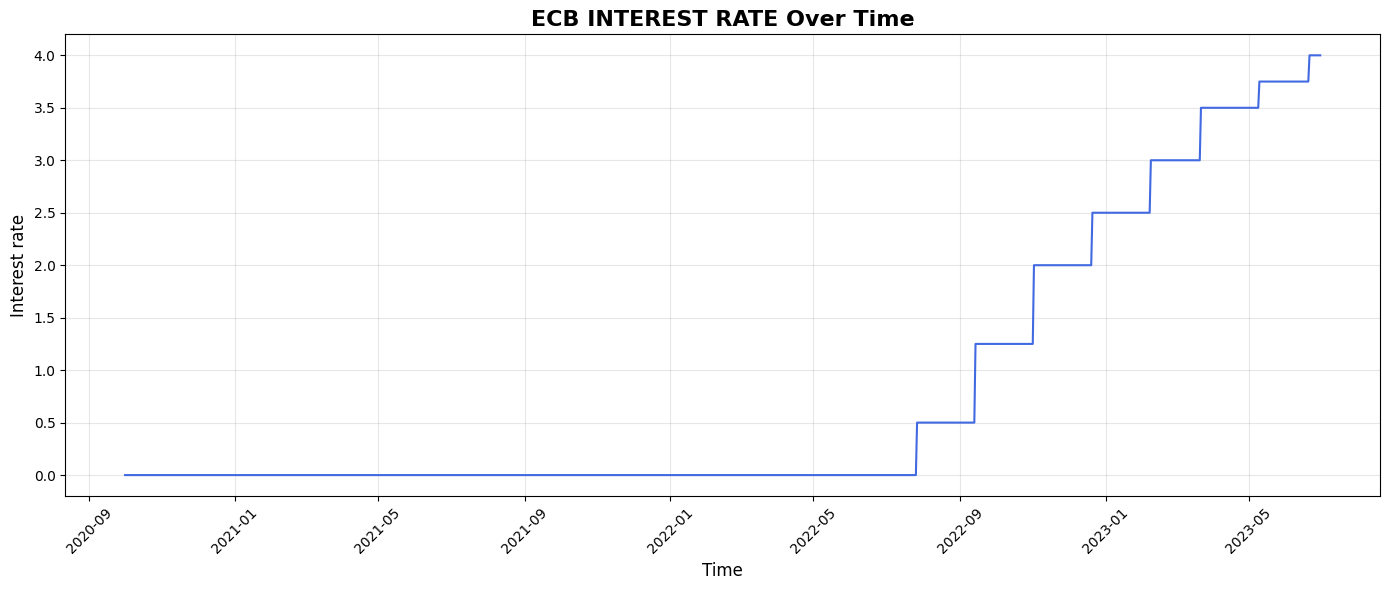

In [403]:
plt.figure(figsize=(14,6))
plt.plot(df_sliver['time'], df_sliver['close'], color='royalblue', linewidth=1.5)

# thêm title, grid, label
plt.title("ECB INTEREST RATE Over Time", fontsize=16, fontweight='bold')
plt.xlabel("Time", fontsize=12)
plt.ylabel("Interest rate", fontsize=12)
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [404]:
# Tạo thư mục đích nếu chưa có
sliver_dir = os.path.join(project_dir, "data/sliver/macro_economic_data/policy_interest_rate")
os.makedirs(sliver_dir, exist_ok=True)

# Ghép path cho file xuất ra
output_path = os.path.join(sliver_dir, "ECB_INTEREST_RATE_FRED.csv")

# Xuất df_sliver ra CSV
df_sliver.to_csv(output_path, index=False)

print(f"Đã lưu file tại: {output_path}")

Đã lưu file tại: d:\Git\ToanMoHinh\tmh2025-vong2\data/sliver/macro_economic_data/policy_interest_rate\ECB_INTEREST_RATE_FRED.csv


---

### 2.1 FED FUNDS INTEREST RATE

In [405]:
base_dir = os.getcwd()   # ví dụ .../project/notebooks

# Nhảy lên 1 cấp để tới project/
project_dir = os.path.dirname(base_dir)

# Ghép tới thư mục data
data_dir = os.path.join(project_dir, r"data\bronze\macro_economic_data\policy_interest_rate")

# Ghép tới file CSV
file_path = os.path.join(data_dir, "FED_FUNDS.csv")

df = pd.read_csv(file_path)
df.head()

,observation_date,FEDFUNDS
0,1954-07-01,0.80
1,1954-08-01,1.22
2,1954-09-01,1.07
3,1954-10-01,0.85
4,1954-11-01,0.83


In [406]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 853 entries, 0 to 852
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   observation_date  853 non-null    object 
 1   FEDFUNDS          853 non-null    float64
dtypes: float64(1), object(1)
memory usage: 13.5+ KB


In [407]:
df_sliver = df[["observation_date", "FEDFUNDS"]].copy()
df_sliver = df_sliver.rename(columns={"observation_date": "time", "FEDFUNDS": "close"})

# đảm bảo time là datetime
df_sliver['time'] = pd.to_datetime(df_sliver['time'])

df_sliver = df_sliver[(df_sliver['time'] >= start_day) & (df_sliver['time'] <= end_day)]  # lọc dữ liệu từ 2020-07-01 đến 2023-06-30

# Tạo index đầy đủ các ngày trong khoảng
full_index = pd.date_range(start=start_day, end=end_day, freq='D')

# Đặt cột time làm index
df_sliver = df_sliver.set_index('time')

# Reindex theo full_index, điền giá trị bằng ffill
df_sliver = df_sliver.reindex(full_index).ffill()

# Đặt lại tên index thành time (nếu muốn giữ cột)
df_sliver.index.name = 'time'
df_sliver = df_sliver.reset_index()

df_sliver.sort_values(by='time', inplace=True)
display(df_sliver.head())
display(df_sliver.tail())

,time,close
0,2020-10-01,0.09
1,2020-10-02,0.09
2,2020-10-03,0.09
3,2020-10-04,0.09
4,2020-10-05,0.09


,time,close
998,2023-06-26,5.08
999,2023-06-27,5.08
1000,2023-06-28,5.08
1001,2023-06-29,5.08
1002,2023-06-30,5.08


In [408]:
df_sliver.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1003 entries, 0 to 1002
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    1003 non-null   datetime64[ns]
 1   close   1003 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 15.8 KB


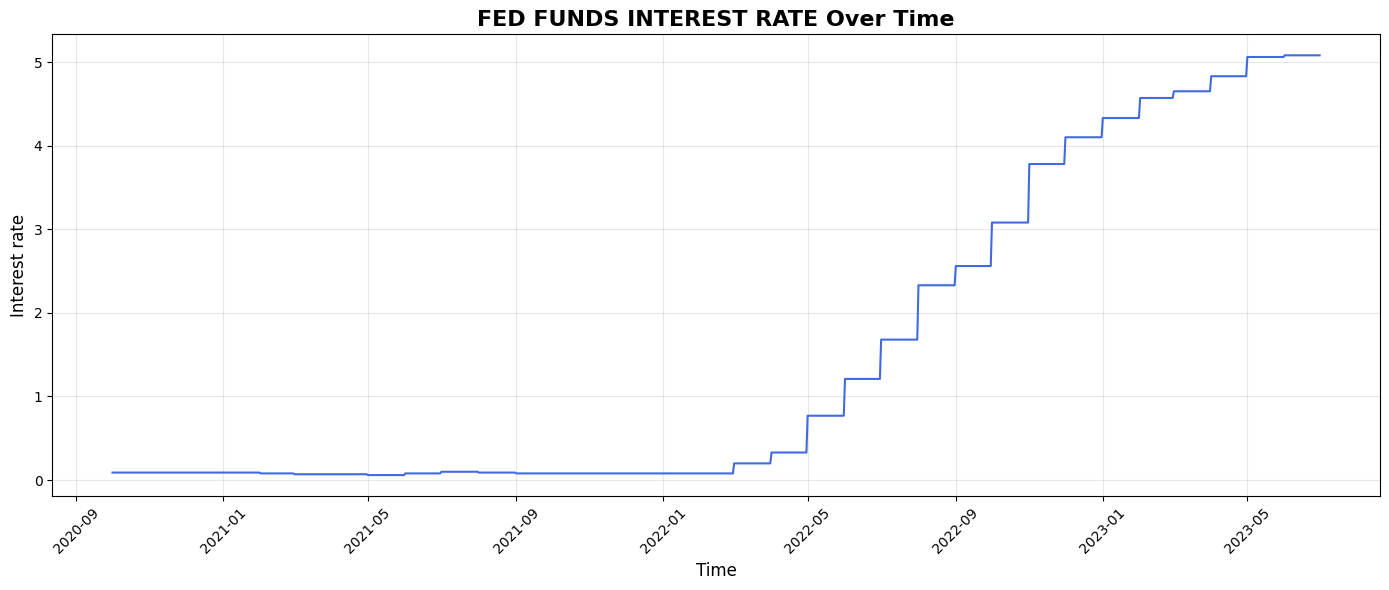

In [409]:
plt.figure(figsize=(14,6))
plt.plot(df_sliver['time'], df_sliver['close'], color='royalblue', linewidth=1.5)

# thêm title, grid, label
plt.title("FED FUNDS INTEREST RATE Over Time", fontsize=16, fontweight='bold')
plt.xlabel("Time", fontsize=12)
plt.ylabel("Interest rate", fontsize=12)
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [410]:
# Tạo thư mục đích nếu chưa có
sliver_dir = os.path.join(project_dir, "data/sliver/macro_economic_data/policy_interest_rate")
os.makedirs(sliver_dir, exist_ok=True)

# Ghép path cho file xuất ra
output_path = os.path.join(sliver_dir, "FED_FUNDS.csv")

# Xuất df_sliver ra CSV
df_sliver.to_csv(output_path, index=False)

print(f"Đã lưu file tại: {output_path}")

Đã lưu file tại: d:\Git\ToanMoHinh\tmh2025-vong2\data/sliver/macro_economic_data/policy_interest_rate\FED_FUNDS.csv


# C. INTERNAL DATA

In [411]:
base_dir = os.getcwd()   # ví dụ .../project/notebooks

# Nhảy lên 1 cấp để tới project/
project_dir = os.path.dirname(base_dir)

# Ghép tới thư mục data
data_dir = os.path.join(project_dir, "data/bronze/market_data")

# Ghép tới file CSV
file_path = os.path.join(data_dir, "PRICE_CS_1D.csv")

df = pd.read_csv(file_path)
df.head()

,time,open,high,low,close,Volume
0,1995-09-28,22.940465,22.940465,22.696417,22.940465,7887.808782
1,1995-09-29,22.696417,23.184512,22.696417,22.696417,4917.075604
2,1995-10-03,23.062489,23.062489,23.062489,23.062489,2151.220577
3,1995-10-04,23.062489,23.062489,23.062489,23.062489,4200.002079
4,1995-10-05,23.184512,23.184512,23.184512,23.184512,204.878150


In [412]:
base_dir = os.getcwd()

# Nhảy lên 1 cấp để tới project/
project_dir = os.path.dirname(base_dir)

# Ghép tới thư mục data
data_dir = os.path.join(project_dir, r"data/bronze/internal_data")

# Ghép tới file Excel
file_path = os.path.join(data_dir, "Internal_Data_FinancialReport.xlsx")
df = pd.read_excel(file_path, sheet_name="Sheet1")  # đọc đúng sheet


# Đặt cột đầu tiên làm chỉ mục (index)
df = df.set_index('Chỉ số')

# Sử dụng hàm transpose để chuyển vị DataFrame
df_transposed = df.transpose()

# In ra 5 dòng đầu tiên của DataFrame đã chuyển vị
display(df_transposed.head())

Chỉ số,Provision for credit losses,Non-accrual loans / Gross loans,Gross impaired loans / Gross loans,Allowance for credit losses / Gross loans,Loan-to-Deposit Ratio (LDR),Liquidity Coverage Ratio (LCR),CET1 ratio,Tier 1 leverage ratio,Cost/income ratio,Return on Equity (ROE)
3Q20,94.0,0.008,0.012,0.006,0.76,1.90,0.130,0.063,0.827,0.048
4Q20,138.0,0.007,0.011,0.005,0.75,1.90,0.129,0.064,0.990,-0.032
1Q21,4394.0,0.007,0.011,0.005,0.76,2.05,0.122,0.055,0.520,-0.023
2Q21,-25.0,0.008,0.011,0.005,0.76,2.16,0.137,0.060,0.846,0.023
3Q21,-144.0,0.007,0.010,0.005,0.75,2.21,0.144,0.061,0.841,0.040


In [413]:
df_transposed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11 entries, 3Q20 to 1Q23
Data columns (total 10 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Provision for credit losses                11 non-null     float64
 1   Non-accrual loans / Gross loans            9 non-null      float64
 2   Gross impaired loans / Gross loans         9 non-null      float64
 3   Allowance for credit losses / Gross loans  9 non-null      float64
 4   Loan-to-Deposit Ratio (LDR)                11 non-null     float64
 5   Liquidity Coverage Ratio (LCR)             11 non-null     float64
 6   CET1 ratio                                 11 non-null     float64
 7   Tier 1 leverage ratio                      11 non-null     float64
 8   Cost/income ratio                          11 non-null     float64
 9   Return on Equity (ROE)                     11 non-null     float64
dtypes: float64(10)
memory usage:

## 1. Giải thích phương pháp xử lý độ trễ trong dữ liệu Báo cáo tài chính (BCTC)

### Financial Report Alignment Note

- **Bối cảnh**: Trong mô hình dự báo chuỗi thời gian hàng ngày, các chỉ số tài chính từ **Báo cáo Tài chính (BCTC)** thường chỉ có dữ liệu **theo quý**. Thách thức là các báo cáo này luôn có **độ trễ công bố** so với kỳ mà chúng phản ánh.  
- **Nguyên tắc**: Nhà đầu tư và thị trường chỉ có thể phản ứng với thông tin **sau khi được công bố chính thức**. Ví dụ: BCTC Quý 3 (01/07 → 30/09) thường được công bố vào tháng 10, nên trong suốt Quý 3, thị trường chưa hề biết thông tin này.  
- **Phương pháp áp dụng (Forward-shift)**:  
  - Dữ liệu từ **Quý N** sẽ được dịch chuyển và gán cho **Quý N+1**.  
  - Ví dụ: BCTC Quý 3/2024 công bố tháng 10/2024 → sử dụng cho Quý 4/2024 (01/10 → 31/12).  
- **Lý do lựa chọn**:  
  - Tránh **Lookahead Bias** (mô hình nhìn trước tương lai), đảm bảo không dùng thông tin chưa tồn tại để dự báo.  
  - **Mô phỏng thực tế**: phản ánh đúng cách thông tin tài chính được công bố và tác động lên hành vi thị trường.  
- → Kết quả: dữ liệu sau xử lý vừa tuân thủ logic thời gian, vừa phù hợp với hành vi thông tin trong thực tế, giúp mô hình có tính **nhân quả và đáng tin cậy**.  

In [414]:
# Tạo một bản sao để thao tác
df = df_transposed.copy()

# Chuyển toàn bộ index về dạng chuỗi (string)
# Thao tác này sẽ đảm bảo các giá trị như '3Q20' được xử lý đúng cách
df.index = df.index.astype(str)
# --------------------

# --- 2. Chuyển đổi Index từ dạng chuỗi ('3Q20') sang dạng ngày tháng ---
# Tạo một hàm để chuyển đổi
def convert_quarter_to_start_date(q_str):
    """
    Chuyển đổi chuỗi như '3Q20' thành ngày bắt đầu của quý TIẾP THEO.
    Ví dụ: '3Q20' -> '2020-10-01' (Dữ liệu Q3 có hiệu lực cho Q4)
    """
    # Hàm này giữ nguyên, không cần thay đổi
    if isinstance(q_str, str) and 'Q' in q_str:
        try:
            parts = q_str.split('Q')
            quarter = int(parts[0])
            year_str = parts[1].strip() # Thêm .strip() để loại bỏ khoảng trắng thừa
            
            # Xử lý năm có 2 hoặc 4 chữ số
            if len(year_str) == 2:
                year = int('20' + year_str)
            else:
                year = int(year_str)
            
            if quarter == 1:
                return datetime(year, 4, 1) # Bắt đầu Q2
            elif quarter == 2:
                return datetime(year, 7, 1) # Bắt đầu Q3
            elif quarter == 3:
                return datetime(year, 10, 1) # Bắt đầu Q4
            elif quarter == 4:
                return datetime(year + 1, 1, 1) # Bắt đầu Q1 năm sau
        except (ValueError, IndexError):
            # Nếu có lỗi khi chuyển đổi, trả về None
            return None
    return None

# Áp dụng hàm trên vào index của DataFrame
df['valid_from_date'] = df.index.map(convert_quarter_to_start_date)

# Bỏ các dòng không chuyển đổi được (ví dụ: các index không đúng định dạng)
df = df.dropna(subset=['valid_from_date'])
df = df.set_index('valid_from_date')

# --- 3. Tạo DataFrame theo ngày và điền dữ liệu ---
# Định nghĩa khoảng thời gian bạn muốn
start_date = '2020-10-01'
end_date = '2023-06-30'

# Tạo một dải ngày liên tục từ ngày bắt đầu đến ngày kết thúc
daily_index = pd.date_range(start=start_date, end=end_date, freq='D')

# Dùng reindex để tạo DataFrame mới với dải ngày liên tục
# method='ffill' (forward fill) sẽ điền các giá trị trống bằng giá trị hợp lệ gần nhất trước đó
df_daily = df.reindex(daily_index, method='ffill')

# --- 4. Hiển thị kết quả ---
print("5 dòng đầu tiên của dữ liệu theo ngày:")
display(df_daily.head(5))
print("\n5 dòng cuối cùng của dữ liệu theo ngày:")
display(df_daily.tail(5))

5 dòng đầu tiên của dữ liệu theo ngày:


Chỉ số,Provision for credit losses,Non-accrual loans / Gross loans,Gross impaired loans / Gross loans,Allowance for credit losses / Gross loans,Loan-to-Deposit Ratio (LDR),Liquidity Coverage Ratio (LCR),CET1 ratio,Tier 1 leverage ratio,Cost/income ratio,Return on Equity (ROE)
2020-10-01,94.0,0.008,0.012,0.006,0.76,1.9,0.13,0.063,0.827,0.048
2020-10-02,94.0,0.008,0.012,0.006,0.76,1.9,0.13,0.063,0.827,0.048
2020-10-03,94.0,0.008,0.012,0.006,0.76,1.9,0.13,0.063,0.827,0.048
2020-10-04,94.0,0.008,0.012,0.006,0.76,1.9,0.13,0.063,0.827,0.048
2020-10-05,94.0,0.008,0.012,0.006,0.76,1.9,0.13,0.063,0.827,0.048



5 dòng cuối cùng của dữ liệu theo ngày:


Chỉ số,Provision for credit losses,Non-accrual loans / Gross loans,Gross impaired loans / Gross loans,Allowance for credit losses / Gross loans,Loan-to-Deposit Ratio (LDR),Liquidity Coverage Ratio (LCR),CET1 ratio,Tier 1 leverage ratio,Cost/income ratio,Return on Equity (ROE)
2023-06-26,83.0,NaN,NaN,NaN,1.58,1.78,0.203,0.076,0.304,1.094
2023-06-27,83.0,NaN,NaN,NaN,1.58,1.78,0.203,0.076,0.304,1.094
2023-06-28,83.0,NaN,NaN,NaN,1.58,1.78,0.203,0.076,0.304,1.094
2023-06-29,83.0,NaN,NaN,NaN,1.58,1.78,0.203,0.076,0.304,1.094
2023-06-30,83.0,NaN,NaN,NaN,1.58,1.78,0.203,0.076,0.304,1.094


In [415]:
df_daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1003 entries, 2020-10-01 to 2023-06-30
Freq: D
Data columns (total 10 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Provision for credit losses                1003 non-null   float64
 1   Non-accrual loans / Gross loans            822 non-null    float64
 2   Gross impaired loans / Gross loans         822 non-null    float64
 3   Allowance for credit losses / Gross loans  822 non-null    float64
 4   Loan-to-Deposit Ratio (LDR)                1003 non-null   float64
 5   Liquidity Coverage Ratio (LCR)             1003 non-null   float64
 6   CET1 ratio                                 1003 non-null   float64
 7   Tier 1 leverage ratio                      1003 non-null   float64
 8   Cost/income ratio                          1003 non-null   float64
 9   Return on Equity (ROE)                     1003 non-null   float64
dty

Dữ liệu có missing value ở 3 chỉ số `Non-accrual loans / Gross loans`, `Gross impaired loans / Gross loans`, `Allowance for credit losses / Gross loans` vào Q4/2022 và Q1/2023. Hiện tượng missing này do các chỉ số này không còn được công bố trong báo cáo tài chính 2 quý Q4/2022 và Q1/2023, nên ta sẽ dùng giá trị kì trước Q3/2022 để điền missing values.

In [416]:
# --- Xác định các cột cần xử lý ---
cols_to_fill = [
    'Non-accrual loans / Gross loans',
    'Gross impaired loans / Gross loans',
    'Allowance for credit losses / Gross loans'
]

# --- In ra số lượng missing value TRƯỚC khi xử lý ---
print("Số lượng giá trị thiếu TRƯỚC khi xử lý:")
print(df_daily[cols_to_fill].isnull().sum())


# --- Áp dụng phương pháp Forward Fill (ffill) ---
# ffill() sẽ lấy giá trị hợp lệ cuối cùng và điền vào tất cả các ô NaN phía sau nó
df_daily[cols_to_fill] = df_daily[cols_to_fill].ffill()


# --- Kiểm tra lại kết quả SAU khi xử lý ---
print("\nSố lượng giá trị thiếu SAU khi xử lý:")
print(df_daily[cols_to_fill].isnull().sum())

print("\nThông tin DataFrame sau khi đã điền giá trị thiếu:")
df_daily.info()

Số lượng giá trị thiếu TRƯỚC khi xử lý:
Chỉ số
Non-accrual loans / Gross loans              181
Gross impaired loans / Gross loans           181
Allowance for credit losses / Gross loans    181
dtype: int64

Số lượng giá trị thiếu SAU khi xử lý:
Chỉ số
Non-accrual loans / Gross loans              0
Gross impaired loans / Gross loans           0
Allowance for credit losses / Gross loans    0
dtype: int64

Thông tin DataFrame sau khi đã điền giá trị thiếu:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1003 entries, 2020-10-01 to 2023-06-30
Freq: D
Data columns (total 10 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Provision for credit losses                1003 non-null   float64
 1   Non-accrual loans / Gross loans            1003 non-null   float64
 2   Gross impaired loans / Gross loans         1003 non-null   float64
 3   Allowance for credit losses / Gross loans  

In [417]:
df_daily = df_daily.rename(columns={"Chỉ số": "time"})
df_daily.index.name = 'time'
df_daily = df_daily.reset_index()

In [418]:
df_daily.head()

Chỉ số,time,Provision for credit losses,Non-accrual loans / Gross loans,Gross impaired loans / Gross loans,Allowance for credit losses / Gross loans,Loan-to-Deposit Ratio (LDR),Liquidity Coverage Ratio (LCR),CET1 ratio,Tier 1 leverage ratio,Cost/income ratio,Return on Equity (ROE)
0,2020-10-01,94.0,0.008,0.012,0.006,0.76,1.9,0.13,0.063,0.827,0.048
1,2020-10-02,94.0,0.008,0.012,0.006,0.76,1.9,0.13,0.063,0.827,0.048
2,2020-10-03,94.0,0.008,0.012,0.006,0.76,1.9,0.13,0.063,0.827,0.048
3,2020-10-04,94.0,0.008,0.012,0.006,0.76,1.9,0.13,0.063,0.827,0.048
4,2020-10-05,94.0,0.008,0.012,0.006,0.76,1.9,0.13,0.063,0.827,0.048


In [419]:
df_daily.tail()

Chỉ số,time,Provision for credit losses,Non-accrual loans / Gross loans,Gross impaired loans / Gross loans,Allowance for credit losses / Gross loans,Loan-to-Deposit Ratio (LDR),Liquidity Coverage Ratio (LCR),CET1 ratio,Tier 1 leverage ratio,Cost/income ratio,Return on Equity (ROE)
998,2023-06-26,83.0,0.008,0.012,0.005,1.58,1.78,0.203,0.076,0.304,1.094
999,2023-06-27,83.0,0.008,0.012,0.005,1.58,1.78,0.203,0.076,0.304,1.094
1000,2023-06-28,83.0,0.008,0.012,0.005,1.58,1.78,0.203,0.076,0.304,1.094
1001,2023-06-29,83.0,0.008,0.012,0.005,1.58,1.78,0.203,0.076,0.304,1.094
1002,2023-06-30,83.0,0.008,0.012,0.005,1.58,1.78,0.203,0.076,0.304,1.094


In [420]:
# Tạo thư mục đích nếu chưa có
sliver_dir = os.path.join(project_dir, "data/sliver/internal_data")
os.makedirs(sliver_dir, exist_ok=True)

# Ghép path cho file xuất ra
output_path = os.path.join(sliver_dir, "Internal_Data_Financial_Report.csv")

# Xuất df_sliver ra CSV
df_daily.to_csv(output_path, index=False)

print(f"Đã lưu file tại: {output_path}")

Đã lưu file tại: d:\Git\ToanMoHinh\tmh2025-vong2\data/sliver/internal_data\Internal_Data_Financial_Report.csv


# D. G-SIBs DATA

Thư mục đầu vào: d:\Git\ToanMoHinh\tmh2025-vong2\data/bronze/G-SIB_Bank
Thư mục đầu ra: d:\Git\ToanMoHinh\tmh2025-vong2\data/sliver/G-SIB_Bank

Tìm thấy 29 file CSV để xử lý.

==================== Đang xử lý file: BATS_BAC-1D.csv ====================
Thông tin dữ liệu sau khi xử lý:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    1095 non-null   datetime64[ns]
 1   close   1095 non-null   float64       
 2   volume  1095 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 25.8 KB

5 dòng đầu:


,time,close,volume
0,2020-07-01,23.26,57379923.0
1,2020-07-02,23.29,56000150.0
2,2020-07-03,23.29,56000150.0
3,2020-07-04,23.29,56000150.0
4,2020-07-05,23.29,56000150.0


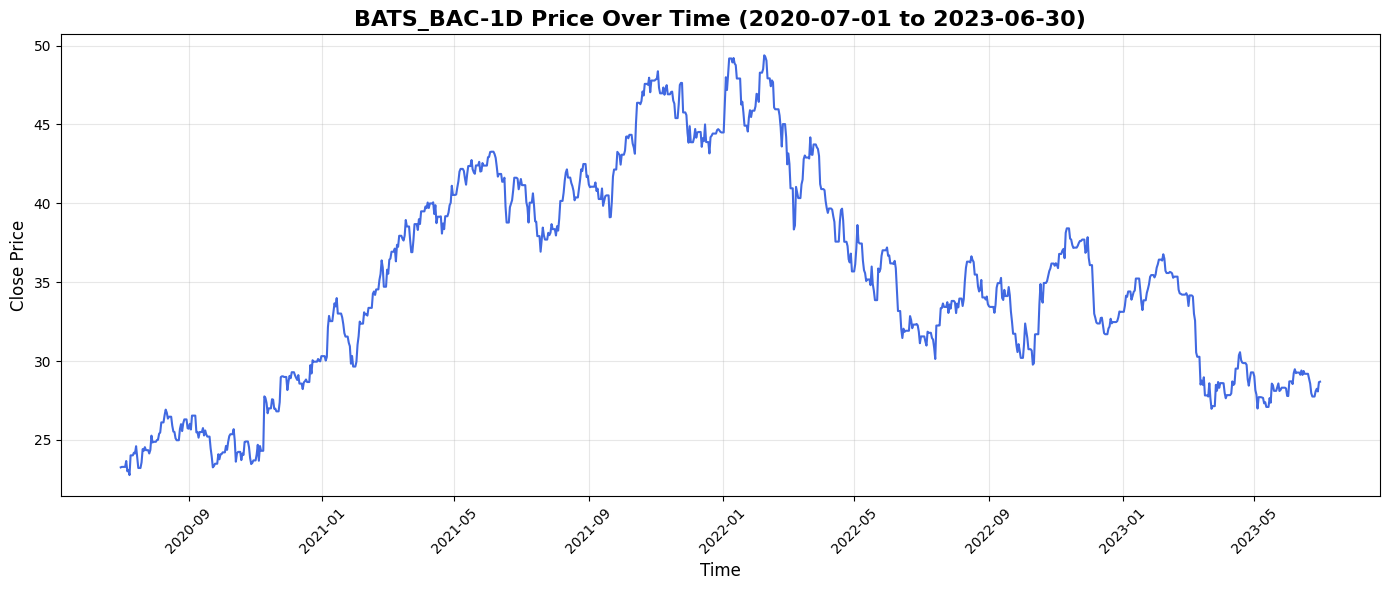

Đã lưu file đã xử lý tại: d:\Git\ToanMoHinh\tmh2025-vong2\data/sliver/G-SIB_Bank\BATS_BAC-1D.csv

==================== Đang xử lý file: BATS_BK-1D.csv ====================
Thông tin dữ liệu sau khi xử lý:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    1095 non-null   datetime64[ns]
 1   close   1095 non-null   float64       
 2   volume  1095 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 25.8 KB

5 dòng đầu:


,time,close,volume
0,2020-07-01,37.59,5923978.0
1,2020-07-02,37.94,4114591.0
2,2020-07-03,37.94,4114591.0
3,2020-07-04,37.94,4114591.0
4,2020-07-05,37.94,4114591.0


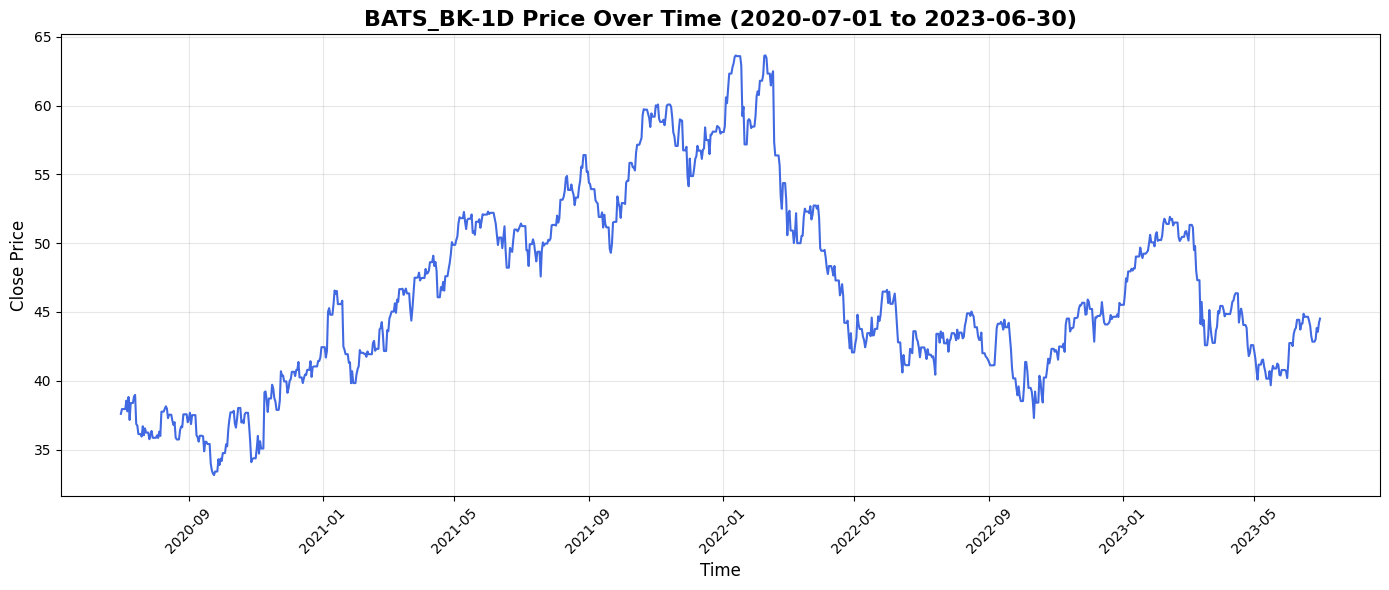

Đã lưu file đã xử lý tại: d:\Git\ToanMoHinh\tmh2025-vong2\data/sliver/G-SIB_Bank\BATS_BK-1D.csv

==================== Đang xử lý file: BATS_C-1D.csv ====================
Thông tin dữ liệu sau khi xử lý:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    1095 non-null   datetime64[ns]
 1   close   0 non-null      float64       
 2   volume  0 non-null      float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 25.8 KB

5 dòng đầu:


,time,close,volume
0,2020-07-01,NaN,NaN
1,2020-07-02,NaN,NaN
2,2020-07-03,NaN,NaN
3,2020-07-04,NaN,NaN
4,2020-07-05,NaN,NaN


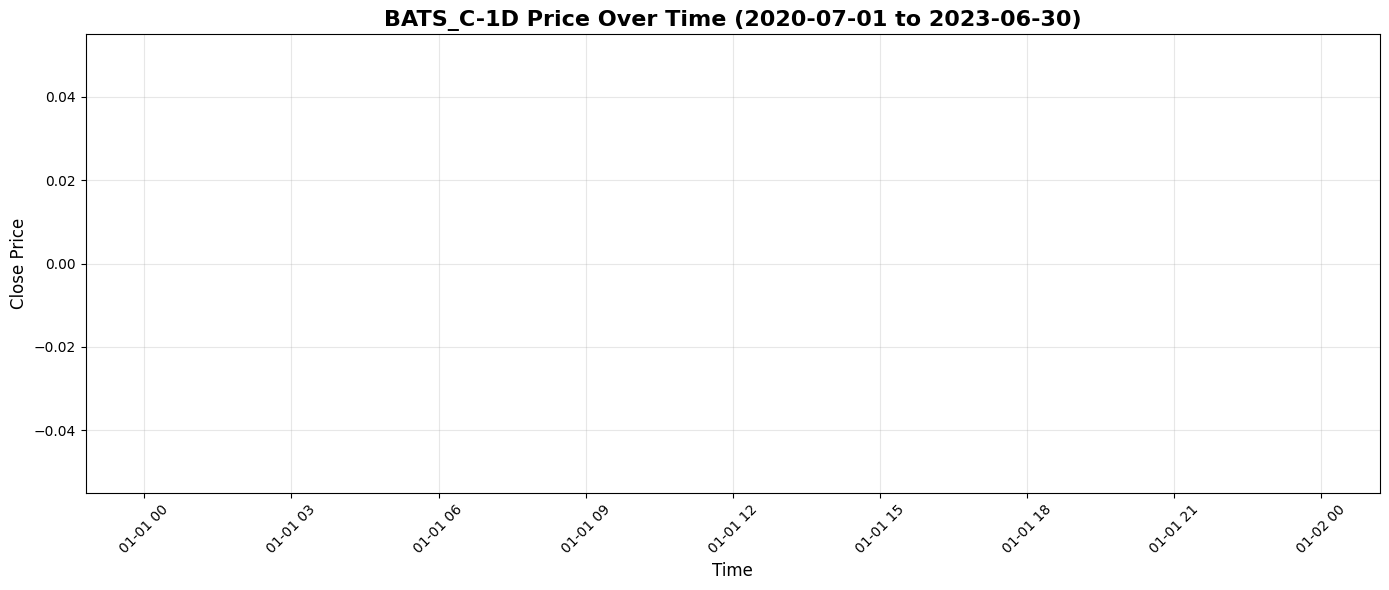

Đã lưu file đã xử lý tại: d:\Git\ToanMoHinh\tmh2025-vong2\data/sliver/G-SIB_Bank\BATS_C-1D.csv

==================== Đang xử lý file: BATS_CS-1D.csv ====================
Thông tin dữ liệu sau khi xử lý:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    1095 non-null   datetime64[ns]
 1   close   568 non-null    float64       
 2   volume  568 non-null    float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 25.8 KB

5 dòng đầu:


,time,close,volume
0,2020-07-01,NaN,NaN
1,2020-07-02,NaN,NaN
2,2020-07-03,NaN,NaN
3,2020-07-04,NaN,NaN
4,2020-07-05,NaN,NaN


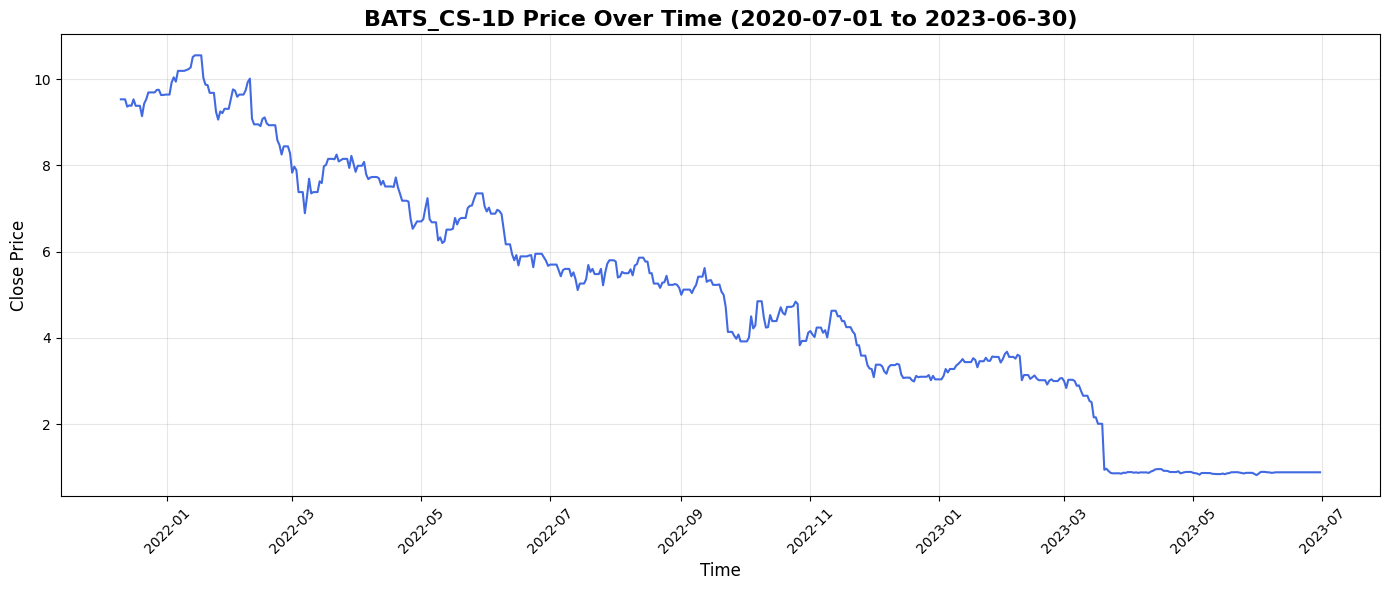

Đã lưu file đã xử lý tại: d:\Git\ToanMoHinh\tmh2025-vong2\data/sliver/G-SIB_Bank\BATS_CS-1D.csv

==================== Đang xử lý file: BATS_GS-1D.csv ====================
Thông tin dữ liệu sau khi xử lý:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    1095 non-null   datetime64[ns]
 1   close   0 non-null      float64       
 2   volume  0 non-null      float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 25.8 KB

5 dòng đầu:


,time,close,volume
0,2020-07-01,NaN,NaN
1,2020-07-02,NaN,NaN
2,2020-07-03,NaN,NaN
3,2020-07-04,NaN,NaN
4,2020-07-05,NaN,NaN


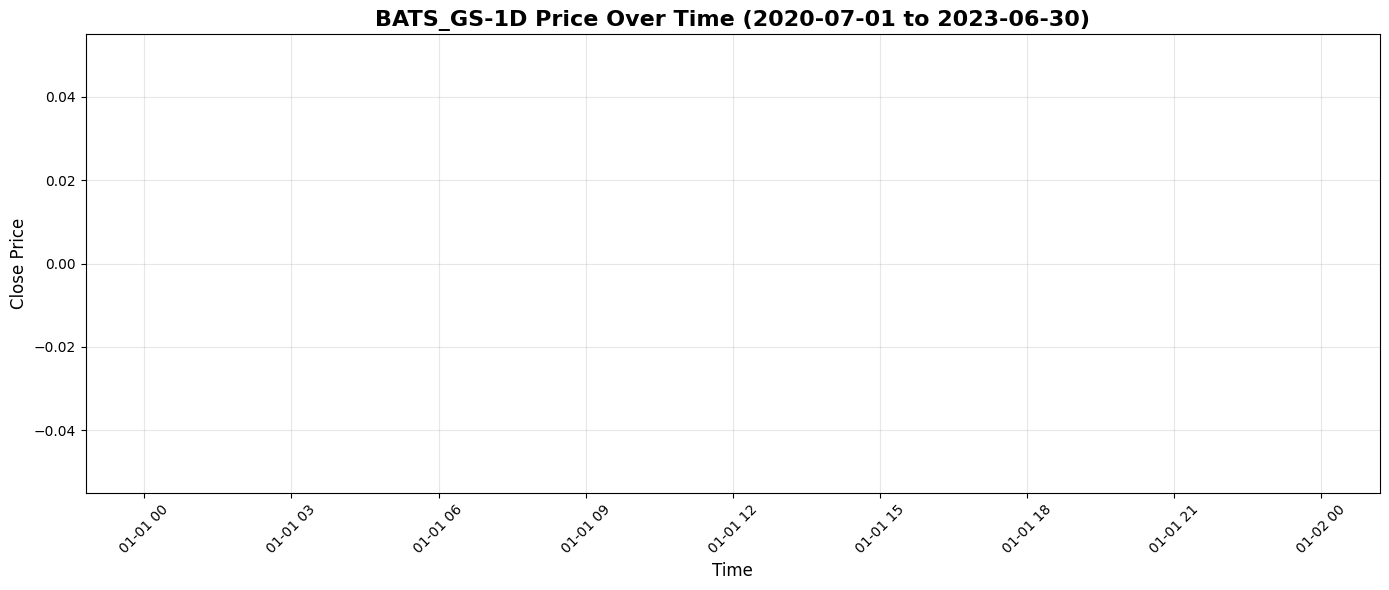

Đã lưu file đã xử lý tại: d:\Git\ToanMoHinh\tmh2025-vong2\data/sliver/G-SIB_Bank\BATS_GS-1D.csv

==================== Đang xử lý file: BATS_JPM-1D.csv ====================
Thông tin dữ liệu sau khi xử lý:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    1095 non-null   datetime64[ns]
 1   close   0 non-null      float64       
 2   volume  0 non-null      float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 25.8 KB

5 dòng đầu:


,time,close,volume
0,2020-07-01,NaN,NaN
1,2020-07-02,NaN,NaN
2,2020-07-03,NaN,NaN
3,2020-07-04,NaN,NaN
4,2020-07-05,NaN,NaN


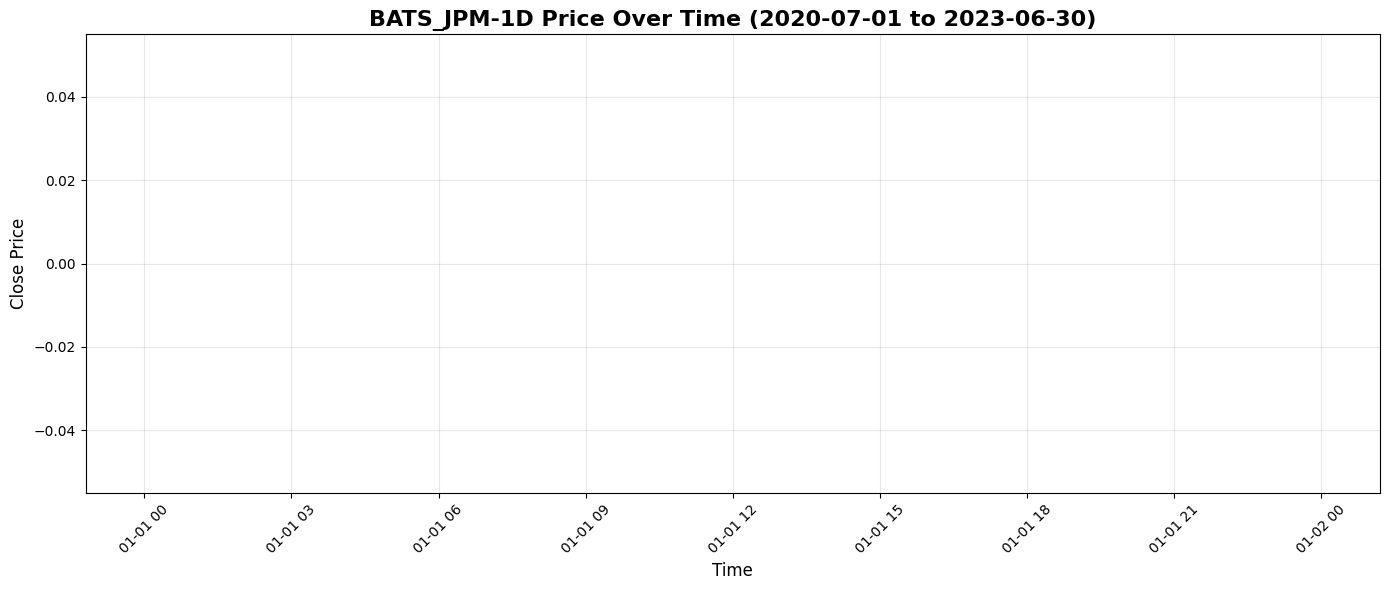

Đã lưu file đã xử lý tại: d:\Git\ToanMoHinh\tmh2025-vong2\data/sliver/G-SIB_Bank\BATS_JPM-1D.csv

==================== Đang xử lý file: BATS_MS-1D.csv ====================
Thông tin dữ liệu sau khi xử lý:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    1095 non-null   datetime64[ns]
 1   close   0 non-null      float64       
 2   volume  0 non-null      float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 25.8 KB

5 dòng đầu:


,time,close,volume
0,2020-07-01,NaN,NaN
1,2020-07-02,NaN,NaN
2,2020-07-03,NaN,NaN
3,2020-07-04,NaN,NaN
4,2020-07-05,NaN,NaN


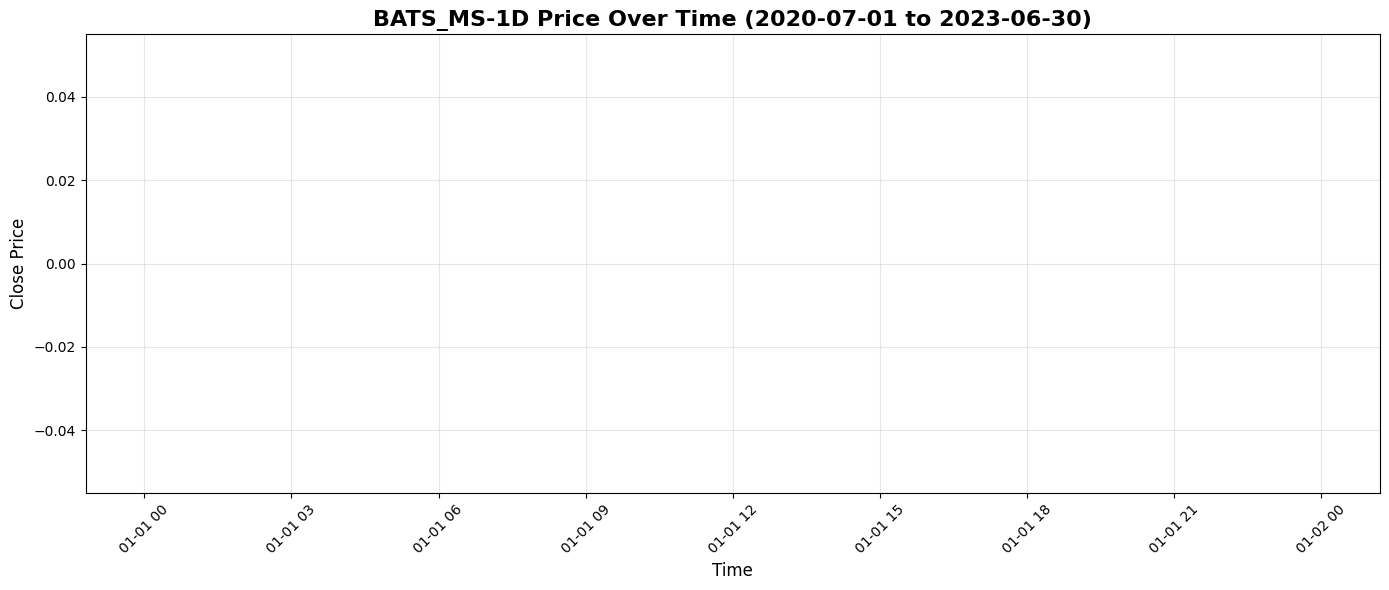

Đã lưu file đã xử lý tại: d:\Git\ToanMoHinh\tmh2025-vong2\data/sliver/G-SIB_Bank\BATS_MS-1D.csv

==================== Đang xử lý file: BATS_RY-1D.csv ====================
Thông tin dữ liệu sau khi xử lý:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    1095 non-null   datetime64[ns]
 1   close   0 non-null      float64       
 2   volume  0 non-null      float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 25.8 KB

5 dòng đầu:


,time,close,volume
0,2020-07-01,NaN,NaN
1,2020-07-02,NaN,NaN
2,2020-07-03,NaN,NaN
3,2020-07-04,NaN,NaN
4,2020-07-05,NaN,NaN


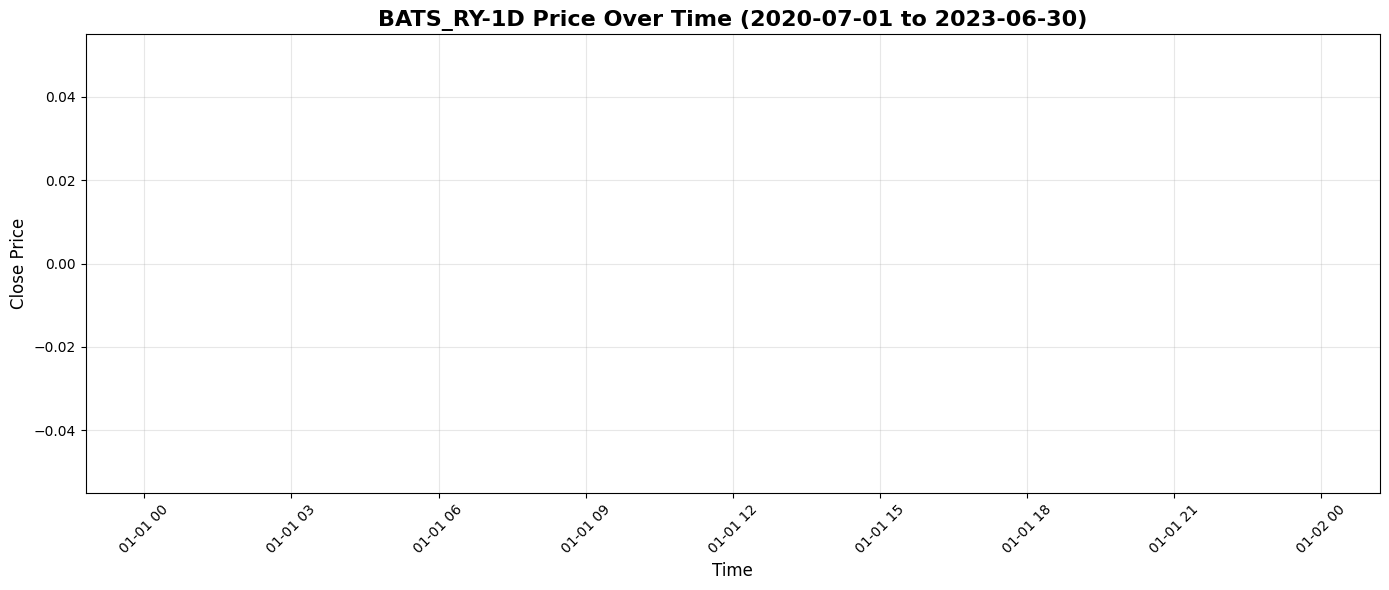

Đã lưu file đã xử lý tại: d:\Git\ToanMoHinh\tmh2025-vong2\data/sliver/G-SIB_Bank\BATS_RY-1D.csv

==================== Đang xử lý file: BATS_STT-1D.csv ====================
Thông tin dữ liệu sau khi xử lý:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    1095 non-null   datetime64[ns]
 1   close   0 non-null      float64       
 2   volume  0 non-null      float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 25.8 KB

5 dòng đầu:


,time,close,volume
0,2020-07-01,NaN,NaN
1,2020-07-02,NaN,NaN
2,2020-07-03,NaN,NaN
3,2020-07-04,NaN,NaN
4,2020-07-05,NaN,NaN


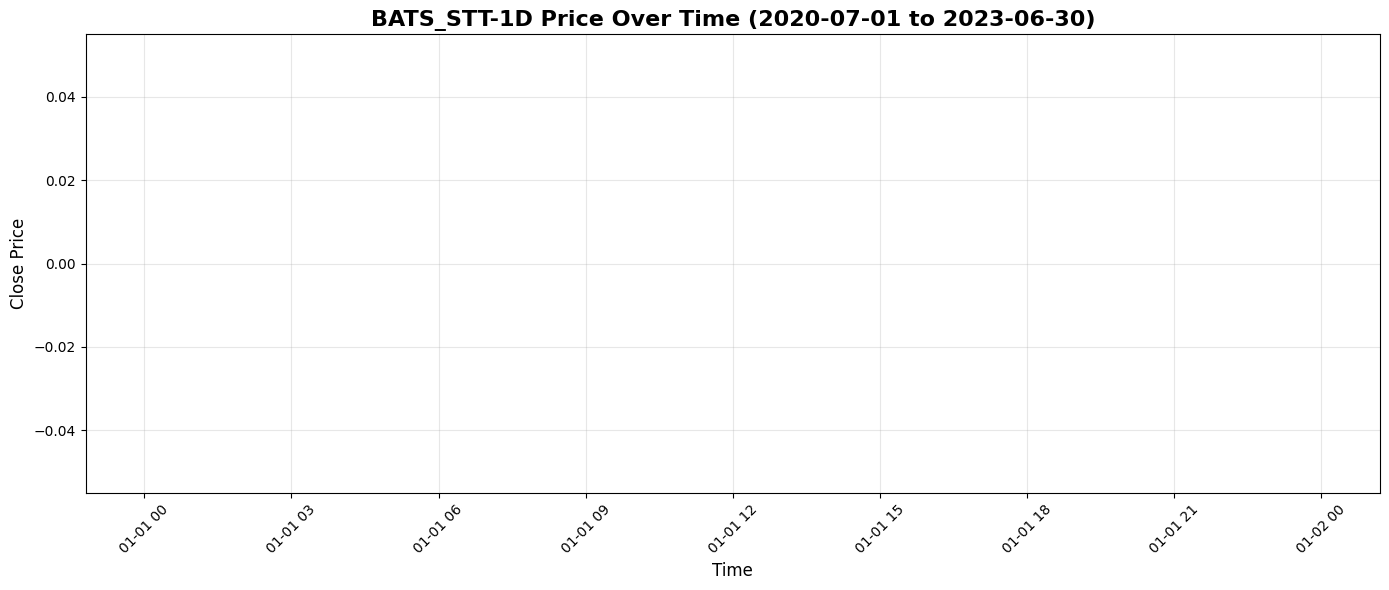

Đã lưu file đã xử lý tại: d:\Git\ToanMoHinh\tmh2025-vong2\data/sliver/G-SIB_Bank\BATS_STT-1D.csv

==================== Đang xử lý file: BATS_WFC-1D.csv ====================
Thông tin dữ liệu sau khi xử lý:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    1095 non-null   datetime64[ns]
 1   close   0 non-null      float64       
 2   volume  0 non-null      float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 25.8 KB

5 dòng đầu:


,time,close,volume
0,2020-07-01,NaN,NaN
1,2020-07-02,NaN,NaN
2,2020-07-03,NaN,NaN
3,2020-07-04,NaN,NaN
4,2020-07-05,NaN,NaN


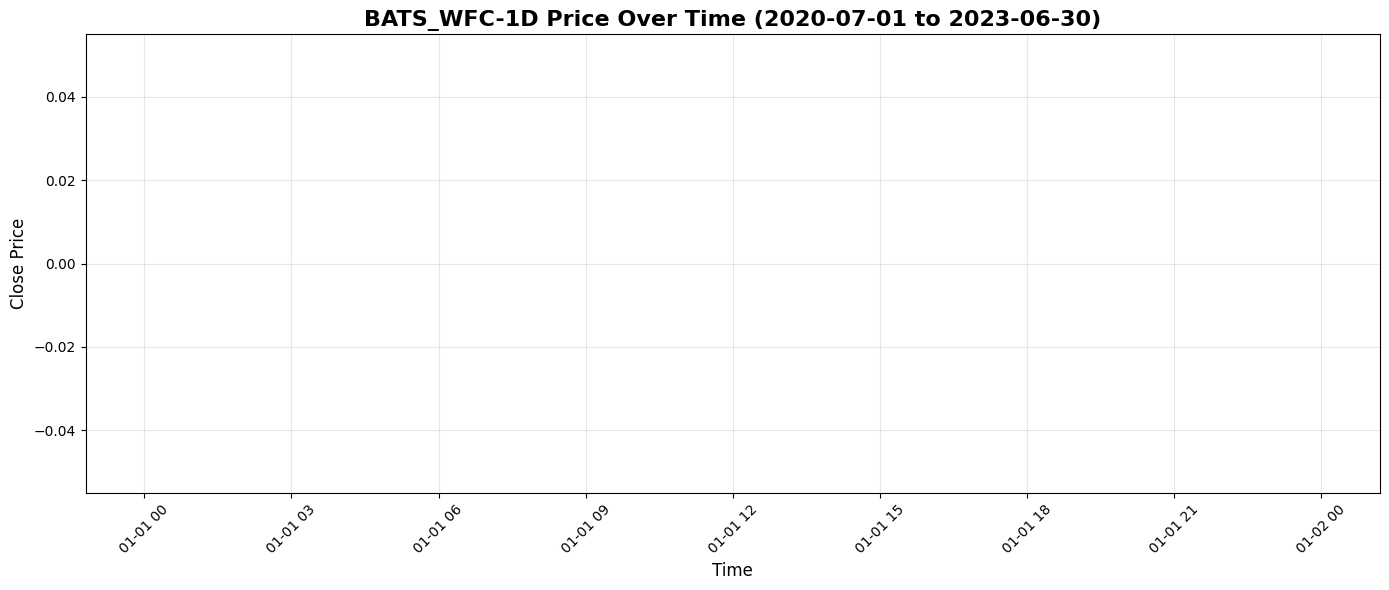

Đã lưu file đã xử lý tại: d:\Git\ToanMoHinh\tmh2025-vong2\data/sliver/G-SIB_Bank\BATS_WFC-1D.csv

==================== Đang xử lý file: BME_DLY_SAN-1D.csv ====================
Thông tin dữ liệu sau khi xử lý:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    1095 non-null   datetime64[ns]
 1   close   0 non-null      float64       
 2   volume  0 non-null      float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 25.8 KB

5 dòng đầu:


,time,close,volume
0,2020-07-01,NaN,NaN
1,2020-07-02,NaN,NaN
2,2020-07-03,NaN,NaN
3,2020-07-04,NaN,NaN
4,2020-07-05,NaN,NaN


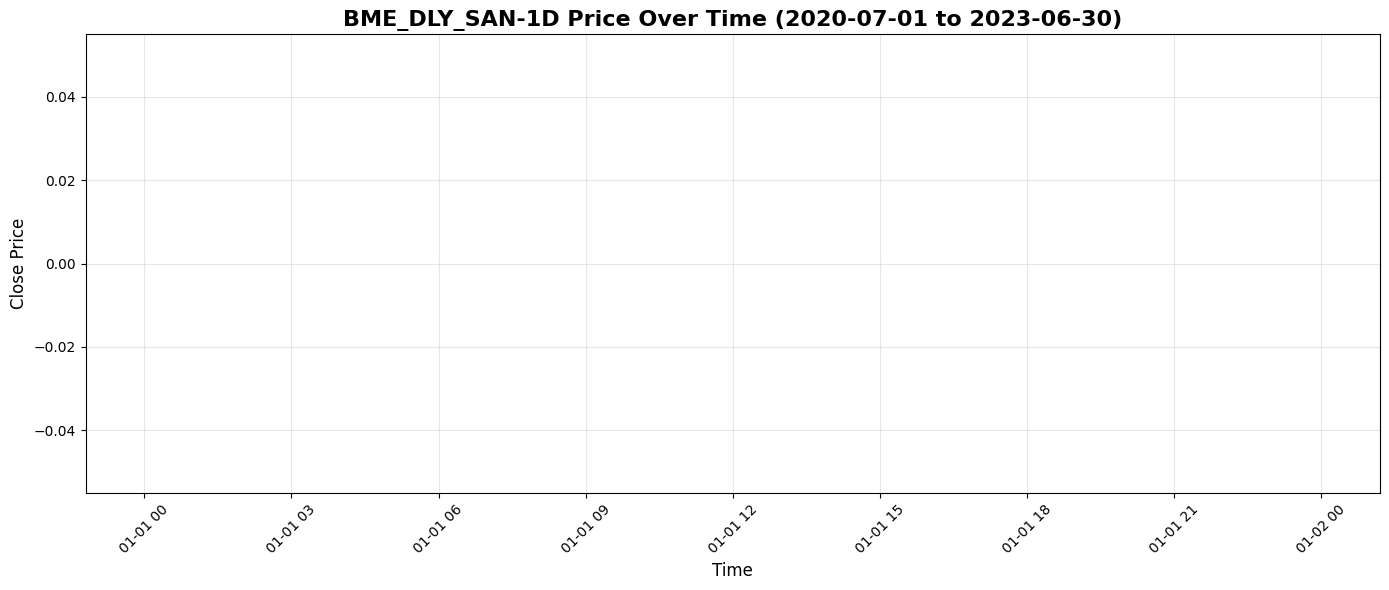

Đã lưu file đã xử lý tại: d:\Git\ToanMoHinh\tmh2025-vong2\data/sliver/G-SIB_Bank\BME_DLY_SAN-1D.csv

==================== Đang xử lý file: EURONEXT_DLY_ACA-1D.csv ====================
Thông tin dữ liệu sau khi xử lý:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    1095 non-null   datetime64[ns]
 1   close   0 non-null      float64       
 2   volume  0 non-null      float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 25.8 KB

5 dòng đầu:


,time,close,volume
0,2020-07-01,NaN,NaN
1,2020-07-02,NaN,NaN
2,2020-07-03,NaN,NaN
3,2020-07-04,NaN,NaN
4,2020-07-05,NaN,NaN


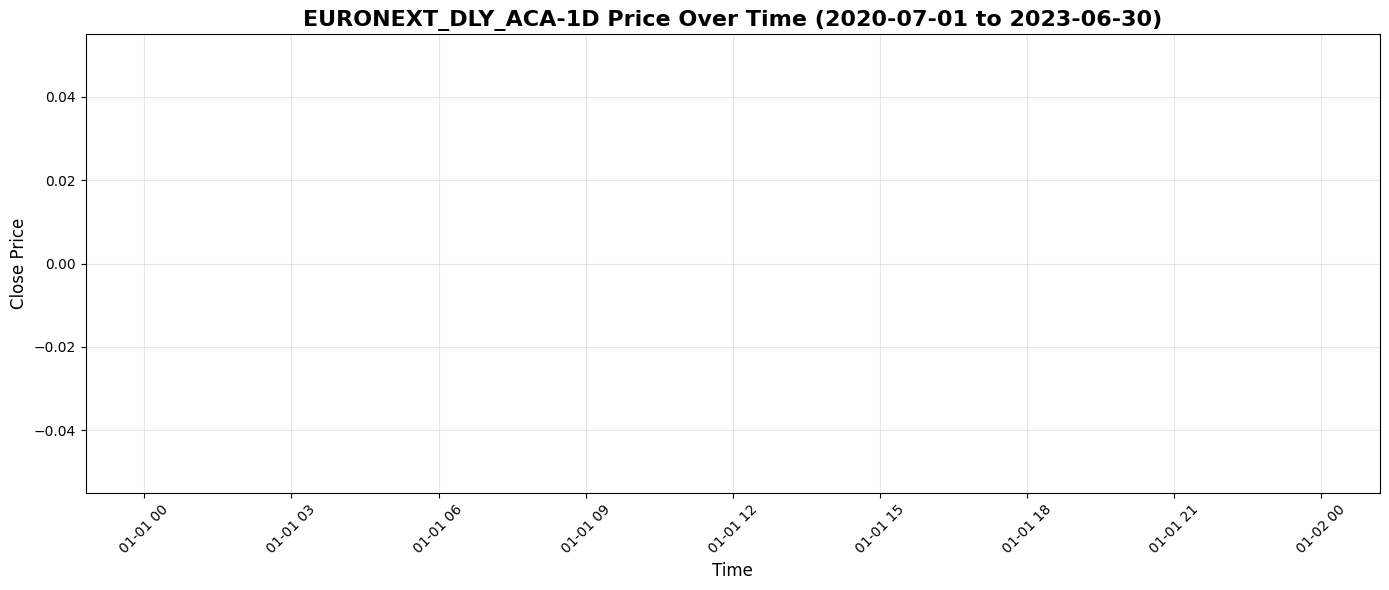

Đã lưu file đã xử lý tại: d:\Git\ToanMoHinh\tmh2025-vong2\data/sliver/G-SIB_Bank\EURONEXT_DLY_ACA-1D.csv

==================== Đang xử lý file: EURONEXT_DLY_BNP-1D.csv ====================
Thông tin dữ liệu sau khi xử lý:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    1095 non-null   datetime64[ns]
 1   close   0 non-null      float64       
 2   volume  0 non-null      float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 25.8 KB

5 dòng đầu:


,time,close,volume
0,2020-07-01,NaN,NaN
1,2020-07-02,NaN,NaN
2,2020-07-03,NaN,NaN
3,2020-07-04,NaN,NaN
4,2020-07-05,NaN,NaN


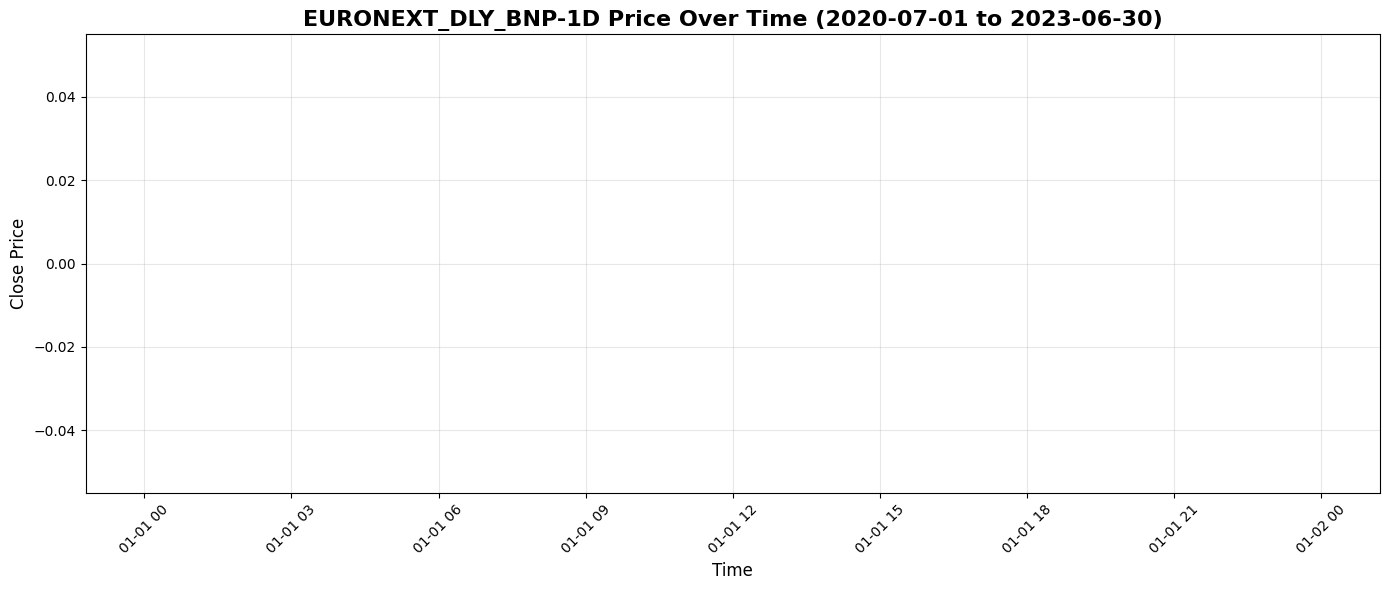

Đã lưu file đã xử lý tại: d:\Git\ToanMoHinh\tmh2025-vong2\data/sliver/G-SIB_Bank\EURONEXT_DLY_BNP-1D.csv

==================== Đang xử lý file: EURONEXT_DLY_GLE-1D.csv ====================
Thông tin dữ liệu sau khi xử lý:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    1095 non-null   datetime64[ns]
 1   close   0 non-null      float64       
 2   volume  0 non-null      float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 25.8 KB

5 dòng đầu:


,time,close,volume
0,2020-07-01,NaN,NaN
1,2020-07-02,NaN,NaN
2,2020-07-03,NaN,NaN
3,2020-07-04,NaN,NaN
4,2020-07-05,NaN,NaN


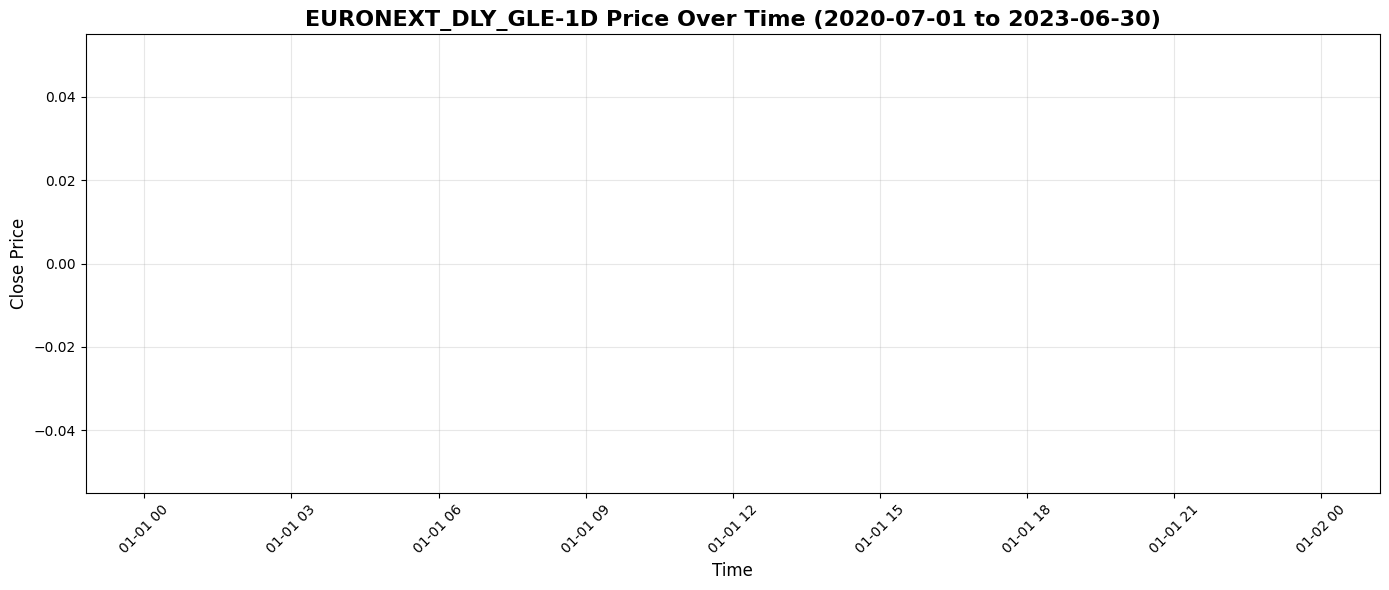

Đã lưu file đã xử lý tại: d:\Git\ToanMoHinh\tmh2025-vong2\data/sliver/G-SIB_Bank\EURONEXT_DLY_GLE-1D.csv

==================== Đang xử lý file: EURONEXT_DLY_INGA-1D.csv ====================
Thông tin dữ liệu sau khi xử lý:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    1095 non-null   datetime64[ns]
 1   close   0 non-null      float64       
 2   volume  0 non-null      float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 25.8 KB

5 dòng đầu:


,time,close,volume
0,2020-07-01,NaN,NaN
1,2020-07-02,NaN,NaN
2,2020-07-03,NaN,NaN
3,2020-07-04,NaN,NaN
4,2020-07-05,NaN,NaN


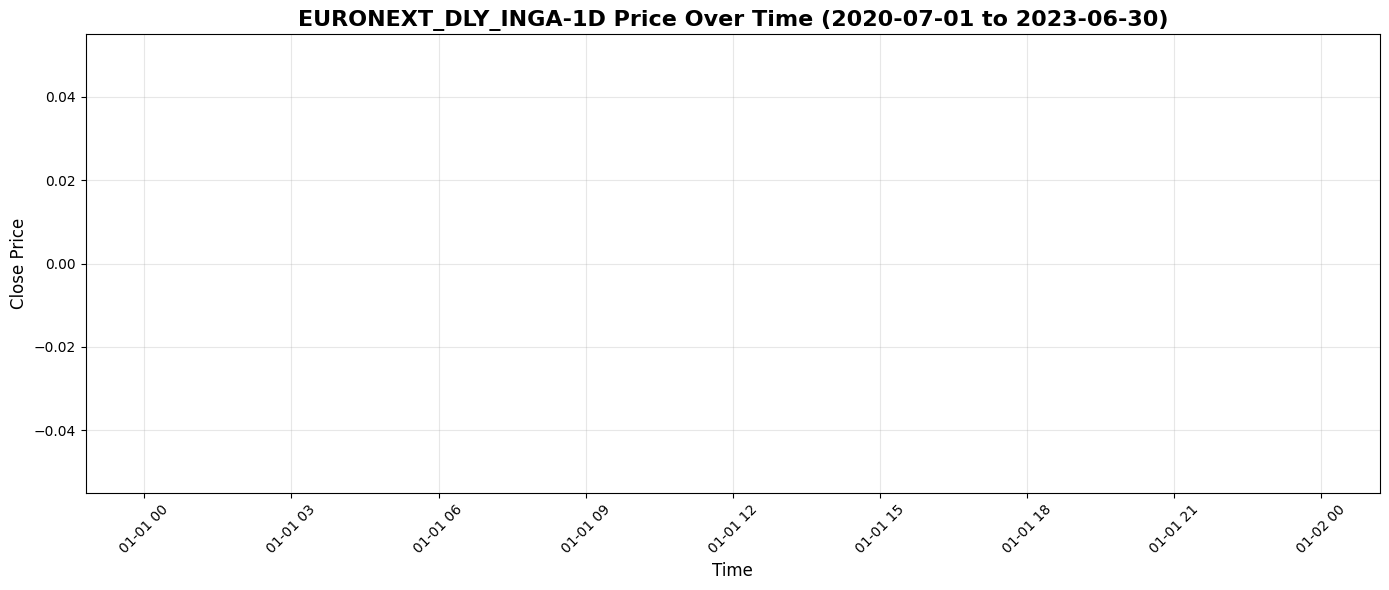

Đã lưu file đã xử lý tại: d:\Git\ToanMoHinh\tmh2025-vong2\data/sliver/G-SIB_Bank\EURONEXT_DLY_INGA-1D.csv

==================== Đang xử lý file: LSE_DLY_BARC-1D.csv ====================
Thông tin dữ liệu sau khi xử lý:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    1095 non-null   datetime64[ns]
 1   close   0 non-null      float64       
 2   volume  0 non-null      float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 25.8 KB

5 dòng đầu:


,time,close,volume
0,2020-07-01,NaN,NaN
1,2020-07-02,NaN,NaN
2,2020-07-03,NaN,NaN
3,2020-07-04,NaN,NaN
4,2020-07-05,NaN,NaN


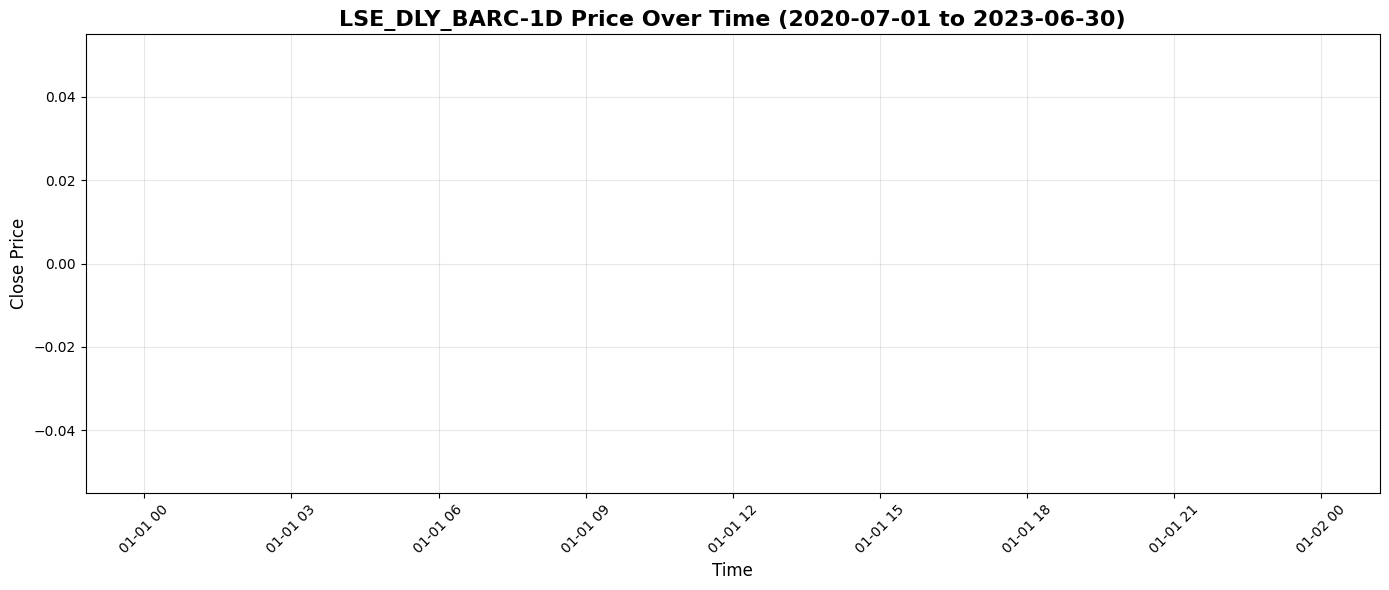

Đã lưu file đã xử lý tại: d:\Git\ToanMoHinh\tmh2025-vong2\data/sliver/G-SIB_Bank\LSE_DLY_BARC-1D.csv

==================== Đang xử lý file: LSE_DLY_HSBA-1D.csv ====================
Thông tin dữ liệu sau khi xử lý:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    1095 non-null   datetime64[ns]
 1   close   0 non-null      float64       
 2   volume  0 non-null      float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 25.8 KB

5 dòng đầu:


,time,close,volume
0,2020-07-01,NaN,NaN
1,2020-07-02,NaN,NaN
2,2020-07-03,NaN,NaN
3,2020-07-04,NaN,NaN
4,2020-07-05,NaN,NaN


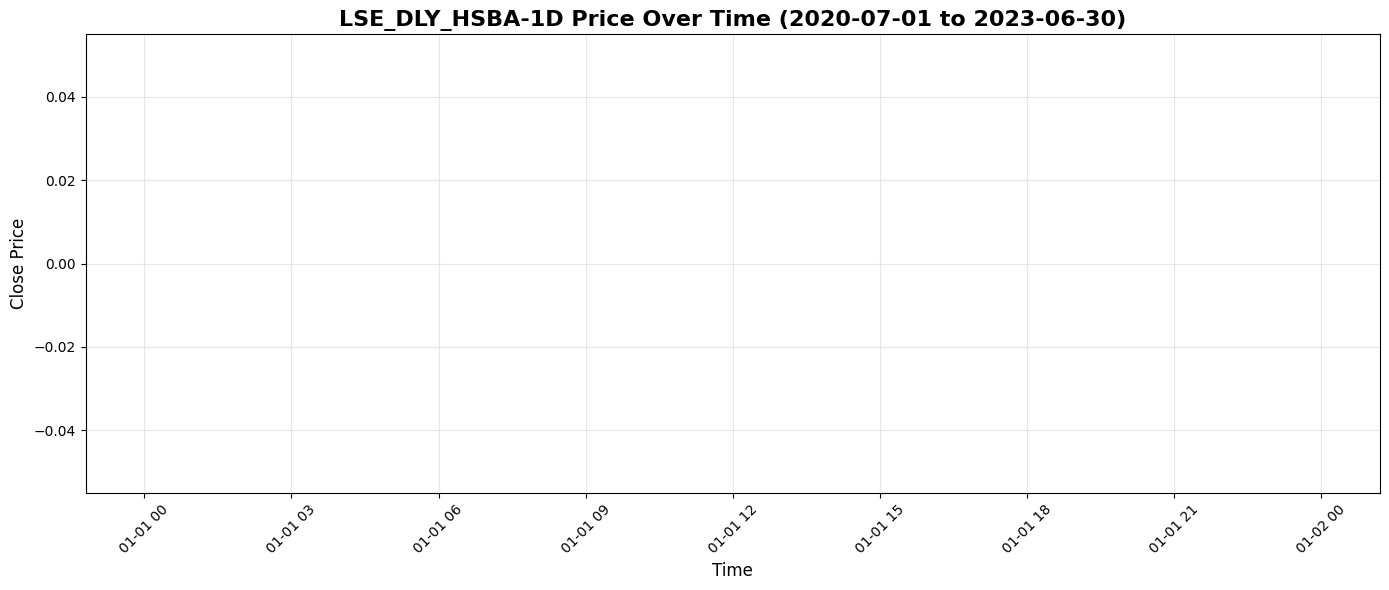

Đã lưu file đã xử lý tại: d:\Git\ToanMoHinh\tmh2025-vong2\data/sliver/G-SIB_Bank\LSE_DLY_HSBA-1D.csv

==================== Đang xử lý file: LSE_DLY_STAN-1D.csv ====================
Thông tin dữ liệu sau khi xử lý:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    1095 non-null   datetime64[ns]
 1   close   0 non-null      float64       
 2   volume  0 non-null      float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 25.8 KB

5 dòng đầu:


,time,close,volume
0,2020-07-01,NaN,NaN
1,2020-07-02,NaN,NaN
2,2020-07-03,NaN,NaN
3,2020-07-04,NaN,NaN
4,2020-07-05,NaN,NaN


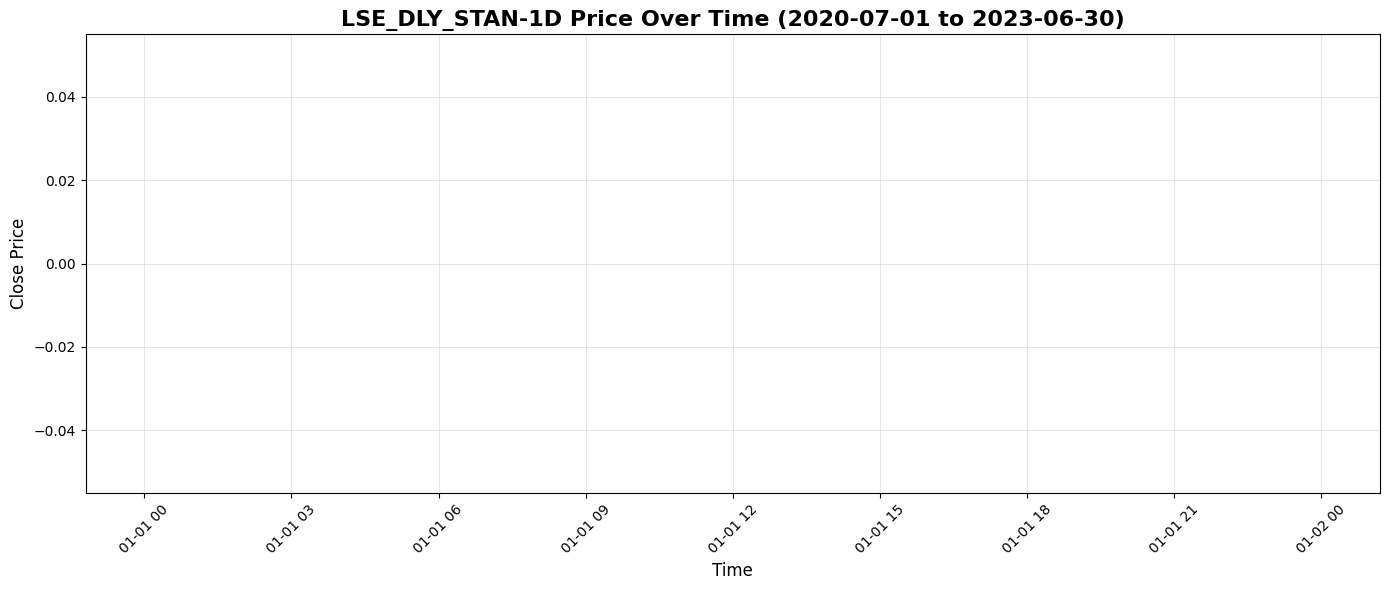

Đã lưu file đã xử lý tại: d:\Git\ToanMoHinh\tmh2025-vong2\data/sliver/G-SIB_Bank\LSE_DLY_STAN-1D.csv

==================== Đang xử lý file: MIL_LS_UCG-1D.csv ====================
Thông tin dữ liệu sau khi xử lý:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    1095 non-null   datetime64[ns]
 1   close   0 non-null      float64       
 2   volume  0 non-null      float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 25.8 KB

5 dòng đầu:


,time,close,volume
0,2020-07-01,NaN,NaN
1,2020-07-02,NaN,NaN
2,2020-07-03,NaN,NaN
3,2020-07-04,NaN,NaN
4,2020-07-05,NaN,NaN


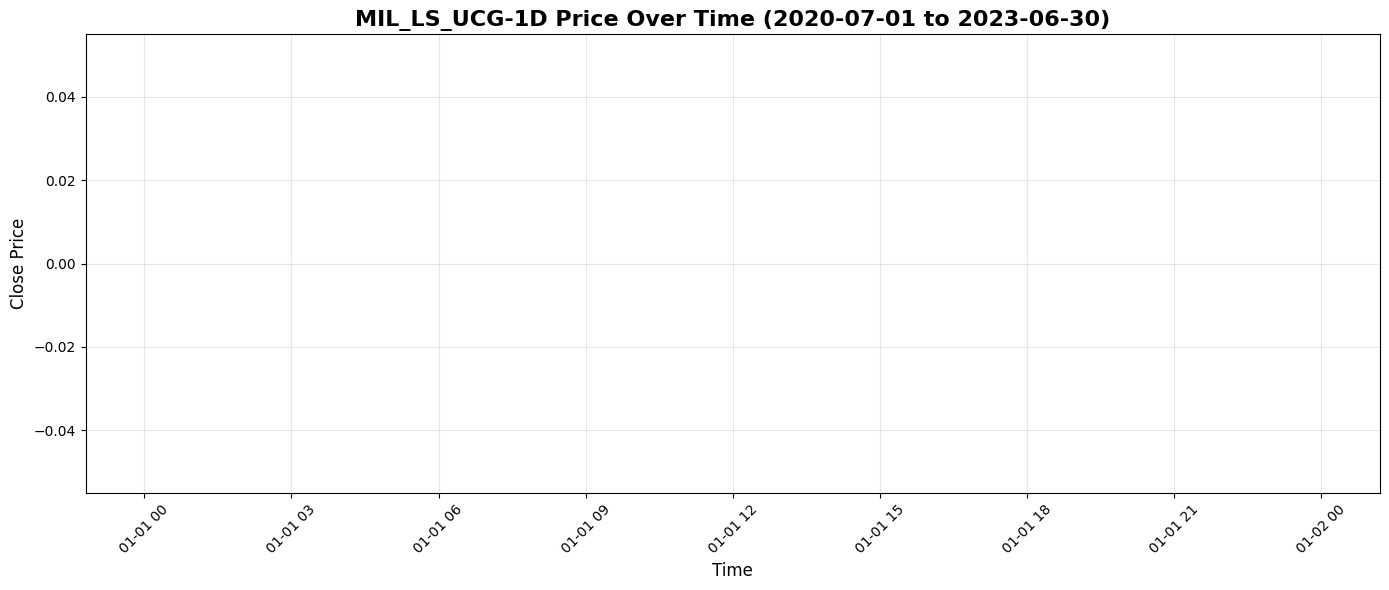

Đã lưu file đã xử lý tại: d:\Git\ToanMoHinh\tmh2025-vong2\data/sliver/G-SIB_Bank\MIL_LS_UCG-1D.csv

==================== Đang xử lý file: SIX_DLY_UBSG-1D.csv ====================
Thông tin dữ liệu sau khi xử lý:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    1095 non-null   datetime64[ns]
 1   close   0 non-null      float64       
 2   volume  0 non-null      float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 25.8 KB

5 dòng đầu:


,time,close,volume
0,2020-07-01,NaN,NaN
1,2020-07-02,NaN,NaN
2,2020-07-03,NaN,NaN
3,2020-07-04,NaN,NaN
4,2020-07-05,NaN,NaN


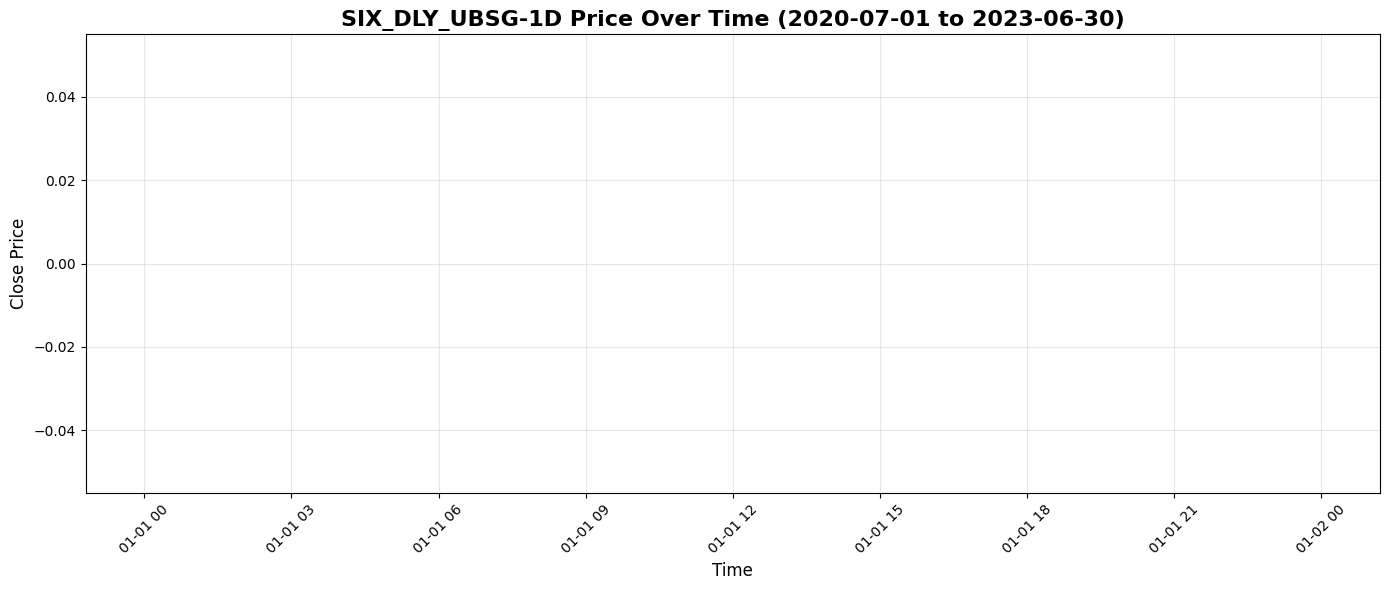

Đã lưu file đã xử lý tại: d:\Git\ToanMoHinh\tmh2025-vong2\data/sliver/G-SIB_Bank\SIX_DLY_UBSG-1D.csv

==================== Đang xử lý file: SSE_DLY_601288-1D.csv ====================
Thông tin dữ liệu sau khi xử lý:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    1095 non-null   datetime64[ns]
 1   close   1095 non-null   float64       
 2   volume  1095 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 25.8 KB

5 dòng đầu:


,time,close,volume
0,2020-07-01,3.39,179974646.0
1,2020-07-02,3.45,327696420.0
2,2020-07-03,3.51,371692270.0
3,2020-07-04,3.51,371692270.0
4,2020-07-05,3.51,371692270.0


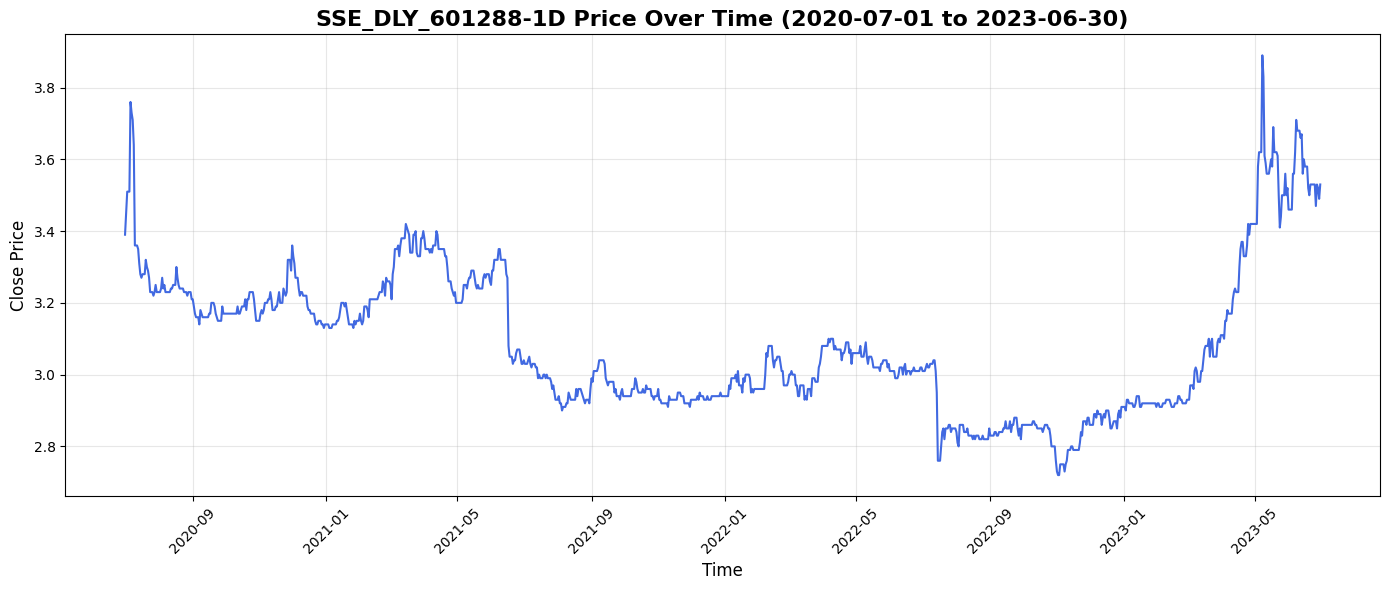

Đã lưu file đã xử lý tại: d:\Git\ToanMoHinh\tmh2025-vong2\data/sliver/G-SIB_Bank\SSE_DLY_601288-1D.csv

==================== Đang xử lý file: SSE_DLY_601398-1D.csv ====================
Thông tin dữ liệu sau khi xử lý:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    1095 non-null   datetime64[ns]
 1   close   0 non-null      float64       
 2   volume  0 non-null      float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 25.8 KB

5 dòng đầu:


,time,close,volume
0,2020-07-01,NaN,NaN
1,2020-07-02,NaN,NaN
2,2020-07-03,NaN,NaN
3,2020-07-04,NaN,NaN
4,2020-07-05,NaN,NaN


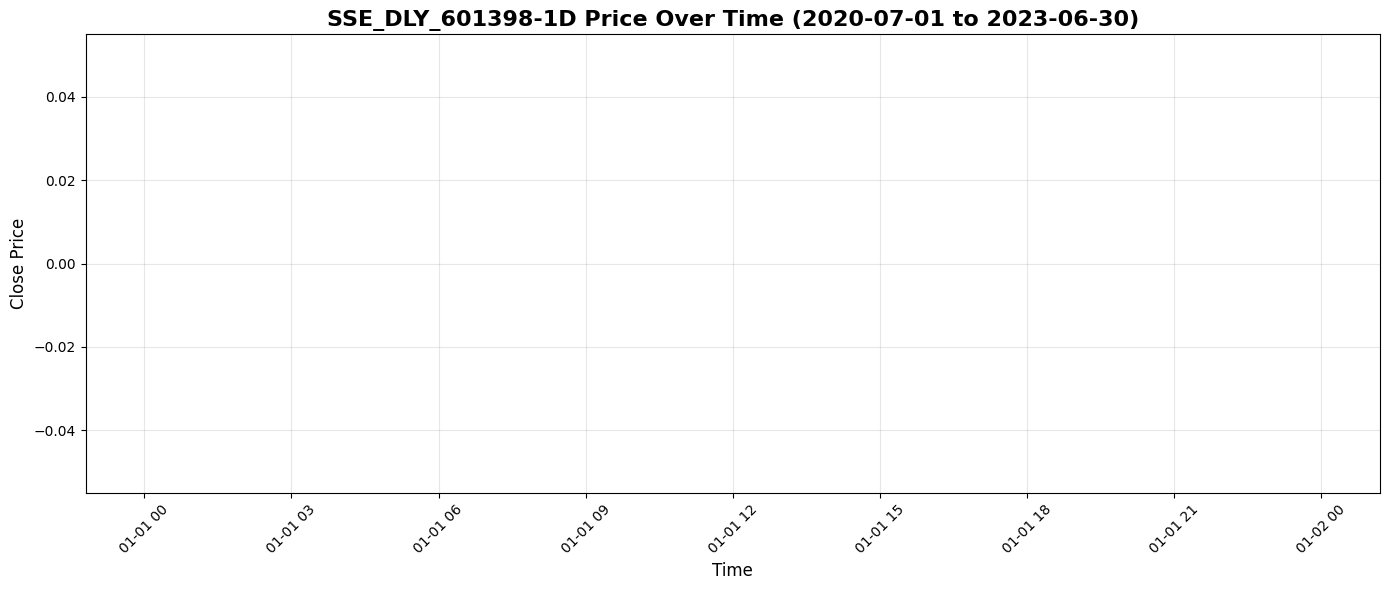

Đã lưu file đã xử lý tại: d:\Git\ToanMoHinh\tmh2025-vong2\data/sliver/G-SIB_Bank\SSE_DLY_601398-1D.csv

==================== Đang xử lý file: SSE_DLY_601939-1D.csv ====================
Thông tin dữ liệu sau khi xử lý:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    1095 non-null   datetime64[ns]
 1   close   0 non-null      float64       
 2   volume  0 non-null      float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 25.8 KB

5 dòng đầu:


,time,close,volume
0,2020-07-01,NaN,NaN
1,2020-07-02,NaN,NaN
2,2020-07-03,NaN,NaN
3,2020-07-04,NaN,NaN
4,2020-07-05,NaN,NaN


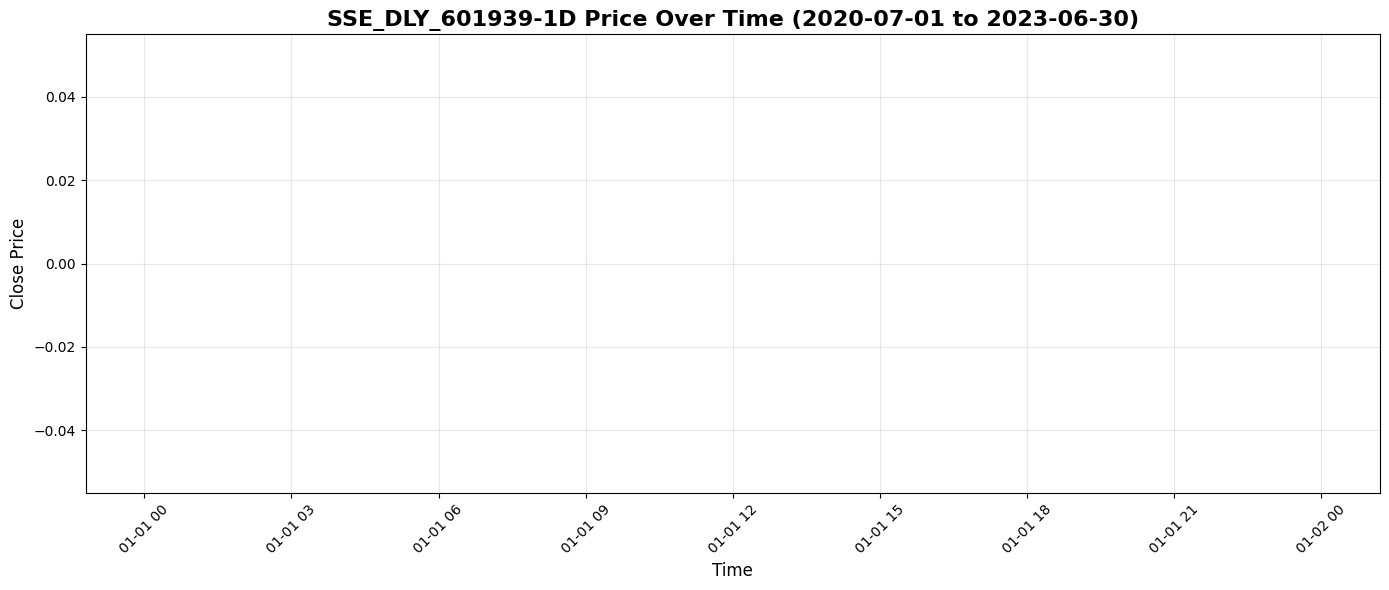

Đã lưu file đã xử lý tại: d:\Git\ToanMoHinh\tmh2025-vong2\data/sliver/G-SIB_Bank\SSE_DLY_601939-1D.csv

==================== Đang xử lý file: SSE_DLY_601988-1D.csv ====================
Thông tin dữ liệu sau khi xử lý:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    1095 non-null   datetime64[ns]
 1   close   1095 non-null   float64       
 2   volume  1095 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 25.8 KB

5 dòng đầu:


,time,close,volume
0,2020-07-01,3.50,77164171.0
1,2020-07-02,3.58,147455929.0
2,2020-07-03,3.63,160693547.0
3,2020-07-04,3.63,160693547.0
4,2020-07-05,3.63,160693547.0


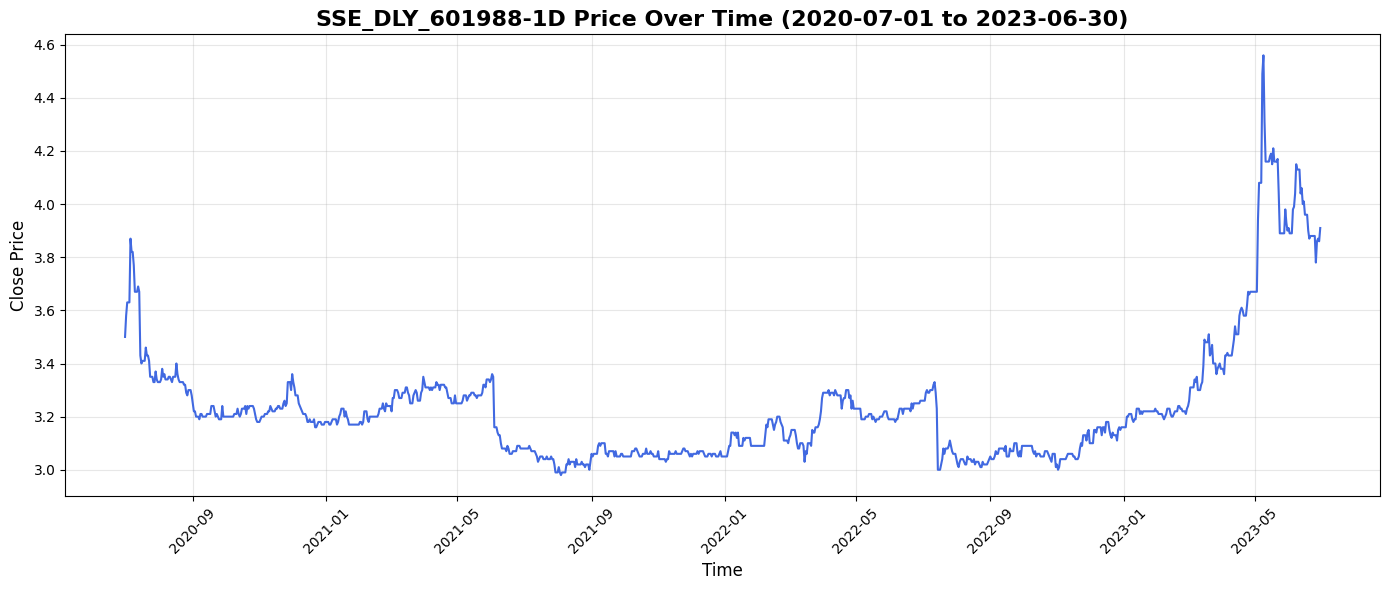

Đã lưu file đã xử lý tại: d:\Git\ToanMoHinh\tmh2025-vong2\data/sliver/G-SIB_Bank\SSE_DLY_601988-1D.csv

==================== Đang xử lý file: TSE_DLY_8306-1D.csv ====================
Thông tin dữ liệu sau khi xử lý:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    1095 non-null   datetime64[ns]
 1   close   0 non-null      float64       
 2   volume  0 non-null      float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 25.8 KB

5 dòng đầu:


,time,close,volume
0,2020-07-01,NaN,NaN
1,2020-07-02,NaN,NaN
2,2020-07-03,NaN,NaN
3,2020-07-04,NaN,NaN
4,2020-07-05,NaN,NaN


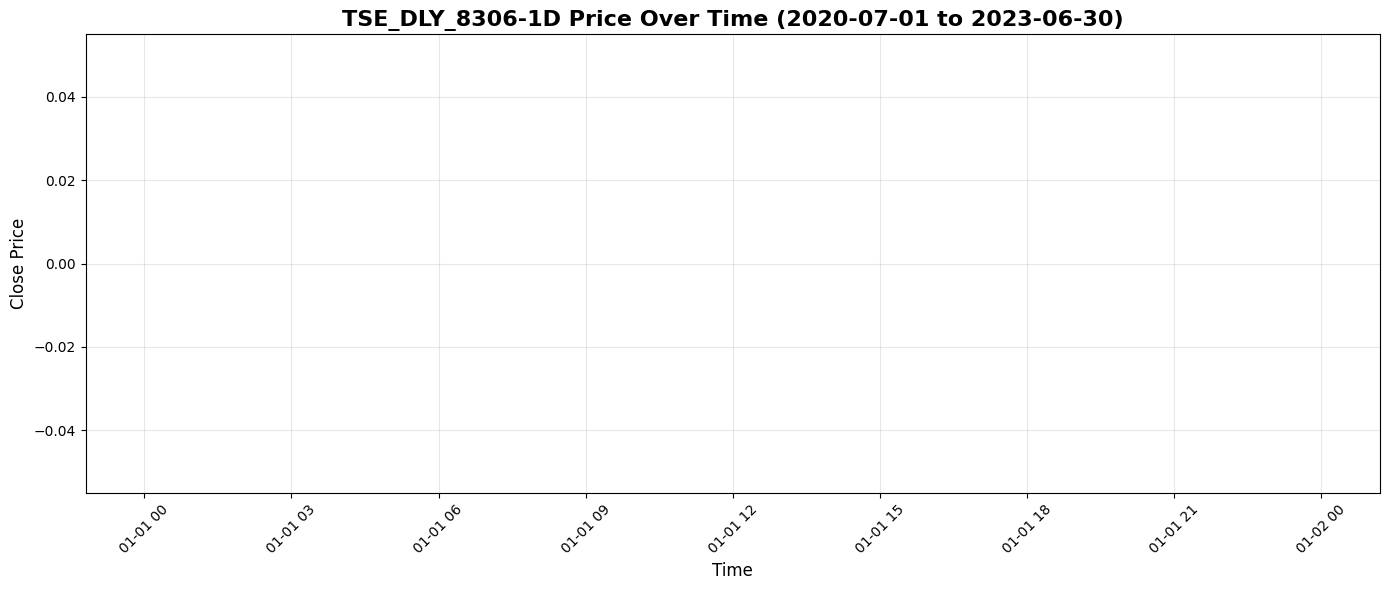

Đã lưu file đã xử lý tại: d:\Git\ToanMoHinh\tmh2025-vong2\data/sliver/G-SIB_Bank\TSE_DLY_8306-1D.csv

==================== Đang xử lý file: TSE_DLY_8316-1D.csv ====================
Thông tin dữ liệu sau khi xử lý:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    1095 non-null   datetime64[ns]
 1   close   0 non-null      float64       
 2   volume  0 non-null      float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 25.8 KB

5 dòng đầu:


,time,close,volume
0,2020-07-01,NaN,NaN
1,2020-07-02,NaN,NaN
2,2020-07-03,NaN,NaN
3,2020-07-04,NaN,NaN
4,2020-07-05,NaN,NaN


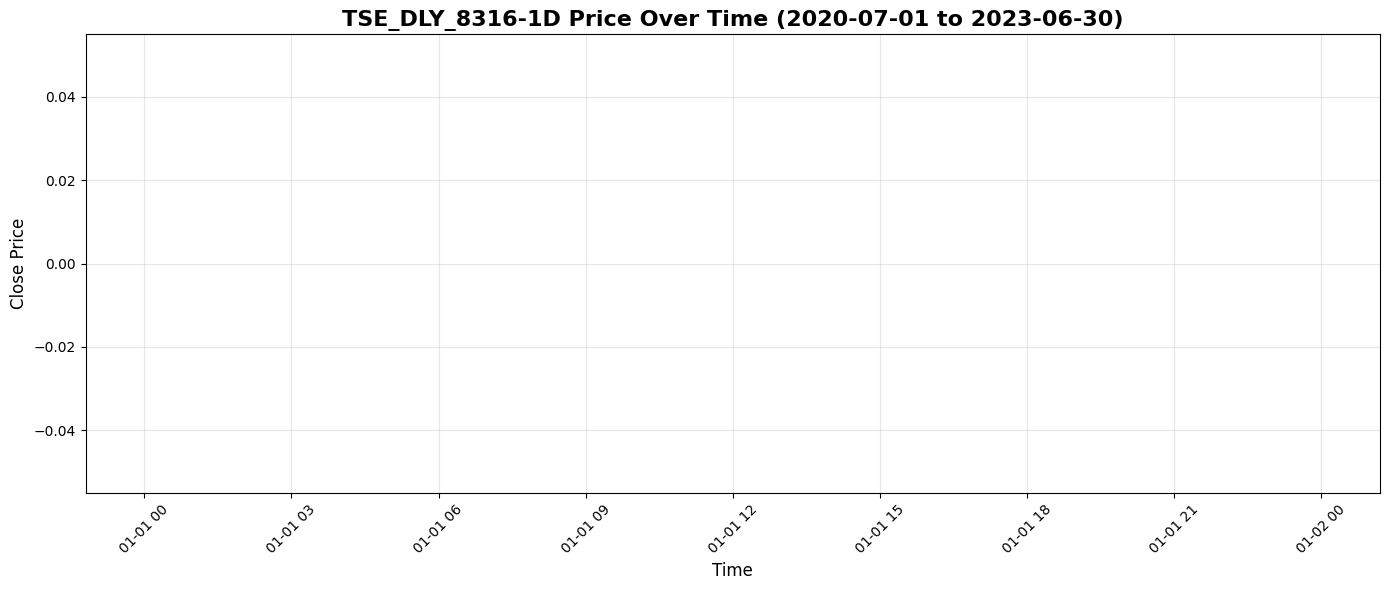

Đã lưu file đã xử lý tại: d:\Git\ToanMoHinh\tmh2025-vong2\data/sliver/G-SIB_Bank\TSE_DLY_8316-1D.csv

==================== Đang xử lý file: TSE_DLY_8411-1D.csv ====================
Thông tin dữ liệu sau khi xử lý:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    1095 non-null   datetime64[ns]
 1   close   0 non-null      float64       
 2   volume  0 non-null      float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 25.8 KB

5 dòng đầu:


,time,close,volume
0,2020-07-01,NaN,NaN
1,2020-07-02,NaN,NaN
2,2020-07-03,NaN,NaN
3,2020-07-04,NaN,NaN
4,2020-07-05,NaN,NaN


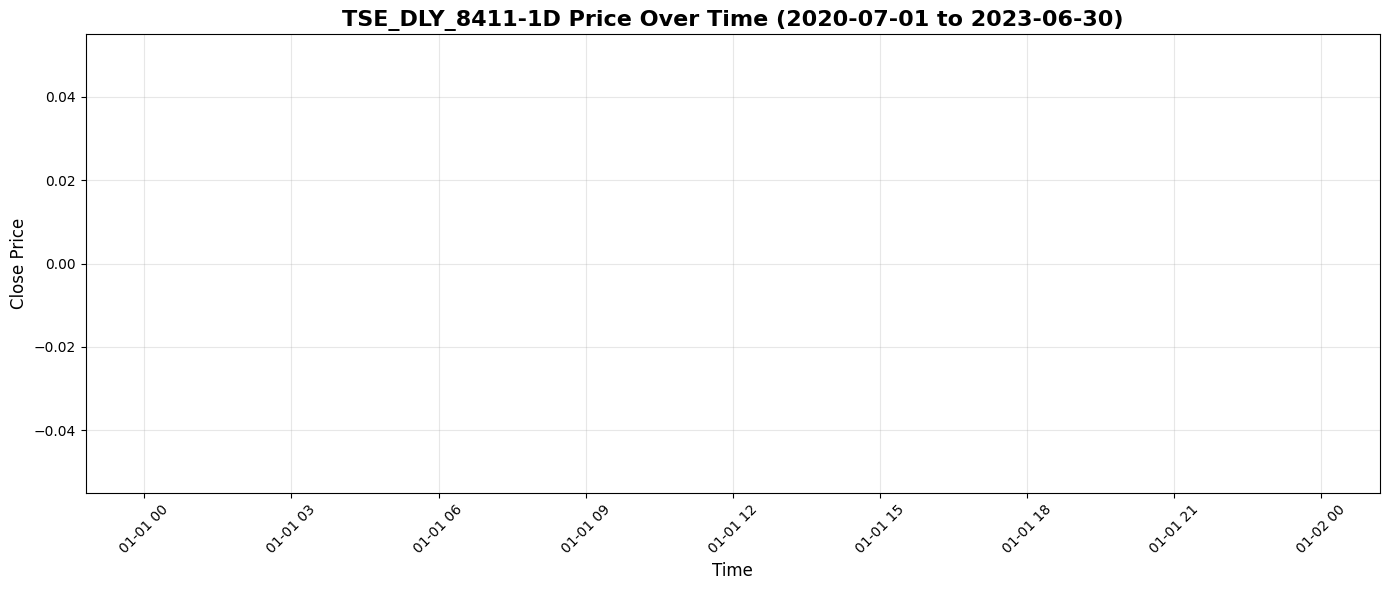

Đã lưu file đã xử lý tại: d:\Git\ToanMoHinh\tmh2025-vong2\data/sliver/G-SIB_Bank\TSE_DLY_8411-1D.csv

==================== Đang xử lý file: TSX_DLY_TD-1D.csv ====================
Thông tin dữ liệu sau khi xử lý:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    1095 non-null   datetime64[ns]
 1   close   0 non-null      float64       
 2   volume  0 non-null      float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 25.8 KB

5 dòng đầu:


,time,close,volume
0,2020-07-01,NaN,NaN
1,2020-07-02,NaN,NaN
2,2020-07-03,NaN,NaN
3,2020-07-04,NaN,NaN
4,2020-07-05,NaN,NaN


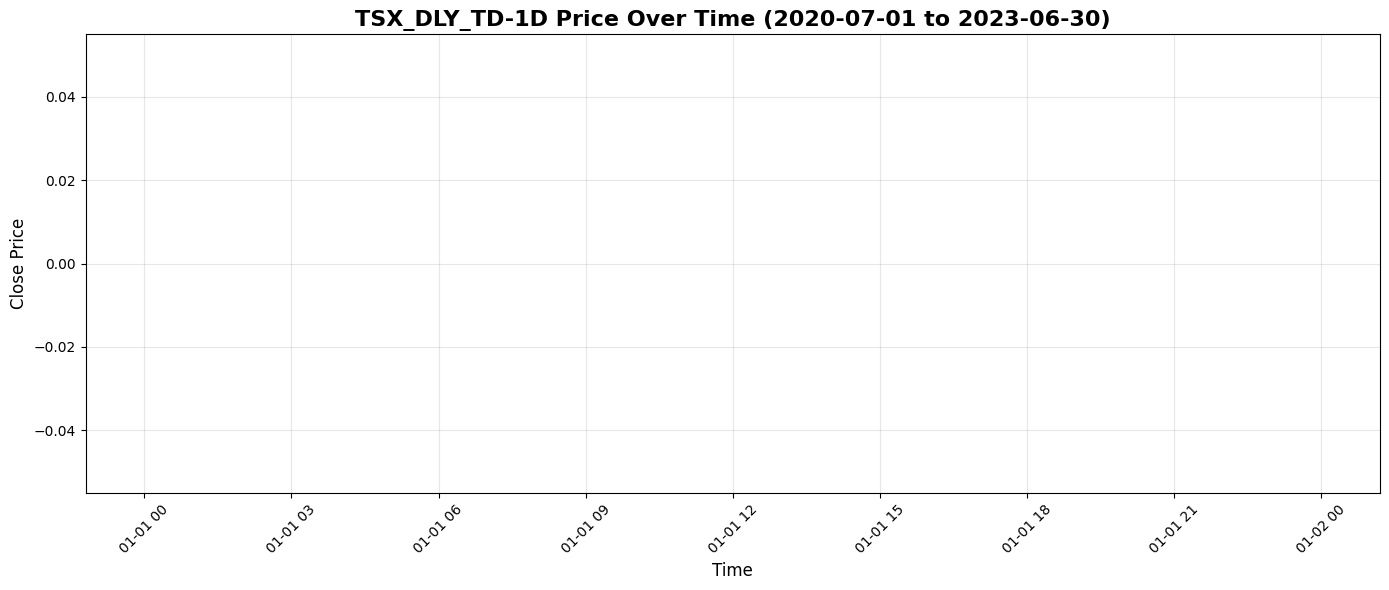

Đã lưu file đã xử lý tại: d:\Git\ToanMoHinh\tmh2025-vong2\data/sliver/G-SIB_Bank\TSX_DLY_TD-1D.csv

==================== Đang xử lý file: XETR_DLY_DBK-1D.csv ====================
Thông tin dữ liệu sau khi xử lý:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    1095 non-null   datetime64[ns]
 1   close   0 non-null      float64       
 2   volume  0 non-null      float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 25.8 KB

5 dòng đầu:


,time,close,volume
0,2020-07-01,NaN,NaN
1,2020-07-02,NaN,NaN
2,2020-07-03,NaN,NaN
3,2020-07-04,NaN,NaN
4,2020-07-05,NaN,NaN


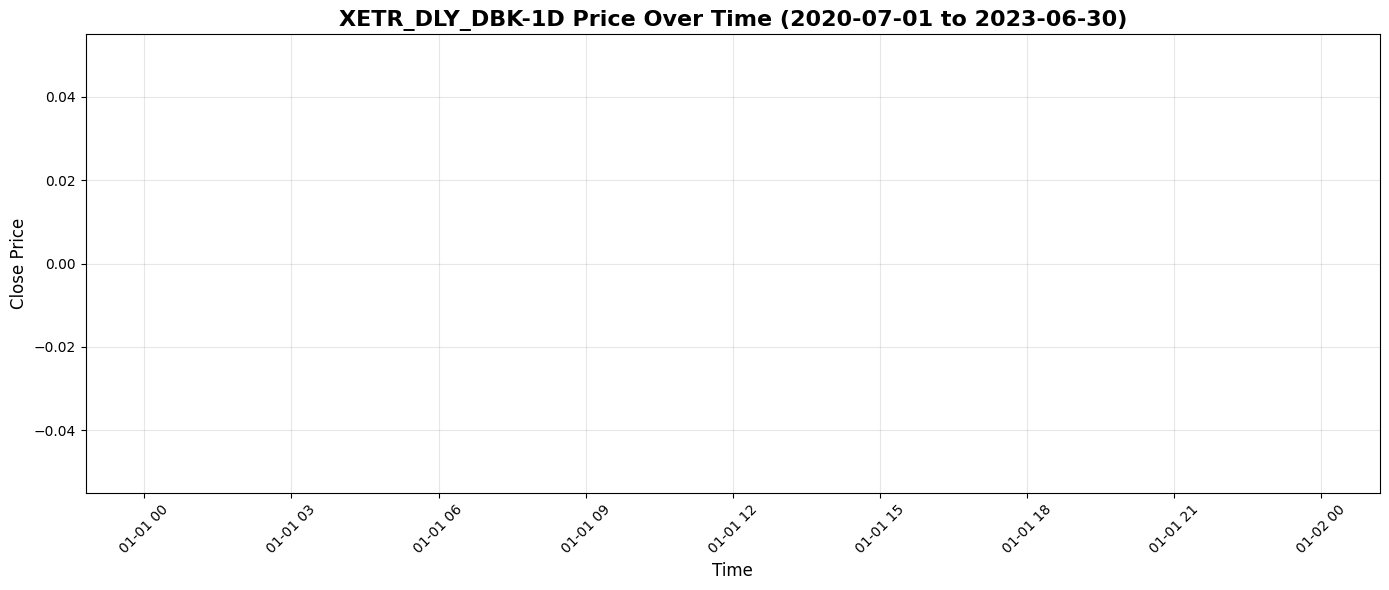

Đã lưu file đã xử lý tại: d:\Git\ToanMoHinh\tmh2025-vong2\data/sliver/G-SIB_Bank\XETR_DLY_DBK-1D.csv

==================== HOÀN TẤT! ĐÃ XỬ LÝ VÀ LƯU 29 FILE. ====================


In [20]:
# ------------------- PHẦN 1: THIẾT LẬP CÁC ĐƯỜNG DẪN VÀ THAM SỐ -------------------

# Lấy đường dẫn thư mục gốc của project
base_dir = os.getcwd()
project_dir = os.path.dirname(base_dir)

# Xác định thư mục chứa dữ liệu đầu vào (bronze) và đầu ra (sliver)
bronze_dir = os.path.join(project_dir, "data/bronze/G-SIB_Bank")
sliver_dir = os.path.join(project_dir, "data/sliver/G-SIB_Bank")

# Tạo thư mục đầu ra (sliver) nếu nó chưa tồn tại
os.makedirs(sliver_dir, exist_ok=True)
print(f"Thư mục đầu vào: {bronze_dir}")
print(f"Thư mục đầu ra: {sliver_dir}")

# Xác định khoảng thời gian cần lọc dữ liệu
start_day = '2020-07-01'
end_day = '2023-06-30'

# ------------------- PHẦN 2: TÌM VÀ LẶP QUA CÁC FILE DỮ LIỆU -------------------

# Tìm tất cả các file có đuôi .csv trong thư mục bronze
# Dùng glob.glob sẽ tiện lợi hơn os.listdir và kiểm tra đuôi file
csv_files = glob.glob(os.path.join(bronze_dir, "*.csv"))

print(f"\nTìm thấy {len(csv_files)} file CSV để xử lý.")

# Bắt đầu vòng lặp qua từng file
for file_path in csv_files:
    # Lấy tên file gốc (ví dụ: "BATS_BAC-1D.csv") để tiện cho việc đặt tên file đầu ra và in log
    file_name = os.path.basename(file_path)
    print(f"\n{'='*20} Đang xử lý file: {file_name} {'='*20}")

    # --- Đọc dữ liệu ---
    df = pd.read_csv(file_path)

    # --- Xử lý dữ liệu (giống như cell 2 của bạn) ---
    df_sliver = df[["time", "close", "Volume"]].copy()
    df_sliver = df_sliver.rename(columns={"Volume": "volume"})

    # Đảm bảo time là datetime
    df_sliver['time'] = pd.to_datetime(df_sliver['time'])
    df_sliver = df_sliver[(df_sliver['time'] >= start_day) & (df_sliver['time'] <= end_day)]

    # Tạo index đầy đủ các ngày trong khoảng
    full_index = pd.date_range(start=start_day, end=end_day, freq='D')

    # Đặt cột time làm index
    df_sliver = df_sliver.set_index('time')

    # Reindex theo full_index, điền giá trị bằng ffill
    df_sliver = df_sliver.reindex(full_index).ffill()

    # Đặt lại tên index thành time (giữ cột)
    df_sliver.index.name = 'time'
    df_sliver = df_sliver.reset_index()

    df_sliver.sort_values(by='time', inplace=True)
    
    # In ra vài dòng để kiểm tra
    print("Thông tin dữ liệu sau khi xử lý:")
    df_sliver.info()
    print("\n5 dòng đầu:")
    display(df_sliver.head())


    # --- Vẽ biểu đồ (giống như cell 4 của bạn) ---
    # Lưu ý: Chạy đoạn code này sẽ vẽ ra rất nhiều biểu đồ nếu bạn có nhiều file.
    # Bạn có thể comment (thêm # ở đầu dòng) phần này nếu không muốn vẽ biểu đồ cho mỗi file.
    plt.figure(figsize=(14, 6))
    plt.plot(df_sliver['time'], df_sliver['close'], color='royalblue', linewidth=1.5)

    # Thêm title, grid, label (tên title sẽ tự động cập nhật theo tên file)
    plot_title = f"{os.path.splitext(file_name)[0]} Price Over Time ({start_day} to {end_day})"
    plt.title(plot_title, fontsize=16, fontweight='bold')
    plt.xlabel("Time", fontsize=12)
    plt.ylabel("Close Price", fontsize=12)
    plt.grid(alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # --- Lưu file đã xử lý (giống như cell 5 của bạn) ---
    # Tạo đường dẫn file đầu ra, giữ nguyên tên file gốc
    output_path = os.path.join(sliver_dir, file_name)

    # Xuất df_sliver ra CSV
    df_sliver.to_csv(output_path, index=False)

    print(f"Đã lưu file đã xử lý tại: {output_path}")

print(f"\n{'='*20} HOÀN TẤT! ĐÃ XỬ LÝ VÀ LƯU {len(csv_files)} FILE. {'='*20}")